In [25]:
import numpy as np
import matplotlib.pyplot as plt
from pygsp import graphs, filters, plotting
import pygsp as pg
from numpy.random import default_rng
from numpy.random import randint
from random import sample
import random
import cvxpy as cp
import pandas as pd

In [26]:
def createGraph(Nodes):
    while True:
        s = np.array(sample(range(1, 10000), 1))
        G = pg.graphs.Sensor(N=Nodes, seed = s)
        if G.is_connected():
            break
    G.compute_fourier_basis()
    W = np.random.uniform(size=(2,1))
    x =  G.U[:,1:3]@W
    x = x/np.max(np.abs(x))
    return G,x

In [27]:
def computeMainSignal(signals,k,N):
    x = np.zeros((N,1))
    for i in range(k):
        x = x + signals[:,i].reshape(N,1)
    return x

In [28]:
def computeSmoothness(signals,graphs,k):
    smoothness = []
    sumOverSmoothness = 0
    for i in range(k):
        smoothness.append(signals[:,i].T@graphs[i].L@signals[:,i])
        sumOverSmoothness = sumOverSmoothness + smoothness[i]
    return sumOverSmoothness,smoothness

In [29]:
def decomposeGraphSignal(mainSignal,signals,graphs,lamda,k,N):
    A = np.tile(np.identity(N), (1, k))
    
    H = np.zeros((N*k,N*k))
    for i in range(k):
        g = graphs[i].L
        H[i*N:(i+1)*N,i*N:(i+1)*N] = g.toarray()
        
        
    X = cp.Variable((N*k,1))
    objective = cp.Minimize(cp.power(cp.norm(A @ X - mainSignal),2)+2*cp.quad_form(X, H)) 
    
    constraints = [ ]
    prob = cp.Problem(objective, constraints)
    prob.solve(verbose=True)
    
    temp = X.value
    X_hat = temp.reshape(N,k, order='F')
    
    return X_hat

In [30]:
def decomposeGraphSignal_eq(mainSignal,signals,graphs,k,N):
    A = np.tile(np.identity(N), (1, k))
    
    H = np.zeros((N*k,N*k))
    for i in range(k):
        g = graphs[i].L
        H[i*N:(i+1)*N,i*N:(i+1)*N] = g.toarray()
        
        
    X = cp.Variable((N*k,1))
    objective = cp.Minimize(cp.quad_form(X, H)) 
    
    constraints = [ A @ X == mainSignal]
    prob = cp.Problem(objective, constraints)
    prob.solve(verbose=True)
    
    temp = X.value
    X_hat = temp.reshape(N,k, order='F')
    
    return X_hat

In [31]:
def calculateSNR(est_signals,signals,k):
    SNR = []
    for i in range(k):
        SNR.append(10*np.log10(np.linalg.norm(signals[:,i])**2/np.linalg.norm(signals[:,i]-est_signals[:,i])**2))
    return SNR

In [32]:
N = 250   # number of nodes
k = 4     # number of graphs
# initialize lamda
lamda = 2 * np.ones((1,k))
np.random.seed(0)
random.seed(0)

# create graph and graph signals
graph_list = []
signals = np.zeros((N,k))
for i in range(k):
    G , x = createGraph(N)
    graph_list.append(G)
    signals[:,[i]] = x

In [33]:
noiseIter = 20
iteration = 20
av_mean_snr = np.zeros((1,noiseIter))
av_mean_snr_eq = np.zeros((1,noiseIter))
av_main_snr = np.zeros((1,noiseIter))
av_smoothness_vs_noise = np.zeros((1,noiseIter))
av_smoothness_eq_vs_noise = np.zeros((1,noiseIter))
for j in  range(noiseIter):
    print('----------------------------------------- Noise_iteration ',j+1,' ----------------------------------------')
    av_noise = 0
    av_snr = 0
    av_snr_eq = 0
    av_m_snr = 0
    av_smoothness = 0
    av_smoothness_eq = 0
    for i in range(1,iteration+1):
        print('########################################## iteration ',i,' ##########################################')
        # calculate the main signal : x = x1+x2+...+x4
        noise = np.random.normal(0, (0.05*j+0.05), (N,1))
        av_noise = av_noise + noise
        signal = computeMainSignal(signals,k,N)
        mainSignal = signal + noise
        mainSignal = mainSignal - np.mean(mainSignal)

        # main signal SNR
        M_SNR = 10*np.log10(np.linalg.norm(signal)**2/np.linalg.norm(noise)**2)
        print('main signal SNR:',M_SNR)
        av_m_snr = av_m_snr + M_SNR/iteration

        # decompose graph signal
        estimated_signals = decomposeGraphSignal(mainSignal,signals,graph_list,lamda,k,N)
        estimated_signals_eq = decomposeGraphSignal_eq(mainSignal,signals,graph_list,k,N)

        # calculate graph signals' smoothness
        sumOverSmoothness,smoothness = computeSmoothness(signals,graph_list,k)
        print('sum over smoothness:',sumOverSmoothness)

        # calculate estimated graph signals' smoothness
        sumOverSmoothness_est,smoothness_est = computeSmoothness(estimated_signals,graph_list,k)
        print('sum over smoothness_est:',sumOverSmoothness_est)
        av_smoothness = av_smoothness + sumOverSmoothness_est/iteration

        # calculate estimated graph signals' smoothness(eq)
        sumOverSmoothness_est_eq,smoothness_est_eq = computeSmoothness(estimated_signals_eq,graph_list,k)
        print('sum over smoothness_est_eq:',sumOverSmoothness_est_eq)
        av_smoothness_eq = av_smoothness_eq + sumOverSmoothness_est_eq/iteration

        # calculate SNRs
        SNRs = calculateSNR(estimated_signals,signals,k)
        #print('SNR:',SNRs)
        print('mean_SNR:',np.mean(SNRs))
        av_snr = av_snr + np.mean(SNRs)/iteration
        SNRs_eq = calculateSNR(estimated_signals_eq,signals,k)
        #print('SNR_eq:',SNRs_eq)
        print('mean_SNR_eq:',np.mean(SNRs_eq))
        av_snr_eq = av_snr_eq + np.mean(SNRs_eq)/iteration

        # compute objective values
        objectiveValue = lamda[0,0] * sumOverSmoothness
        objectiveValue_est = lamda[0,0] * sumOverSmoothness_est + np.linalg.norm(mainSignal-estimated_signals@np.ones((k,1)))
        print('objectiveValue:',objectiveValue)
        print('objectiveValue_est:',objectiveValue_est)

        # compute error
        error = np.linalg.norm(mainSignal-estimated_signals@np.ones((k,1)))
        print('error:',error)
        error_eq = np.linalg.norm(mainSignal-estimated_signals_eq@np.ones((k,1)))
        print('error:',error_eq)

    av_mean_snr[0,j] = av_snr
    av_mean_snr_eq[0,j] = av_snr_eq
    av_main_snr[0,j] = av_m_snr
    av_smoothness_vs_noise[0,j] = av_smoothness
    av_smoothness_eq_vs_noise[0,j] = av_smoothness_eq

----------------------------------------- Noise_iteration  1  ----------------------------------------
########################################## iteration  1  ##########################################
main signal SNR: 26.17144904961355

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.930e-01  +1e+04  4e-01  4e-05  1e+00  2e+03    ---    ---    1  1  - |  -  - 
 1  -3.954e-01  -1.655e-01  +3e+02  3e-02  1e-06  3e-01  8e+01  0.9679  1e-04   1  1  1 |  0  0
 2  -5.154e-01  -1.620e-01  +3e+02  2e-02  1e-06  4e-01  8e+01  0.0088  2e-01   1  2  2 |  0  0
 3  -8.995e-03  +1.455e-01  +1e+02  8e-03  4e-07  2e-01  3e+01  0.6602  7e-04   1  2  2 |  0  0
 4  -3.086e-01  +8.074e-03  +1e+02  8e-03  4e-07  3e-01  3e+01  0.0289  2e-01   1  2  2 |  0  0
 5  -5.482e-01  +1.774e-01  +9e+01  6e-03  4e-07  7e-01  2e+01  0.1570  1e-01   2  3  3 |  0  0



ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.930e-01  +1e+04  4e-01  4e-05  1e+00  2e+03    ---    ---    1  1  - |  -  - 
 1  -3.952e-01  -1.654e-01  +3e+02  3e-02  1e-06  3e-01  8e+01  0.9677  1e-04   1  1  1 |  0  0
 2  -5.152e-01  -1.613e-01  +3e+02  2e-02  1e-06  4e-01  8e+01  0.0087  2e-01   1  2  2 |  0  0
 3  -8.879e-03  +1.473e-01  +1e+02  8e-03  4e-07  2e-01  3e+01  0.6584  7e-04   1  2  2 |  0  0
 4  -3.188e-01  +8.691e-03  +1e+02  8e-03  4e-07  3e-01  3e+01  0.0299  2e-01   1  2  2 |  0  0
 5  -5.619e-01  +1.849e-01  +9e+01  6e-03  4e-07  8e-01  2e+01  0.1605  1e-01   2  3  3 |  0  0
 6  +2.287e+00  +2.888e+00  +2e+01  2e-03  1e-07  6e-01  6e+00  0.7374  2e-02   2  3  3 |  0  0
 7  +9.461e+00  +1.117e+01  +2e+01  2e-03  1e-07  2e+00  6e+00  0.2248  6e-01   3  4  4 |  0  0
 8  +2.595e+01  +2.692e+01  +6e+00  5e-04  4e-

 6  +2.286e+00  +2.888e+00  +2e+01  2e-03  1e-07  6e-01  6e+00  0.7362  2e-02   2  3  3 |  0  0
 7  +9.498e+00  +1.121e+01  +2e+01  2e-03  1e-07  2e+00  6e+00  0.2313  6e-01   3  4  5 |  0  0
 8  +2.539e+01  +2.639e+01  +7e+00  6e-04  4e-08  1e+00  2e+00  0.7446  3e-02   4  5  5 |  0  0
 9  +2.902e+01  +3.009e+01  +4e+00  3e-04  3e-08  1e+00  1e+00  0.5010  2e-01   5  6  6 |  0  0
10  +3.803e+01  +3.835e+01  +4e-01  1e-04  3e-09  3e-01  1e-01  0.9474  5e-02   4  5  5 |  0  0
11  +3.839e+01  +3.861e+01  +3e-01  5e-05  2e-09  2e-01  9e-02  0.6426  4e-01   4  5  4 |  0  0
12  +3.951e+01  +3.954e+01  +4e-02  2e-05  3e-10  3e-02  1e-02  0.8914  2e-02   3  4  4 |  0  0
13  +3.960e+01  +3.962e+01  +2e-02  2e-05  1e-10  2e-02  5e-03  0.7780  2e-01   4  4  4 |  0  0
14  +3.963e+01  +3.964e+01  +7e-03  1e-05  4e-11  9e-03  2e-03  0.9890  4e-01   4  4  4 |  0  0
15  +3.966e+01  +3.966e+01  +3e-04  2e-06  1e-12  2e-04  1e-04  0.9890  1e-02   4  4  4 |  0  0
16  +3.966e+01  +3.966e+01  +1e-05  3e-0

14  +3.927e+01  +3.928e+01  +7e-03  6e-06  5e-11  9e-03  2e-03  0.9890  2e-01   4  4  4 |  0  0
15  +3.930e+01  +3.930e+01  +1e-04  2e-06  2e-12  2e-04  5e-05  0.9829  4e-03   4  4  4 |  0  0
16  +3.930e+01  +3.930e+01  +1e-05  7e-07  1e-13  1e-05  4e-06  0.9520  2e-02   4  3  3 |  0  0
17  +3.930e+01  +3.930e+01  +2e-06  2e-07  1e-14  2e-06  6e-07  0.9312  8e-02   3  3  3 |  0  0
18  +3.930e+01  +3.930e+01  +3e-07  1e-07  4e-15  4e-07  1e-07  0.9491  8e-02   4  3  3 |  0  0
19  +3.930e+01  +3.930e+01  +7e-08  2e-08  8e-16  7e-08  2e-08  0.9890  1e-01   3  2  2 |  0  0
20  +3.930e+01  +3.930e+01  +2e-09  1e-08  5e-16  2e-09  6e-10  0.9830  8e-03   4  2  3 |  0  0
21  +3.930e+01  +3.930e+01  +5e-10  4e-09  2e-16  3e-10  1e-10  0.9890  9e-02   3  2  2 |  0  0

OPTIMAL (within feastol=4.3e-09, reltol=1.2e-11, abstol=4.8e-10).
Runtime: 6.482062 seconds.

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (

19  +3.949e+01  +3.949e+01  +8e-08  2e-08  1e-15  8e-08  2e-08  0.9890  1e-01   3  2  2 |  0  0
20  +3.949e+01  +3.949e+01  +2e-09  1e-08  6e-16  2e-09  6e-10  0.9881  1e-02   4  3  3 |  0  0
21  +3.949e+01  +3.949e+01  +4e-10  4e-09  2e-16  2e-10  1e-10  0.9890  7e-02   4  2  2 |  0  0

OPTIMAL (within feastol=4.1e-09, reltol=1.1e-11, abstol=4.5e-10).
Runtime: 6.134458 seconds.

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, constraints m = 250
          nnz(P) + nnz(A) = 7570
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter =

21  +3.949e+01  +3.949e+01  +4e-10  4e-09  2e-16  2e-10  1e-10  0.9890  6e-02   3  2  2 |  0  0

OPTIMAL (within feastol=3.9e-09, reltol=9.8e-12, abstol=3.9e-10).
Runtime: 6.829878 seconds.

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, constraints m = 250
          nnz(P) + nnz(A) = 7570
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua r


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.930e-01  +1e+04  4e-01  4e-05  1e+00  2e+03    ---    ---    1  1  - |  -  - 
 1  -3.953e-01  -1.655e-01  +3e+02  3e-02  1e-06  3e-01  8e+01  0.9678  1e-04   1  1  1 |  0  0
 2  -5.153e-01  -1.614e-01  +3e+02  2e-02  1e-06  4e-01  8e+01  0.0087  2e-01   1  2  2 |  0  0
 3  -1.325e-02  +1.442e-01  +1e+02  8e-03  4e-07  2e-01  3e+01  0.6527  7e-04   1  2  2 |  0  0
 4  -3.113e-01  +6.854e-03  +1e+02  8e-03  4e-07  3e-01  3e+01  0.0284  2e-01   1  2  2 |  0  0
 5  -5.758e-01  +1.541e-01  +9e+01  7e-03  4e-07  7e-01  2e+01  0.1497  1e-01   2  3  3 |  0  0
 6  +2.163e+00  +2.735e+00  +3e+01  2e-03  1e-07  6e-01  6e+00  0.7417  2e-02   2  3  3 |  0  0
 7  +9.201e+00  +1.085e+01  +2e+01  2e-03  1e-07  2e+00  6e+00  0.2211  6e-01   3  4  4 |  0  0
 8  +2.313e+01  +2.432e+01  +9e+00  8e-04  5e-

 1  -3.953e-01  -1.655e-01  +3e+02  3e-02  1e-06  3e-01  8e+01  0.9678  1e-04   1  1  1 |  0  0
 2  -5.154e-01  -1.615e-01  +3e+02  2e-02  1e-06  4e-01  8e+01  0.0088  2e-01   1  2  2 |  0  0
 3  -9.270e-03  +1.464e-01  +1e+02  8e-03  4e-07  2e-01  3e+01  0.6586  7e-04   1  2  2 |  0  0
 4  -3.129e-01  +8.767e-03  +1e+02  8e-03  4e-07  3e-01  3e+01  0.0293  2e-01   1  2  2 |  0  0
 5  -5.549e-01  +1.791e-01  +9e+01  7e-03  4e-07  7e-01  2e+01  0.1580  1e-01   2  2  3 |  0  0
 6  +2.237e+00  +2.827e+00  +2e+01  2e-03  1e-07  6e-01  6e+00  0.7372  2e-02   2  3  3 |  0  0
 7  +9.358e+00  +1.105e+01  +2e+01  2e-03  1e-07  2e+00  6e+00  0.2297  6e-01   3  4  4 |  0  0
 8  +2.455e+01  +2.560e+01  +7e+00  6e-04  4e-08  1e+00  2e+00  0.7152  3e-02   4  5  5 |  0  0
 9  +2.874e+01  +2.981e+01  +4e+00  3e-04  3e-08  1e+00  1e+00  0.5240  2e-01   4  6  6 |  0  0
10  +3.743e+01  +3.782e+01  +5e-01  1e-04  5e-09  4e-01  2e-01  0.9203  6e-02   4  5  5 |  0  0
11  +3.787e+01  +3.816e+01  +4e-01  5e-0

 4  -3.148e-01  +7.793e-03  +1e+02  8e-03  4e-07  3e-01  3e+01  0.0296  2e-01   1  2  2 |  0  0
 5  -5.544e-01  +1.839e-01  +9e+01  6e-03  4e-07  8e-01  2e+01  0.1598  1e-01   2  3  3 |  0  0
 6  +2.254e+00  +2.849e+00  +2e+01  2e-03  1e-07  6e-01  6e+00  0.7360  2e-02   2  3  3 |  0  0
 7  +9.454e+00  +1.116e+01  +2e+01  2e-03  1e-07  2e+00  6e+00  0.2360  6e-01   3  4  4 |  0  0
 8  +2.419e+01  +2.527e+01  +8e+00  7e-04  5e-08  1e+00  2e+00  0.6990  4e-02   4  5  5 |  0  0
 9  +2.895e+01  +2.999e+01  +4e+00  3e-04  3e-08  1e+00  1e+00  0.5545  2e-01   4  6  6 |  0  0
10  +3.722e+01  +3.763e+01  +6e-01  1e-04  5e-09  4e-01  2e-01  0.9117  7e-02   4  5  5 |  0  0
11  +3.772e+01  +3.803e+01  +4e-01  5e-05  3e-09  3e-01  1e-01  0.5824  4e-01   4  5  4 |  0  0
12  +3.918e+01  +3.923e+01  +6e-02  3e-05  5e-10  5e-02  2e-02  0.8682  1e-02   3  4  4 |  0  0
13  +3.932e+01  +3.935e+01  +3e-02  3e-05  2e-10  3e-02  1e-02  0.7274  3e-01   4  4  4 |  0  0
14  +3.940e+01  +3.941e+01  +8e-03  7e-0

15  +3.990e+01  +3.990e+01  +3e-05  4e-07  6e-14  3e-05  8e-06  0.9778  4e-02   4  3  3 |  0  0
16  +3.990e+01  +3.990e+01  +7e-07  2e-07  1e-14  9e-07  2e-07  0.9878  1e-02   4  3  3 |  0  0
17  +3.990e+01  +3.990e+01  +2e-07  6e-08  3e-15  1e-07  5e-08  0.9890  1e-01   4  3  3 |  0  0
18  +3.990e+01  +3.990e+01  +1e-08  3e-08  2e-15  8e-09  3e-09  0.9706  2e-02   4  3  3 |  0  0
19  +3.990e+01  +3.990e+01  +2e-09  6e-09  3e-16  2e-09  5e-10  0.9420  7e-02   4  2  2 |  0  0

OPTIMAL (within feastol=5.9e-09, reltol=4.6e-11, abstol=1.8e-09).
Runtime: 5.602037 seconds.

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, constraints m = 250
          nnz(P) + nnz(A) = 7570
settings: linear system solver = qdldl,
   

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, constraints m = 250
          nnz(P) + nnz(A) = 7570
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   3.24e+00   4.49e+03   1.00e-01   5.86e-02s
  50   2.7833e+01   2.10e-08   6.05e-08   1.48e-02   1.65e-01s
plsh   2.7833e+01   5.09e-16   8.40e-15   -


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.930e-01  +1e+04  4e-01  4e-05  1e+00  2e+03    ---    ---    1  1  - |  -  - 
 1  -3.952e-01  -1.655e-01  +3e+02  3e-02  1e-06  3e-01  8e+01  0.9674  1e-04   1  1  1 |  0  0
 2  -5.144e-01  -1.593e-01  +3e+02  2e-02  1e-06  4e-01  8e+01  0.0084  2e-01   1  2  2 |  0  0
 3  -3.970e-01  -5.779e-02  +2e+02  1e-02  6e-07  4e-01  4e+01  0.4791  4e-03   1  2  2 |  0  0
 4  -7.629e-01  -2.166e-02  +2e+02  1e-02  6e-07  8e-01  4e+01  0.0624  2e-01   2  2  2 |  0  0
 5  +5.829e-01  +1.108e+00  +5e+01  4e-03  2e-07  5e-01  1e+01  0.6816  1e-02   2  3  3 |  0  0
 6  +1.195e+00  +2.155e+00  +5e+01  3e-03  2e-07  1e+00  1e+01  0.1472  3e-01   2  3  3 |  0  0
 7  +6.666e+00  +8.083e+00  +3e+01  2e-03  1e-07  1e+00  7e+00  0.4930  1e-01   3  4  5 |  0  0
 8  +1.890e+01  +2.073e+01  +1e+01  6e-04  6e-

 9  +3.340e+01  +3.432e+01  +2e+00  2e-04  1e-08  9e-01  6e-01  0.8661  7e-02   4  5  5 |  0  0
10  +3.822e+01  +3.891e+01  +8e-01  1e-04  6e-09  7e-01  2e-01  0.9044  3e-01   4  5  5 |  0  0
11  +3.992e+01  +4.008e+01  +2e-01  3e-05  1e-09  2e-01  6e-02  0.9173  1e-01   4  5  4 |  0  0
12  +4.054e+01  +4.054e+01  +6e-03  1e-05  5e-11  6e-03  2e-03  0.9675  2e-03   3  4  4 |  0  0
13  +4.057e+01  +4.057e+01  +7e-04  4e-06  4e-12  9e-04  2e-04  0.9726  7e-02   3  4  4 |  0  0
14  +4.057e+01  +4.057e+01  +3e-04  3e-06  1e-12  3e-04  8e-05  0.8710  2e-01   4  4  4 |  0  0
15  +4.057e+01  +4.057e+01  +4e-05  4e-07  1e-13  5e-05  1e-05  0.9886  1e-01   3  3  3 |  0  0
16  +4.057e+01  +4.057e+01  +1e-06  3e-07  2e-14  2e-06  4e-07  0.9836  2e-02   4  3  3 |  0  0
17  +4.057e+01  +4.057e+01  +3e-07  1e-07  5e-15  3e-07  9e-08  0.9221  5e-02   4  3  3 |  0  0
18  +4.057e+01  +4.057e+01  +6e-08  3e-08  5e-15  7e-08  2e-08  0.9876  1e-01   4  2  2 |  0  0
19  +4.057e+01  +4.057e+01  +3e-09  1e-0

16  +3.963e+01  +3.963e+01  +2e-05  3e-07  2e-13  2e-05  6e-06  0.8931  2e-01   4  4  3 |  0  0
17  +3.963e+01  +3.963e+01  +2e-06  1e-07  5e-15  2e-06  5e-07  0.9198  2e-03   4  3  3 |  0  0
18  +3.963e+01  +3.963e+01  +4e-07  7e-08  2e-14  5e-07  1e-07  0.8522  1e-01   4  3  3 |  0  0
19  +3.963e+01  +3.963e+01  +1e-07  3e-08  2e-15  1e-07  3e-08  0.9890  2e-01   4  3  2 |  0  0
20  +3.963e+01  +3.963e+01  +2e-09  6e-09  6e-16  2e-09  5e-10  0.9890  2e-03   4  2  2 |  0  0

OPTIMAL (within feastol=6.1e-09, reltol=3.9e-11, abstol=1.6e-09).
Runtime: 6.202932 seconds.

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, constraints m = 250
          nnz(P) + nnz(A) = 7570
settings: linear system solver = qdldl,
   

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, constraints m = 250
          nnz(P) + nnz(A) = 7570
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   3.05e+00   4.52e+03   1.00e-01   7.36e-02s
  50   2.7639e+01   2.09e-08   6.09e-08   1.42e-02   1.97e-01s
plsh   2.7639e+01   4.60e-16   1.22e-14   -


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.930e-01  +1e+04  4e-01  4e-05  1e+00  2e+03    ---    ---    1  1  - |  -  - 
 1  -3.951e-01  -1.655e-01  +3e+02  3e-02  1e-06  3e-01  8e+01  0.9673  1e-04   1  1  1 |  0  0
 2  -5.144e-01  -1.592e-01  +3e+02  2e-02  1e-06  4e-01  8e+01  0.0084  2e-01   1  2  2 |  0  0
 3  -2.885e-01  +2.993e-03  +1e+02  1e-02  6e-07  3e-01  4e+01  0.5495  3e-03   1  2  2 |  0  0
 4  -5.544e-01  +6.377e-02  +1e+02  1e-02  5e-07  6e-01  4e+01  0.0476  2e-01   2  2  2 |  0  0
 5  +3.972e-01  +9.694e-01  +6e+01  5e-03  2e-07  6e-01  2e+01  0.5637  1e-02   2  3  3 |  0  0
 6  +9.621e-01  +2.068e+00  +5e+01  4e-03  2e-07  1e+00  1e+01  0.2035  2e-01   2  3  3 |  0  0
 7  +7.404e+00  +8.779e+00  +2e+01  2e-03  1e-07  1e+00  6e+00  0.6198  1e-01   3  4  4 |  0  0
 8  +1.808e+01  +2.016e+01  +1e+01  7e-04  7e-

 2  -5.144e-01  -1.596e-01  +3e+02  2e-02  1e-06  4e-01  8e+01  0.0084  2e-01   1  2  2 |  0  0
 3  -3.793e-01  -4.836e-02  +2e+02  1e-02  6e-07  4e-01  4e+01  0.4907  4e-03   1  2  2 |  0  0
 4  -7.280e-01  -8.840e-03  +2e+02  1e-02  6e-07  7e-01  4e+01  0.0600  2e-01   2  2  2 |  0  0
 5  +5.465e-01  +1.081e+00  +5e+01  4e-03  2e-07  5e-01  1e+01  0.6640  1e-02   2  3  3 |  0  0
 6  +1.142e+00  +2.127e+00  +5e+01  3e-03  2e-07  1e+00  1e+01  0.1567  2e-01   2  3  3 |  0  0
 7  +6.806e+00  +8.213e+00  +2e+01  2e-03  1e-07  1e+00  6e+00  0.5202  1e-01   3  4  4 |  0  0
 8  +1.860e+01  +2.044e+01  +1e+01  7e-04  6e-08  2e+00  3e+00  0.6781  2e-01   4  5  5 |  0  0
 9  +3.446e+01  +3.524e+01  +2e+00  2e-04  1e-08  8e-01  5e-01  0.9204  5e-02   4  5  5 |  0  0
10  +3.771e+01  +3.854e+01  +9e-01  2e-04  7e-09  8e-01  3e-01  0.9890  5e-01   4  5  4 |  0  0
11  +4.014e+01  +4.023e+01  +9e-02  3e-05  7e-10  8e-02  3e-02  0.9229  2e-02   4  5  5 |  0  0
12  +4.041e+01  +4.042e+01  +8e-03  9e-0

 9  +3.218e+01  +3.307e+01  +3e+00  2e-04  2e-08  9e-01  7e-01  0.8197  4e-02   4  5  5 |  0  0
10  +3.277e+01  +3.374e+01  +2e+00  2e-04  2e-08  1e+00  7e-01  0.2694  6e-01   4  6  4 |  0  0
11  +3.935e+01  +3.971e+01  +3e-01  1e-04  3e-09  4e-01  1e-01  0.9810  1e-01   4  5  5 |  0  0
12  +4.033e+01  +4.037e+01  +4e-02  2e-05  3e-10  5e-02  1e-02  0.9488  6e-02   4  4  4 |  0  0
13  +4.045e+01  +4.046e+01  +8e-03  8e-06  6e-11  9e-03  2e-03  0.9091  9e-02   3  4  4 |  0  0
14  +4.050e+01  +4.050e+01  +6e-04  4e-06  4e-12  7e-04  2e-04  0.9516  2e-02   4  4  4 |  0  0
15  +4.050e+01  +4.050e+01  +1e-04  1e-06  6e-13  1e-04  4e-05  0.8961  8e-02   3  3  3 |  0  0
16  +4.050e+01  +4.050e+01  +3e-05  9e-07  9e-14  3e-05  9e-06  0.9334  1e-01   4  4  4 |  0  0
17  +4.050e+01  +4.050e+01  +6e-06  2e-07  1e-14  6e-06  2e-06  0.9890  1e-01   3  3  3 |  0  0
18  +4.050e+01  +4.050e+01  +2e-07  1e-07  4e-15  2e-07  5e-08  0.9821  1e-02   4  3  3 |  0  0
19  +4.050e+01  +4.050e+01  +4e-08  4e-0

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, constraints m = 250
          nnz(P) + nnz(A) = 7570
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   3.24e+00   4.56e+03   1.00e-01   6.00e-02s
  50   2.7894e+01   5.63e-09   6.14e-08   1.00e-01   9.65e-02s
plsh   2.7894e+01   5.03e-16   9.01e-15   -

sum over smoothness_est_eq: 31.107727646527483
mean_SNR: 13.257171016896187
mean_SNR_eq: 17.93976749808086
objectiveValue: 49.31471397755848
objectiveValue_est: 36.26849613629355
error: 2.995593224156185
error: 3.568433712646726e-15
########################################## iteration  3  ##########################################
main signal SNR: 15.840609667014235

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.930e-01  +1e+04  4e-01  4e-05  1e+00  2e+03    ---    ---    1  1  - |  -  - 
 1  -3.946e-01  -1.655e-01  +3e+02  3e-02  1e-06  3e-01  8e+01  0.9661  1e-04   1  1  1 |  0  0
 2  -5.116e-01  -1.536e-01  +3e+02  2e-02  1e-06  4e-01  8e+01  0.0076  2e-01   1  2  2 |  0  0
 3  -8.927e-01  -3.256e-01  +3e+02  2e-02  1e-06  6e-01  7e+01  0.1633  2e-02   1  2  2 |  0  0
 4  -1.764e+00  -3.949e-01  +2e+02  2e-02  1e-06  1e+00  6e+0

 2  -5.127e-01  -1.554e-01  +3e+02  2e-02  1e-06  4e-01  8e+01  0.0079  2e-01   1  2  2 |  0  0
 3  -8.604e-01  -3.100e-01  +3e+02  2e-02  1e-06  6e-01  7e+01  0.1819  2e-02   1  2  2 |  0  0
 4  -1.690e+00  -3.742e-01  +2e+02  1e-02  9e-07  1e+00  6e+01  0.1284  1e-01   2  2  2 |  0  0
 5  +6.100e-01  +1.147e+00  +4e+01  3e-03  2e-07  5e-01  1e+01  0.8361  6e-03   2  3  3 |  0  0
 6  +2.063e+00  +3.070e+00  +4e+01  3e-03  2e-07  1e+00  9e+00  0.1250  4e-01   2  3  3 |  0  0
 7  +5.111e+00  +7.333e+00  +3e+01  2e-03  1e-07  2e+00  8e+00  0.2869  4e-01   3  5  5 |  0  0
 8  +2.443e+01  +2.575e+01  +7e+00  4e-04  4e-08  1e+00  2e+00  0.8368  6e-02   4  5  5 |  0  0
 9  +3.263e+01  +3.492e+01  +3e+00  2e-04  3e-08  2e+00  1e+00  0.9890  5e-01   5  6  5 |  0  0
10  +4.156e+01  +4.181e+01  +1e-01  6e-05  2e-09  3e-01  5e-02  0.9495  8e-03   4  5  5 |  0  0
11  +4.231e+01  +4.234e+01  +3e-02  2e-05  3e-10  3e-02  9e-03  0.9890  1e-01   4  4  4 |  0  0
12  +4.240e+01  +4.240e+01  +2e-03  5e-0

12  +4.339e+01  +4.340e+01  +2e-03  5e-06  2e-11  2e-03  5e-04  0.9598  2e-02   4  4  4 |  0  0
13  +4.341e+01  +4.341e+01  +2e-04  3e-06  2e-12  2e-04  6e-05  0.9493  5e-02   4  4  4 |  0  0
14  +4.341e+01  +4.341e+01  +3e-05  5e-07  2e-13  4e-05  1e-05  0.9668  8e-02   3  3  3 |  0  0
15  +4.341e+01  +4.341e+01  +2e-06  3e-07  2e-14  2e-06  5e-07  0.9860  3e-02   4  3  3 |  0  0
16  +4.341e+01  +4.341e+01  +4e-07  6e-08  4e-15  3e-07  1e-07  0.9890  1e-01   4  3  3 |  0  0
17  +4.341e+01  +4.341e+01  +3e-08  3e-08  2e-15  3e-08  8e-09  0.9688  3e-02   4  3  3 |  0  0
18  +4.341e+01  +4.341e+01  +6e-09  7e-09  3e-16  5e-09  2e-09  0.9890  1e-01   4  2  2 |  0  0

OPTIMAL (within feastol=7.2e-09, reltol=1.5e-10, abstol=6.5e-09).
Runtime: 5.359014 seconds.

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019


-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, constraints m = 250
          nnz(P) + nnz(A) = 7570
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   3.14e+00   4.68e+03   1.00e-01   6.16e-02s
  50   3.3389e+01   5.52e-09   6.30e-08   1.00e-01   1.09e-01s
plsh   3.3389e+01   4.01e-16   1.36e-14   -


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.930e-01  +1e+04  4e-01  4e-05  1e+00  2e+03    ---    ---    1  1  - |  -  - 
 1  -3.947e-01  -1.655e-01  +3e+02  3e-02  1e-06  3e-01  8e+01  0.9663  1e-04   1  1  1 |  0  0
 2  -5.123e-01  -1.540e-01  +3e+02  2e-02  1e-06  4e-01  8e+01  0.0077  2e-01   1  2  2 |  0  0
 3  -8.627e-01  -3.097e-01  +3e+02  2e-02  1e-06  6e-01  7e+01  0.1832  2e-02   1  2  2 |  0  0
 4  -1.700e+00  -3.711e-01  +2e+02  1e-02  9e-07  1e+00  6e+01  0.1270  1e-01   2  2  2 |  0  0
 5  +6.504e-01  +1.188e+00  +4e+01  3e-03  2e-07  5e-01  1e+01  0.8371  6e-03   2  3  3 |  0  0
 6  +2.178e+00  +3.186e+00  +4e+01  3e-03  2e-07  1e+00  9e+00  0.1203  4e-01   2  3  3 |  0  0
 7  +5.078e+00  +7.310e+00  +3e+01  2e-03  2e-07  2e+00  8e+00  0.2723  5e-01   3  4  5 |  0  0
 8  +2.511e+01  +2.649e+01  +7e+00  4e-04  4e-

 9  +3.194e+01  +3.414e+01  +3e+00  2e-04  2e-08  2e+00  1e+00  0.9890  5e-01   5  6  5 |  0  0
10  +4.077e+01  +4.104e+01  +1e-01  6e-05  2e-09  3e-01  5e-02  0.9447  8e-03   4  5  5 |  0  0
11  +4.162e+01  +4.167e+01  +4e-02  3e-05  3e-10  4e-02  1e-02  0.9890  2e-01   4  4  4 |  0  0
12  +4.175e+01  +4.175e+01  +3e-03  6e-06  2e-11  3e-03  8e-04  0.9614  2e-02   4  4  4 |  0  0
13  +4.176e+01  +4.176e+01  +2e-04  3e-06  2e-12  2e-04  7e-05  0.9622  3e-02   4  4  4 |  0  0
14  +4.176e+01  +4.176e+01  +4e-05  6e-07  2e-13  4e-05  1e-05  0.9645  8e-02   4  3  3 |  0  0
15  +4.176e+01  +4.176e+01  +3e-06  3e-07  2e-14  3e-06  8e-07  0.9757  4e-02   4  3  3 |  0  0
16  +4.176e+01  +4.176e+01  +7e-07  7e-08  5e-15  6e-07  2e-07  0.9890  1e-01   4  3  3 |  0  0
17  +4.176e+01  +4.176e+01  +2e-08  4e-08  2e-15  2e-08  6e-09  0.9862  1e-02   4  3  3 |  0  0
18  +4.176e+01  +4.176e+01  +5e-09  1e-08  5e-16  4e-09  2e-09  0.9890  1e-01   4  2  2 |  0  0

OPTIMAL (within feastol=9.7e-09, reltol

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, constraints m = 250
          nnz(P) + nnz(A) = 7570
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   3.25e+00   4.01e+03   1.00e-01   6.10e-02s
  50   3.1743e+01   5.66e-09   5.40e-08   1.00e-01   1.14e-01s
plsh   3.1743e+01   5.09e-16   1.21e-14   -


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.930e-01  +1e+04  4e-01  4e-05  1e+00  2e+03    ---    ---    1  1  - |  -  - 
 1  -3.949e-01  -1.655e-01  +3e+02  3e-02  1e-06  3e-01  8e+01  0.9667  1e-04   1  1  1 |  0  0
 2  -5.130e-01  -1.560e-01  +3e+02  2e-02  1e-06  4e-01  8e+01  0.0079  2e-01   1  2  2 |  0  0
 3  -7.779e-01  -2.648e-01  +3e+02  2e-02  1e-06  5e-01  6e+01  0.2341  1e-02   1  2  2 |  0  0
 4  -1.519e+00  -3.094e-01  +2e+02  1e-02  9e-07  1e+00  6e+01  0.1188  1e-01   2  2  2 |  0  0
 5  +7.141e-01  +1.203e+00  +4e+01  3e-03  1e-07  5e-01  1e+01  0.8340  6e-03   2  3  3 |  0  0
 6  +2.160e+00  +3.070e+00  +4e+01  3e-03  1e-07  9e-01  9e+00  0.1116  4e-01   3  3  4 |  0  0
 7  +4.825e+00  +6.836e+00  +3e+01  2e-03  1e-07  2e+00  8e+00  0.2538  5e-01   3  5  5 |  0  0
 8  +2.460e+01  +2.594e+01  +7e+00  4e-04  4e-

 9  +3.469e+01  +3.769e+01  +4e+00  2e-04  4e-08  3e+00  1e+00  0.9890  5e-01   5  6  5 |  0  0
10  +4.590e+01  +4.628e+01  +2e-01  5e-05  3e-09  4e-01  6e-02  0.9482  6e-03   4  5  5 |  0  0
11  +4.699e+01  +4.703e+01  +3e-02  2e-05  3e-10  4e-02  9e-03  0.9811  9e-02   4  4  4 |  0  0
12  +4.707e+01  +4.707e+01  +4e-03  4e-06  4e-11  6e-03  1e-03  0.9109  5e-02   3  3  3 |  0  0
13  +4.709e+01  +4.709e+01  +5e-04  3e-06  4e-12  7e-04  2e-04  0.9890  9e-02   4  3  3 |  0  0
14  +4.709e+01  +4.709e+01  +3e-05  7e-07  2e-13  3e-05  9e-06  0.9890  2e-02   4  3  3 |  0  0
15  +4.709e+01  +4.709e+01  +3e-06  3e-07  2e-14  2e-06  8e-07  0.9624  2e-02   4  3  3 |  0  0
16  +4.709e+01  +4.709e+01  +4e-07  6e-08  3e-15  4e-07  1e-07  0.9291  5e-02   3  3  3 |  0  0
17  +4.709e+01  +4.709e+01  +3e-08  3e-08  2e-15  4e-08  1e-08  0.9841  6e-02   4  3  3 |  0  0
18  +4.709e+01  +4.709e+01  +7e-09  7e-09  3e-16  8e-09  2e-09  0.9625  1e-01   4  2  2 |  0  0

OPTIMAL (within feastol=7.0e-09, reltol

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, constraints m = 250
          nnz(P) + nnz(A) = 7570
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   3.20e+00   4.35e+03   1.00e-01   5.49e-02s
  50   3.9976e+01   5.58e-09   5.86e-08   1.00e-01   1.01e-01s
plsh   3.9976e+01   5.09e-16   8.51e-15   -


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.930e-01  +1e+04  4e-01  4e-05  1e+00  2e+03    ---    ---    1  1  - |  -  - 
 1  -3.947e-01  -1.656e-01  +3e+02  3e-02  1e-06  3e-01  8e+01  0.9661  1e-04   1  1  1 |  0  0
 2  -5.111e-01  -1.513e-01  +3e+02  2e-02  1e-06  4e-01  8e+01  0.0074  2e-01   1  2  2 |  0  0
 3  -9.773e-01  -3.704e-01  +3e+02  3e-02  1e-06  6e-01  7e+01  0.1149  3e-02   1  2  2 |  0  0
 4  -1.960e+00  -4.563e-01  +3e+02  2e-02  1e-06  2e+00  7e+01  0.1308  1e-01   2  2  2 |  0  0
 5  +4.460e-01  +1.117e+00  +5e+01  4e-03  2e-07  7e-01  1e+01  0.8270  7e-03   2  3  3 |  0  0
 6  +1.772e+00  +3.001e+00  +4e+01  3e-03  2e-07  1e+00  1e+01  0.1406  4e-01   2  3  3 |  0  0
 7  +5.461e+00  +8.045e+00  +3e+01  2e-03  2e-07  3e+00  8e+00  0.3354  4e-01   3  4  5 |  0  0
 8  +2.466e+01  +2.619e+01  +8e+00  4e-04  5e-

 6  +1.842e+00  +3.098e+00  +4e+01  3e-03  2e-07  1e+00  1e+01  0.1378  4e-01   2  3  3 |  0  0
 7  +5.598e+00  +8.238e+00  +3e+01  2e-03  2e-07  3e+00  9e+00  0.3273  4e-01   3  4  5 |  0  0
 8  +2.575e+01  +2.736e+01  +8e+00  4e-04  5e-08  2e+00  2e+00  0.8191  7e-02   4  5  5 |  0  0
 9  +3.503e+01  +3.787e+01  +4e+00  2e-04  3e-08  3e+00  1e+00  0.9890  5e-01   5  7  5 |  0  0
10  +4.582e+01  +4.617e+01  +2e-01  5e-05  2e-09  4e-01  6e-02  0.9487  6e-03   4  5  5 |  0  0
11  +4.683e+01  +4.686e+01  +3e-02  2e-05  3e-10  3e-02  9e-03  0.9890  1e-01   4  4  4 |  0  0
12  +4.691e+01  +4.691e+01  +3e-03  5e-06  3e-11  4e-03  8e-04  0.9319  3e-02   4  3  3 |  0  0
13  +4.693e+01  +4.693e+01  +2e-04  3e-06  2e-12  3e-04  7e-05  0.9890  5e-02   4  4  4 |  0  0
14  +4.693e+01  +4.693e+01  +3e-05  6e-07  2e-13  3e-05  8e-06  0.9747  6e-02   4  3  3 |  0  0
15  +4.693e+01  +4.693e+01  +4e-06  3e-07  2e-14  4e-06  1e-06  0.9401  4e-02   4  3  3 |  0  0
16  +4.693e+01  +4.693e+01  +8e-07  6e-0

13  +4.636e+01  +4.636e+01  +4e-04  3e-06  3e-12  5e-04  1e-04  0.9890  8e-02   4  4  4 |  0  0
14  +4.637e+01  +4.637e+01  +3e-05  6e-07  2e-13  3e-05  9e-06  0.9890  4e-02   4  3  3 |  0  0
15  +4.637e+01  +4.637e+01  +3e-06  3e-07  2e-14  3e-06  1e-06  0.9461  3e-02   4  3  3 |  0  0
16  +4.637e+01  +4.637e+01  +5e-07  5e-08  3e-15  5e-07  1e-07  0.9816  8e-02   4  3  3 |  0  0
17  +4.637e+01  +4.637e+01  +2e-08  3e-08  1e-15  3e-08  6e-09  0.9823  2e-02   4  3  3 |  0  0
18  +4.637e+01  +4.637e+01  +6e-09  7e-09  3e-16  5e-09  2e-09  0.9890  1e-01   4  2  2 |  0  0

OPTIMAL (within feastol=7.0e-09, reltol=1.3e-10, abstol=6.2e-09).
Runtime: 6.029141 seconds.

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, 

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, constraints m = 250
          nnz(P) + nnz(A) = 7570
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.88e+00   4.24e+03   1.00e-01   8.12e-02s
  50   3.7325e+01   5.12e-09   5.71e-08   1.00e-01   1.33e-01s
plsh   3.7325e+01   5.87e-16   1.16e-14   -

sum over smoothness: 24.65735698877924
sum over smoothness_est: 17.065830218787504
sum over smoothness_est_eq: 37.718284862248126
mean_SNR: 13.208229574729508
mean_SNR_eq: 16.14692205014166
objectiveValue: 49.31471397755848
objectiveValue_est: 37.4737961249201
error: 3.3421356873450905
error: 3.5554028376872054e-15
########################################## iteration  15  ##########################################
main signal SNR: 13.797888587785172

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.930e-01  +1e+04  4e-01  4e-05  1e+00  2e+03    ---    ---    1  1  - |  -  - 
 1  -3.946e-01  -1.656e-01  +3e+02  3e-02  1e-06  3e-01  8e+01  0.9658  1e-04   1  1  1 |  0  0
 2  -5.104e-01  -1.500e-01  +3e+02  2e-02  1e-06  4e-01  8e+01  0.0073  2e-01   1  2  2 |  0  0
 3  -1.005e+00  -3.841e-01  +3e+02  3e-02  1e-06  7e-01  8e+01  0.0993  

 3  -1.003e+00  -3.832e-01  +3e+02  3e-02  1e-06  7e-01  8e+01  0.0996  3e-02   1  2  2 |  0  0
 4  -2.027e+00  -4.752e-01  +3e+02  2e-02  1e-06  2e+00  7e+01  0.1284  1e-01   2  2  2 |  0  0
 5  +3.267e-01  +1.079e+00  +5e+01  4e-03  2e-07  8e-01  1e+01  0.8150  8e-03   2  3  3 |  0  0
 6  +1.527e+00  +2.889e+00  +5e+01  3e-03  2e-07  1e+00  1e+01  0.1525  3e-01   2  3  3 |  0  0
 7  +5.938e+00  +8.661e+00  +3e+01  2e-03  2e-07  3e+00  9e+00  0.3805  3e-01   3  4  4 |  0  0
 8  +2.495e+01  +2.654e+01  +8e+00  4e-04  5e-08  2e+00  2e+00  0.8091  6e-02   3  5  5 |  0  0
 9  +3.415e+01  +3.691e+01  +4e+00  2e-04  3e-08  3e+00  1e+00  0.9890  5e-01   5  6  5 |  0  0
10  +4.458e+01  +4.491e+01  +1e-01  5e-05  2e-09  3e-01  5e-02  0.9500  6e-03   4  5  5 |  0  0
11  +4.552e+01  +4.555e+01  +3e-02  2e-05  3e-10  3e-02  8e-03  0.9890  1e-01   4  4  4 |  0  0
12  +4.558e+01  +4.559e+01  +3e-03  5e-06  3e-11  4e-03  9e-04  0.9152  4e-02   4  3  3 |  0  0
13  +4.560e+01  +4.560e+01  +3e-04  3e-0

10  +4.380e+01  +4.411e+01  +1e-01  5e-05  2e-09  3e-01  5e-02  0.9498  7e-03   4  5  5 |  0  0
11  +4.469e+01  +4.472e+01  +3e-02  2e-05  3e-10  3e-02  8e-03  0.9890  1e-01   4  4  4 |  0  0
12  +4.476e+01  +4.476e+01  +2e-03  4e-06  2e-11  3e-03  8e-04  0.9347  3e-02   4  4  4 |  0  0
13  +4.478e+01  +4.478e+01  +2e-04  3e-06  2e-12  2e-04  6e-05  0.9890  5e-02   4  4  4 |  0  0
14  +4.478e+01  +4.478e+01  +3e-05  6e-07  2e-13  3e-05  9e-06  0.9600  7e-02   4  3  3 |  0  0
15  +4.478e+01  +4.478e+01  +3e-06  3e-07  3e-14  4e-06  1e-06  0.9532  5e-02   4  3  3 |  0  0
16  +4.478e+01  +4.478e+01  +8e-07  6e-08  4e-15  8e-07  2e-07  0.9890  1e-01   4  3  2 |  0  0
17  +4.478e+01  +4.478e+01  +2e-08  3e-08  1e-15  2e-08  5e-09  0.9873  8e-03   4  3  3 |  0  0
18  +4.478e+01  +4.478e+01  +4e-09  1e-08  5e-16  2e-09  1e-09  0.9890  6e-02   3  2  3 |  0  0
19  +4.478e+01  +4.478e+01  +4e-10  2e-09  2e-16  3e-10  1e-10  0.9345  3e-02   3  2  2 |  0  0

OPTIMAL (within feastol=2.4e-09, reltol

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, constraints m = 250
          nnz(P) + nnz(A) = 7570
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   3.56e+00   4.51e+03   1.00e-01   7.70e-02s
  50   4.6002e+01   6.09e-09   6.07e-08   1.00e-01   1.24e-01s
plsh   4.6002e+01   4.96e-16   1.30e-14   -


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.930e-01  +1e+04  4e-01  4e-05  1e+00  2e+03    ---    ---    1  1  - |  -  - 
 1  -3.937e-01  -1.656e-01  +4e+02  3e-02  1e-06  3e-01  9e+01  0.9641  1e-04   1  1  1 |  0  0
 2  -5.065e-01  -1.421e-01  +4e+02  2e-02  1e-06  4e-01  9e+01  0.0066  2e-01   1  2  2 |  0  0
 3  -1.077e+00  -4.167e-01  +3e+02  3e-02  1e-06  7e-01  8e+01  0.0684  5e-02   2  2  2 |  0  0
 4  -2.233e+00  -5.089e-01  +3e+02  2e-02  1e-06  2e+00  7e+01  0.1161  1e-01   2  2  2 |  0  0
 5  +6.418e-02  +1.071e+00  +7e+01  5e-03  3e-07  1e+00  2e+01  0.7843  1e-02   2  3  3 |  0  0
 6  +1.127e+00  +2.913e+00  +6e+01  4e-03  2e-07  2e+00  1e+01  0.1758  3e-01   2  3  3 |  0  0
 7  +7.317e+00  +1.044e+01  +4e+01  2e-03  2e-07  3e+00  9e+00  0.4702  2e-01   3  4  4 |  0  0
 8  +2.662e+01  +2.871e+01  +1e+01  5e-04  6e-

 8  +2.692e+01  +2.897e+01  +1e+01  5e-04  6e-08  2e+00  3e+00  0.7731  7e-02   4  5  6 |  0  0
 9  +3.797e+01  +4.145e+01  +5e+00  2e-04  4e-08  3e+00  1e+00  0.9890  5e-01   4  6  5 |  0  0
10  +5.083e+01  +5.130e+01  +2e-01  5e-05  3e-09  5e-01  7e-02  0.9476  5e-03   4  5  5 |  0  0
11  +5.224e+01  +5.231e+01  +4e-02  2e-05  5e-10  6e-02  1e-02  0.9329  8e-02   4  4  4 |  0  0
12  +5.236e+01  +5.237e+01  +5e-03  5e-06  6e-11  1e-02  2e-03  0.9193  6e-02   4  3  3 |  0  0
13  +5.240e+01  +5.240e+01  +6e-04  3e-06  6e-12  1e-03  2e-04  0.9890  8e-02   4  4  4 |  0  0
14  +5.241e+01  +5.241e+01  +5e-05  7e-07  2e-13  5e-05  1e-05  0.9890  3e-02   4  3  3 |  0  0
15  +5.241e+01  +5.241e+01  +5e-06  3e-07  2e-14  4e-06  1e-06  0.9555  2e-02   4  3  3 |  0  0
16  +5.241e+01  +5.241e+01  +6e-07  6e-08  4e-15  7e-07  2e-07  0.9579  7e-02   4  3  3 |  0  0
17  +5.241e+01  +5.241e+01  +4e-08  3e-08  2e-15  5e-08  1e-08  0.9781  3e-02   4  3  3 |  0  0
18  +5.241e+01  +5.241e+01  +9e-09  7e-0

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, constraints m = 250
          nnz(P) + nnz(A) = 7570
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   3.76e+00   4.77e+03   1.00e-01   5.83e-02s
  50   4.7802e+01   6.38e-09   6.43e-08   1.00e-01   1.25e-01s
plsh   4.7802e+01   6.77e-16   1.78e-14   -


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.930e-01  +1e+04  4e-01  4e-05  1e+00  2e+03    ---    ---    1  1  - |  -  - 
 1  -3.943e-01  -1.657e-01  +3e+02  3e-02  1e-06  3e-01  9e+01  0.9650  1e-04   1  1  1 |  0  0
 2  -5.084e-01  -1.451e-01  +3e+02  2e-02  1e-06  4e-01  9e+01  0.0069  2e-01   1  2  2 |  0  0
 3  -1.060e+00  -4.097e-01  +3e+02  3e-02  1e-06  7e-01  8e+01  0.0750  5e-02   1  2  2 |  0  0
 4  -2.178e+00  -5.022e-01  +3e+02  2e-02  1e-06  2e+00  7e+01  0.1209  1e-01   2  2  2 |  0  0
 5  +2.027e-01  +1.092e+00  +6e+01  4e-03  2e-07  9e-01  1e+01  0.8011  9e-03   2  3  3 |  0  0
 6  +1.324e+00  +2.908e+00  +5e+01  3e-03  2e-07  2e+00  1e+01  0.1619  3e-01   2  3  3 |  0  0
 7  +6.370e+00  +9.354e+00  +3e+01  2e-03  2e-07  3e+00  9e+00  0.4209  3e-01   3  4  4 |  0  0
 8  +2.508e+01  +2.689e+01  +9e+00  4e-04  6e-

 7  +6.973e+00  +1.001e+01  +3e+01  2e-03  2e-07  3e+00  9e+00  0.4534  3e-01   3  4  4 |  0  0
 8  +2.608e+01  +2.800e+01  +1e+01  5e-04  6e-08  2e+00  3e+00  0.7803  7e-02   3  4  5 |  0  0
 9  +3.682e+01  +3.998e+01  +4e+00  2e-04  4e-08  3e+00  1e+00  0.9890  4e-01   4  6  5 |  0  0
10  +4.864e+01  +4.905e+01  +2e-01  5e-05  3e-09  4e-01  6e-02  0.9484  5e-03   4  5  5 |  0  0
11  +4.986e+01  +4.991e+01  +4e-02  2e-05  4e-10  5e-02  1e-02  0.9430  8e-02   4  4  4 |  0  0
12  +4.996e+01  +4.997e+01  +5e-03  5e-06  5e-11  8e-03  2e-03  0.9124  6e-02   3  3  3 |  0  0
13  +5.000e+01  +5.000e+01  +6e-04  3e-06  5e-12  9e-04  2e-04  0.9890  9e-02   4  3  3 |  0  0
14  +5.000e+01  +5.000e+01  +5e-05  7e-07  2e-13  5e-05  1e-05  0.9890  3e-02   4  3  3 |  0  0
15  +5.000e+01  +5.000e+01  +4e-06  3e-07  2e-14  4e-06  1e-06  0.9593  2e-02   4  3  3 |  0  0
16  +5.000e+01  +5.000e+01  +5e-07  6e-08  3e-15  6e-07  2e-07  0.9544  6e-02   3  3  3 |  0  0
17  +5.000e+01  +5.000e+01  +4e-08  3e-0

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, constraints m = 250
          nnz(P) + nnz(A) = 7570
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.92e+00   4.24e+03   1.00e-01   5.29e-02s
  50   4.6921e+01   5.19e-09   5.71e-08   1.00e-01   9.10e-02s
plsh   4.6921e+01   5.09e-16   8.25e-15   -


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.930e-01  +1e+04  4e-01  4e-05  1e+00  2e+03    ---    ---    1  1  - |  -  - 
 1  -3.940e-01  -1.657e-01  +4e+02  3e-02  1e-06  3e-01  9e+01  0.9643  1e-04   1  1  1 |  0  0
 2  -5.069e-01  -1.416e-01  +4e+02  2e-02  1e-06  4e-01  9e+01  0.0066  2e-01   1  2  2 |  0  0
 3  -1.082e+00  -4.193e-01  +3e+02  3e-02  1e-06  7e-01  8e+01  0.0682  5e-02   1  2  2 |  0  0
 4  -2.241e+00  -5.071e-01  +3e+02  2e-02  1e-06  2e+00  7e+01  0.1167  1e-01   2  2  2 |  0  0
 5  +1.714e-01  +1.127e+00  +6e+01  5e-03  2e-07  1e+00  2e+01  0.7947  1e-02   2  3  3 |  0  0
 6  +1.297e+00  +2.990e+00  +5e+01  4e-03  2e-07  2e+00  1e+01  0.1635  3e-01   2  3  3 |  0  0
 7  +6.672e+00  +9.797e+00  +4e+01  2e-03  2e-07  3e+00  1e+01  0.4300  3e-01   3  4  4 |  0  0
 8  +2.586e+01  +2.782e+01  +1e+01  5e-04  6e-

 7  +7.436e+00  +1.055e+01  +3e+01  2e-03  2e-07  3e+00  9e+00  0.4890  2e-01   3  4  4 |  0  0
 8  +2.612e+01  +2.831e+01  +1e+01  4e-04  6e-08  2e+00  3e+00  0.7896  9e-02   3  4  5 |  0  0
 9  +3.805e+01  +4.097e+01  +4e+00  2e-04  3e-08  3e+00  1e+00  0.9890  4e-01   4  6  5 |  0  0
10  +4.909e+01  +4.945e+01  +1e-01  4e-05  2e-09  4e-01  5e-02  0.9499  4e-03   4  5  5 |  0  0
11  +5.018e+01  +5.023e+01  +3e-02  2e-05  3e-10  5e-02  1e-02  0.9383  8e-02   4  4  4 |  0  0
12  +5.027e+01  +5.027e+01  +4e-03  4e-06  5e-11  7e-03  1e-03  0.9149  6e-02   3  3  3 |  0  0
13  +5.030e+01  +5.030e+01  +5e-04  3e-06  4e-12  8e-04  2e-04  0.9890  9e-02   4  3  4 |  0  0
14  +5.030e+01  +5.030e+01  +4e-05  7e-07  2e-13  4e-05  1e-05  0.9890  3e-02   4  3  3 |  0  0
15  +5.030e+01  +5.030e+01  +4e-06  3e-07  2e-14  3e-06  1e-06  0.9578  2e-02   4  3  3 |  0  0
16  +5.030e+01  +5.030e+01  +5e-07  5e-08  3e-15  5e-07  1e-07  0.9499  6e-02   4  3  3 |  0  0
17  +5.030e+01  +5.030e+01  +4e-08  3e-0

13  +5.304e+01  +5.304e+01  +6e-04  2e-06  4e-12  7e-04  2e-04  0.9081  1e-01   4  4  4 |  0  0
14  +5.304e+01  +5.304e+01  +7e-05  4e-07  4e-13  1e-04  2e-05  0.9704  9e-02   4  3  3 |  0  0
15  +5.304e+01  +5.304e+01  +3e-06  2e-07  2e-14  5e-06  1e-06  0.9890  3e-02   4  3  3 |  0  0
16  +5.304e+01  +5.304e+01  +5e-07  7e-08  7e-15  4e-07  1e-07  0.9890  6e-02   4  3  3 |  0  0
17  +5.304e+01  +5.304e+01  +2e-08  2e-08  2e-15  2e-08  5e-09  0.9890  2e-02   4  3  3 |  0  0
18  +5.304e+01  +5.304e+01  +3e-09  6e-09  7e-16  3e-09  8e-10  0.9513  6e-02   4  2  2 |  0  0

OPTIMAL (within feastol=5.7e-09, reltol=5.1e-11, abstol=2.7e-09).
Runtime: 6.986184 seconds.

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, 


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.930e-01  +1e+04  4e-01  4e-05  1e+00  2e+03    ---    ---    1  1  - |  -  - 
 1  -3.931e-01  -1.656e-01  +4e+02  3e-02  1e-06  3e-01  9e+01  0.9626  1e-04   1  1  1 |  0  0
 2  -5.012e-01  -1.318e-01  +4e+02  2e-02  1e-06  4e-01  9e+01  0.0060  3e-01   1  2  2 |  0  0
 3  -1.142e+00  -4.427e-01  +4e+02  3e-02  1e-06  7e-01  9e+01  0.0462  8e-02   2  2  2 |  0  0
 4  -2.416e+00  -5.120e-01  +3e+02  2e-02  1e-06  2e+00  8e+01  0.1002  1e-01   2  2  2 |  0  0
 5  -3.276e-01  +1.040e+00  +9e+01  6e-03  3e-07  1e+00  2e+01  0.7415  1e-02   2  3  3 |  0  0
 6  +6.360e-01  +3.060e+00  +7e+01  4e-03  3e-07  2e+00  2e+01  0.2113  3e-01   2  3  3 |  0  0
 7  +9.468e+00  +1.296e+01  +4e+01  2e-03  2e-07  3e+00  1e+01  0.5780  2e-01   3  4  5 |  0  0
 8  +2.699e+01  +3.053e+01  +1e+01  5e-04  8e-

 5  -2.362e-01  +1.058e+00  +8e+01  6e-03  3e-07  1e+00  2e+01  0.7509  1e-02   2  3  3 |  0  0
 6  +7.384e-01  +3.026e+00  +7e+01  4e-03  3e-07  2e+00  2e+01  0.2028  3e-01   2  3  3 |  0  0
 7  +8.869e+00  +1.232e+01  +4e+01  2e-03  2e-07  3e+00  1e+01  0.5574  2e-01   3  4  4 |  0  0
 8  +2.658e+01  +2.975e+01  +1e+01  5e-04  8e-08  3e+00  3e+00  0.7870  2e-01   4  4  5 |  0  0
 9  +4.428e+01  +4.688e+01  +3e+00  2e-04  3e-08  3e+00  9e-01  0.9890  2e-01   4  5  5 |  0  0
10  +5.292e+01  +5.332e+01  +2e-01  4e-05  3e-09  4e-01  7e-02  0.9192  9e-03   4  5  5 |  0  0
11  +5.410e+01  +5.415e+01  +3e-02  1e-05  3e-10  4e-02  9e-03  0.9890  1e-01   4  4  4 |  0  0
12  +5.426e+01  +5.427e+01  +2e-03  4e-06  2e-11  3e-03  7e-04  0.9570  2e-02   4  4  4 |  0  0
13  +5.428e+01  +5.428e+01  +6e-04  3e-06  4e-12  7e-04  2e-04  0.9065  1e-01   4  4  4 |  0  0
14  +5.428e+01  +5.428e+01  +7e-05  4e-07  4e-13  1e-04  2e-05  0.9721  9e-02   4  3  3 |  0  0
15  +5.428e+01  +5.428e+01  +3e-06  3e-0

18  +5.566e+01  +5.566e+01  +1e-08  7e-09  1e-15  1e-08  3e-09  0.9734  1e-01   3  2  2 |  0  0

OPTIMAL (within feastol=6.9e-09, reltol=2.0e-10, abstol=1.1e-08).
Runtime: 5.761745 seconds.

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, constraints m = 250
          nnz(P) + nnz(A) = 7570
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua r


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.930e-01  +1e+04  4e-01  4e-05  1e+00  2e+03    ---    ---    1  1  - |  -  - 
 1  -3.936e-01  -1.657e-01  +4e+02  3e-02  1e-06  3e-01  9e+01  0.9635  1e-04   1  1  1 |  0  0
 2  -5.029e-01  -1.357e-01  +4e+02  2e-02  1e-06  4e-01  9e+01  0.0062  3e-01   1  2  2 |  0  0
 3  -1.125e+00  -4.364e-01  +3e+02  3e-02  1e-06  7e-01  9e+01  0.0478  8e-02   1  2  2 |  0  0
 4  -2.368e+00  -5.135e-01  +3e+02  2e-02  1e-06  2e+00  8e+01  0.1024  1e-01   2  2  2 |  0  0
 5  -3.095e-01  +9.960e-01  +8e+01  6e-03  3e-07  1e+00  2e+01  0.7457  1e-02   2  3  3 |  0  0
 6  +6.104e-01  +2.918e+00  +7e+01  4e-03  3e-07  2e+00  2e+01  0.2110  3e-01   2  3  3 |  0  0
 7  +9.040e+00  +1.238e+01  +3e+01  2e-03  2e-07  3e+00  9e+00  0.5796  2e-01   3  4  4 |  0  0
 8  +2.555e+01  +2.890e+01  +1e+01  5e-04  8e-

 3  -1.148e+00  -4.453e-01  +4e+02  3e-02  1e-06  7e-01  9e+01  0.0444  9e-02   1  2  2 |  0  0
 4  -2.426e+00  -5.070e-01  +3e+02  2e-02  1e-06  2e+00  8e+01  0.0989  1e-01   2  2  2 |  0  0
 5  -3.078e-01  +1.060e+00  +8e+01  6e-03  3e-07  1e+00  2e+01  0.7429  1e-02   2  2  3 |  0  0
 6  +6.621e-01  +3.083e+00  +7e+01  4e-03  3e-07  2e+00  2e+01  0.2099  3e-01   2  3  3 |  0  0
 7  +9.239e+00  +1.278e+01  +4e+01  2e-03  2e-07  4e+00  1e+01  0.5746  2e-01   3  4  5 |  0  0
 8  +2.633e+01  +2.979e+01  +1e+01  5e-04  8e-08  3e+00  4e+00  0.7887  2e-01   3  4  4 |  0  0
 9  +4.275e+01  +4.535e+01  +4e+00  2e-04  4e-08  3e+00  1e+00  0.8333  2e-01   4  5  5 |  0  0
10  +5.108e+01  +5.189e+01  +7e-01  5e-05  8e-09  8e-01  2e-01  0.8852  9e-02   4  5  6 |  0  0
11  +5.429e+01  +5.436e+01  +4e-02  2e-05  5e-10  7e-02  1e-02  0.9695  3e-02   4  5  5 |  0  0
12  +5.450e+01  +5.451e+01  +7e-03  6e-06  8e-11  1e-02  2e-03  0.9088  7e-02   4  4  4 |  0  0
13  +5.455e+01  +5.455e+01  +2e-03  5e-0

13  +5.501e+01  +5.503e+01  +1e-02  1e-05  1e-10  2e-02  4e-03  0.9690  1e-01   4  4  4 |  0  0
14  +5.505e+01  +5.505e+01  +2e-03  2e-06  2e-11  3e-03  5e-04  0.9277  6e-02   3  3  3 |  0  0
15  +5.506e+01  +5.506e+01  +2e-04  1e-06  1e-12  2e-04  5e-05  0.9890  7e-02   4  3  4 |  0  0
16  +5.506e+01  +5.506e+01  +1e-05  3e-07  3e-14  1e-05  3e-06  0.9890  2e-02   4  3  3 |  0  0
17  +5.506e+01  +5.506e+01  +8e-07  1e-07  1e-14  8e-07  2e-07  0.9722  3e-02   4  3  3 |  0  0
18  +5.506e+01  +5.506e+01  +1e-07  3e-08  4e-15  1e-07  4e-08  0.9072  5e-02   4  2  2 |  0  0
19  +5.506e+01  +5.506e+01  +2e-08  2e-08  2e-15  2e-08  5e-09  0.9890  8e-02   4  3  3 |  0  0
20  +5.506e+01  +5.506e+01  +3e-09  4e-09  5e-16  4e-09  9e-10  0.9602  1e-01   4  2  2 |  0  0

OPTIMAL (within feastol=3.6e-09, reltol=5.3e-11, abstol=2.9e-09).
Runtime: 7.031908 seconds.

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, constraints m = 250
          nnz(P) + nnz(A) = 7570
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   3.26e+00   4.92e+03   1.00e-01   7.69e-02s
  50   5.6965e+01   5.61e-09   6.63e-08   1.00e-01   1.16e-01s
plsh   5.6965e+01   5.09e-16   1.14e-14   -


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.930e-01  +1e+04  4e-01  4e-05  1e+00  2e+03    ---    ---    1  1  - |  -  - 
 1  -3.924e-01  -1.657e-01  +4e+02  3e-02  1e-06  3e-01  1e+02  0.9609  1e-04   1  1  1 |  0  0
 2  -4.953e-01  -1.194e-01  +4e+02  2e-02  1e-06  4e-01  1e+02  0.0055  3e-01   1  2  2 |  0  0
 3  -1.200e+00  -4.670e-01  +4e+02  3e-02  1e-06  8e-01  9e+01  0.0373  1e-01   2  2  2 |  0  0
 4  -2.550e+00  -4.895e-01  +3e+02  2e-02  1e-06  2e+00  9e+01  0.0926  2e-01   2  2  2 |  0  0
 5  -1.792e-01  +1.278e+00  +9e+01  7e-03  4e-07  1e+00  2e+01  0.7441  1e-02   2  3  3 |  0  0
 6  +9.611e-01  +3.542e+00  +8e+01  5e-03  3e-07  3e+00  2e+01  0.1929  3e-01   3  3  3 |  0  0
 7  +9.484e+00  +1.350e+01  +4e+01  2e-03  2e-07  4e+00  1e+01  0.5272  2e-01   3  4  4 |  0  0
 8  +2.987e+01  +3.331e+01  +1e+01  5e-04  1e-

 7  +9.468e+00  +1.339e+01  +4e+01  2e-03  2e-07  4e+00  1e+01  0.5411  2e-01   3  4  5 |  0  0
 8  +2.875e+01  +3.223e+01  +1e+01  5e-04  1e-07  3e+00  4e+00  0.7485  1e-01   4  5  5 |  0  0
 9  +4.350e+01  +4.774e+01  +5e+00  2e-04  5e-08  4e+00  2e+00  0.9890  4e-01   4  5  5 |  0  0
10  +5.817e+01  +5.881e+01  +3e-01  4e-05  4e-09  6e-01  9e-02  0.9462  5e-03   4  5  5 |  0  0
11  +6.020e+01  +6.030e+01  +5e-02  2e-05  6e-10  1e-01  2e-02  0.9038  6e-02   4  5  5 |  0  0
12  +6.037e+01  +6.038e+01  +7e-03  4e-06  7e-11  1e-02  2e-03  0.9652  8e-02   4  3  3 |  0  0
13  +6.042e+01  +6.042e+01  +3e-04  2e-06  2e-12  5e-04  1e-04  0.9890  3e-02   4  4  4 |  0  0
14  +6.042e+01  +6.042e+01  +5e-05  6e-07  1e-13  5e-05  1e-05  0.9890  6e-02   4  3  3 |  0  0
15  +6.043e+01  +6.043e+01  +4e-06  2e-07  4e-14  4e-06  1e-06  0.9646  2e-02   4  3  3 |  0  0
16  +6.043e+01  +6.043e+01  +6e-07  5e-08  1e-14  7e-07  2e-07  0.9308  6e-02   4  3  3 |  0  0
17  +6.043e+01  +6.043e+01  +6e-08  3e-0

19  +6.011e+01  +6.011e+01  +3e-08  2e-08  4e-15  4e-08  8e-09  0.9774  9e-02   4  3  3 |  0  0
20  +6.011e+01  +6.011e+01  +5e-09  4e-09  9e-16  7e-09  1e-09  0.9730  1e-01   4  2  2 |  0  0

OPTIMAL (within feastol=3.6e-09, reltol=8.3e-11, abstol=5.0e-09).
Runtime: 7.594182 seconds.

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, constraints m = 250
          nnz(P) + nnz(A) = 7570
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination:


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.930e-01  +1e+04  4e-01  4e-05  1e+00  2e+03    ---    ---    1  1  - |  -  - 
 1  -3.927e-01  -1.658e-01  +4e+02  3e-02  1e-06  3e-01  1e+02  0.9613  1e-04   1  1  1 |  0  0
 2  -4.954e-01  -1.212e-01  +4e+02  2e-02  1e-06  4e-01  1e+02  0.0055  3e-01   1  2  2 |  0  0
 3  -1.187e+00  -4.592e-01  +4e+02  3e-02  1e-06  8e-01  9e+01  0.0364  1e-01   1  2  2 |  0  0
 4  -2.523e+00  -4.806e-01  +3e+02  2e-02  1e-06  2e+00  9e+01  0.0888  2e-01   2  2  2 |  0  0
 5  -5.038e-01  +1.110e+00  +1e+02  7e-03  4e-07  2e+00  3e+01  0.7173  2e-02   2  3  3 |  0  0
 6  +5.098e-01  +3.403e+00  +8e+01  5e-03  3e-07  3e+00  2e+01  0.2269  3e-01   2  3  3 |  0  0
 7  +1.064e+01  +1.457e+01  +4e+01  2e-03  2e-07  4e+00  1e+01  0.6034  2e-01   3  4  5 |  0  0
 8  +2.457e+01  +2.882e+01  +2e+01  6e-04  1e-

 7  +1.041e+01  +1.429e+01  +4e+01  2e-03  2e-07  4e+00  1e+01  0.6002  2e-01   3  4  4 |  0  0
 8  +2.477e+01  +2.892e+01  +2e+01  6e-04  1e-07  4e+00  5e+00  0.6779  2e-01   3  4  5 |  0  0
 9  +4.168e+01  +4.455e+01  +7e+00  3e-04  6e-08  3e+00  2e+00  0.6321  6e-02   4  5  5 |  0  0
10  +4.252e+01  +4.518e+01  +5e+00  2e-04  5e-08  3e+00  2e+00  0.4305  4e-01   5  6  6 |  0  0
11  +5.259e+01  +5.449e+01  +2e+00  7e-05  2e-08  2e+00  5e-01  0.9890  3e-01   4  5  4 |  0  0
12  +5.895e+01  +5.915e+01  +1e-01  2e-05  1e-09  2e-01  3e-02  0.9470  2e-02   4  4  4 |  0  0
13  +5.960e+01  +5.963e+01  +3e-02  1e-05  3e-10  4e-02  8e-03  0.9874  2e-01   4  4  4 |  0  0
14  +5.967e+01  +5.967e+01  +3e-03  2e-06  3e-11  5e-03  8e-04  0.9408  5e-02   3  2  3 |  0  0
15  +5.969e+01  +5.969e+01  +2e-04  1e-06  2e-12  3e-04  7e-05  0.9890  5e-02   4  3  3 |  0  0
16  +5.969e+01  +5.969e+01  +1e-05  4e-07  6e-14  1e-05  3e-06  0.9890  2e-02   4  3  3 |  0  0
17  +5.969e+01  +5.969e+01  +8e-07  1e-0

13  +6.211e+01  +6.215e+01  +2e-02  1e-05  3e-10  4e-02  8e-03  0.9775  1e-01   4  4  4 |  0  0
14  +6.219e+01  +6.220e+01  +3e-03  2e-06  3e-11  5e-03  8e-04  0.9378  5e-02   4  3  3 |  0  0
15  +6.221e+01  +6.221e+01  +2e-04  2e-06  2e-12  4e-04  7e-05  0.9890  6e-02   4  4  4 |  0  0
16  +6.221e+01  +6.221e+01  +1e-05  4e-07  5e-14  1e-05  3e-06  0.9890  2e-02   4  3  3 |  0  0
17  +6.221e+01  +6.221e+01  +9e-07  1e-07  2e-14  1e-06  3e-07  0.9890  3e-02   4  3  3 |  0  0
18  +6.221e+01  +6.221e+01  +8e-08  3e-08  8e-15  9e-08  2e-08  0.9820  4e-02   4  3  3 |  0  0
19  +6.221e+01  +6.221e+01  +3e-08  2e-08  4e-15  2e-08  7e-09  0.8971  8e-02   5  3  3 |  0  0
20  +6.221e+01  +6.221e+01  +4e-09  3e-09  7e-16  6e-09  1e-09  0.9890  1e-01   4  2  2 |  0  0

OPTIMAL (within feastol=2.7e-09, reltol=6.2e-11, abstol=3.8e-09).
Runtime: 7.929956 seconds.

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, constraints m = 250
          nnz(P) + nnz(A) = 7570
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   3.17e+00   4.80e+03   1.00e-01   7.01e-02s
  50   7.5852e+01   5.54e-09   6.47e-08   1.00e-01   1.17e-01s
plsh   7.5852e+01   4.53e-16   1.90e-14   -


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.930e-01  +1e+04  4e-01  4e-05  1e+00  2e+03    ---    ---    1  1  - |  -  - 
 1  -3.930e-01  -1.658e-01  +4e+02  3e-02  1e-06  3e-01  1e+02  0.9618  1e-04   1  1  1 |  0  0
 2  -4.970e-01  -1.222e-01  +4e+02  2e-02  1e-06  4e-01  9e+01  0.0056  3e-01   1  2  2 |  0  0
 3  -1.189e+00  -4.617e-01  +4e+02  3e-02  1e-06  8e-01  9e+01  0.0377  1e-01   1  2  2 |  0  0
 4  -2.521e+00  -4.861e-01  +3e+02  2e-02  1e-06  2e+00  8e+01  0.0920  2e-01   2  2  2 |  0  0
 5  -2.882e-01  +1.197e+00  +9e+01  7e-03  4e-07  1e+00  2e+01  0.7367  1e-02   2  3  3 |  0  0
 6  +7.820e-01  +3.419e+00  +8e+01  5e-03  3e-07  3e+00  2e+01  0.2058  3e-01   2  3  3 |  0  0
 7  +9.670e+00  +1.360e+01  +4e+01  2e-03  2e-07  4e+00  1e+01  0.5603  2e-01   3  4  4 |  0  0
 8  +2.797e+01  +3.162e+01  +1e+01  5e-04  1e-

11  +5.971e+01  +5.980e+01  +6e-02  2e-05  7e-10  8e-02  2e-02  0.9890  1e-01   4  4  4 |  0  0
12  +6.001e+01  +6.001e+01  +4e-03  5e-06  4e-11  5e-03  1e-03  0.9620  2e-02   4  4  4 |  0  0
13  +6.003e+01  +6.004e+01  +8e-04  2e-06  5e-12  1e-03  2e-04  0.9178  8e-02   4  4  4 |  0  0
14  +6.004e+01  +6.004e+01  +1e-04  4e-07  6e-13  2e-04  3e-05  0.9620  8e-02   4  3  3 |  0  0
15  +6.004e+01  +6.004e+01  +5e-06  3e-07  4e-14  8e-06  1e-06  0.9890  3e-02   4  3  3 |  0  0
16  +6.004e+01  +6.004e+01  +7e-07  7e-08  1e-14  6e-07  2e-07  0.9890  6e-02   4  3  3 |  0  0
17  +6.004e+01  +6.004e+01  +4e-08  2e-08  5e-15  4e-08  1e-08  0.9753  2e-02   4  3  3 |  0  0
18  +6.004e+01  +6.004e+01  +7e-09  6e-09  1e-15  8e-09  2e-09  0.9111  5e-02   3  2  2 |  0  0

OPTIMAL (within feastol=6.1e-09, reltol=1.1e-10, abstol=6.8e-09).
Runtime: 5.682974 seconds.

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, constraints m = 250
          nnz(P) + nnz(A) = 7570
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   3.13e+00   6.01e+03   1.00e-01   7.78e-02s
  50   8.8247e+01   5.55e-09   8.10e-08   1.00e-01   1.31e-01s
plsh   8.8247e+01   5.31e-16   1.01e-14   -


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.930e-01  +1e+04  4e-01  4e-05  1e+00  2e+03    ---    ---    1  1  - |  -  - 
 1  -3.923e-01  -1.659e-01  +4e+02  3e-02  2e-06  3e-01  1e+02  0.9601  1e-04   1  1  1 |  0  0
 2  -4.898e-01  -1.090e-01  +4e+02  2e-02  2e-06  4e-01  1e+02  0.0052  3e-01   1  2  2 |  0  0
 3  -1.239e+00  -4.804e-01  +4e+02  3e-02  1e-06  8e-01  1e+02  0.0310  1e-01   2  2  2 |  0  0
 4  -2.622e+00  -4.386e-01  +4e+02  2e-02  1e-06  2e+00  9e+01  0.0832  2e-01   2  2  2 |  0  0
 5  -2.883e-01  +1.381e+00  +1e+02  7e-03  4e-07  2e+00  3e+01  0.7238  2e-02   2  3  3 |  0  0
 6  +9.181e-01  +3.904e+00  +9e+01  5e-03  4e-07  3e+00  2e+01  0.2056  3e-01   2  3  3 |  0  0
 7  +1.053e+01  +1.498e+01  +4e+01  2e-03  2e-07  4e+00  1e+01  0.5537  2e-01   3  4  5 |  0  0
 8  +3.047e+01  +3.450e+01  +2e+01  5e-04  1e-

11  +6.329e+01  +6.339e+01  +5e-02  2e-05  6e-10  1e-01  2e-02  0.9095  5e-02   4  5  5 |  0  0
12  +6.347e+01  +6.348e+01  +7e-03  3e-06  7e-11  1e-02  2e-03  0.9758  8e-02   4  3  3 |  0  0
13  +6.352e+01  +6.352e+01  +3e-04  2e-06  2e-12  5e-04  8e-05  0.9890  2e-02   4  4  4 |  0  0
14  +6.352e+01  +6.352e+01  +6e-05  5e-07  1e-13  5e-05  2e-05  0.9890  8e-02   4  3  3 |  0  0
15  +6.352e+01  +6.352e+01  +4e-06  2e-07  6e-14  4e-06  1e-06  0.9683  2e-02   4  3  3 |  0  0
16  +6.352e+01  +6.352e+01  +6e-07  5e-08  2e-14  7e-07  2e-07  0.9331  6e-02   4  3  3 |  0  0
17  +6.352e+01  +6.352e+01  +8e-08  3e-08  9e-15  1e-07  2e-08  0.9649  6e-02   4  3  3 |  0  0
18  +6.352e+01  +6.352e+01  +2e-08  5e-09  2e-15  2e-08  5e-09  0.9890  1e-01   4  2  2 |  0  0

OPTIMAL (within feastol=5.4e-09, reltol=2.5e-10, abstol=1.6e-08).
Runtime: 5.577204 seconds.

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, constraints m = 250
          nnz(P) + nnz(A) = 7570
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   3.46e+00   5.13e+03   1.00e-01   6.85e-02s
  50   9.1930e+01   5.79e-09   6.91e-08   1.00e-01   1.11e-01s
plsh   9.1930e+01   5.09e-16   1.14e-14   -


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.930e-01  +1e+04  4e-01  4e-05  1e+00  2e+03    ---    ---    1  1  - |  -  - 
 1  -3.919e-01  -1.658e-01  +4e+02  3e-02  2e-06  3e-01  1e+02  0.9596  1e-04   1  1  1 |  0  0
 2  -4.897e-01  -1.078e-01  +4e+02  2e-02  2e-06  4e-01  1e+02  0.0052  3e-01   1  2  2 |  0  0
 3  -1.248e+00  -4.867e-01  +4e+02  4e-02  1e-06  8e-01  1e+02  0.0316  1e-01   2  2  2 |  0  0
 4  -2.652e+00  -4.548e-01  +4e+02  2e-02  1e-06  2e+00  9e+01  0.0866  2e-01   2  2  2 |  0  0
 5  -5.638e-02  +1.498e+00  +1e+02  7e-03  4e-07  2e+00  2e+01  0.7429  1e-02   2  3  3 |  0  0
 6  +1.225e+00  +3.955e+00  +8e+01  5e-03  3e-07  3e+00  2e+01  0.1804  3e-01   2  3  3 |  0  0
 7  +9.676e+00  +1.408e+01  +5e+01  2e-03  2e-07  4e+00  1e+01  0.4981  2e-01   3  4  4 |  0  0
 8  +3.177e+01  +3.534e+01  +2e+01  6e-04  1e-

11  +7.245e+01  +7.263e+01  +7e-02  2e-05  1e-09  2e-01  2e-02  0.9066  6e-02   4  5  5 |  0  0
12  +7.275e+01  +7.277e+01  +1e-02  4e-06  1e-10  2e-02  3e-03  0.9728  9e-02   4  3  4 |  0  0
13  +7.284e+01  +7.284e+01  +4e-04  3e-06  3e-12  9e-04  1e-04  0.9890  3e-02   4  4  4 |  0  0
14  +7.285e+01  +7.285e+01  +9e-05  7e-07  2e-13  1e-04  3e-05  0.9890  8e-02   4  3  3 |  0  0
15  +7.285e+01  +7.285e+01  +7e-06  3e-07  9e-14  8e-06  2e-06  0.9638  2e-02   4  3  3 |  0  0
16  +7.285e+01  +7.285e+01  +1e-06  6e-08  2e-14  1e-06  3e-07  0.9485  7e-02   4  3  3 |  0  0
17  +7.285e+01  +7.285e+01  +1e-07  4e-08  1e-14  2e-07  3e-08  0.9674  5e-02   4  3  3 |  0  0
18  +7.285e+01  +7.285e+01  +2e-08  7e-09  3e-15  3e-08  7e-09  0.9890  1e-01   3  2  2 |  0  0

OPTIMAL (within feastol=7.3e-09, reltol=3.3e-10, abstol=2.4e-08).
Runtime: 5.809756 seconds.

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (

18  +6.887e+01  +6.887e+01  +3e-08  2e-08  6e-15  5e-08  8e-09  0.9890  3e-02   5  2  3 |  0  0
19  +6.887e+01  +6.887e+01  +5e-09  6e-09  2e-15  5e-09  1e-09  0.9890  7e-02   4  2  2 |  0  0

OPTIMAL (within feastol=5.6e-09, reltol=7.2e-11, abstol=4.9e-09).
Runtime: 7.137453 seconds.

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, constraints m = 250
          nnz(P) + nnz(A) = 7570
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination:


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.930e-01  +1e+04  5e-01  4e-05  1e+00  2e+03    ---    ---    1  1  - |  -  - 
 1  -3.926e-01  -1.659e-01  +4e+02  3e-02  1e-06  3e-01  1e+02  0.9607  1e-04   1  1  1 |  0  0
 2  -4.927e-01  -1.137e-01  +4e+02  2e-02  1e-06  4e-01  1e+02  0.0053  3e-01   1  2  2 |  0  0
 3  -1.224e+00  -4.756e-01  +4e+02  3e-02  1e-06  8e-01  9e+01  0.0331  1e-01   1  2  2 |  0  0
 4  -2.593e+00  -4.594e-01  +3e+02  2e-02  1e-06  2e+00  9e+01  0.0866  2e-01   2  2  2 |  0  0
 5  -2.603e-01  +1.328e+00  +1e+02  7e-03  4e-07  2e+00  2e+01  0.7312  2e-02   2  3  3 |  0  0
 6  +9.083e-01  +3.735e+00  +8e+01  5e-03  3e-07  3e+00  2e+01  0.2029  3e-01   2  3  3 |  0  0
 7  +1.008e+01  +1.435e+01  +4e+01  2e-03  2e-07  4e+00  1e+01  0.5493  2e-01   3  4  5 |  0  0
 8  +2.964e+01  +3.345e+01  +2e+01  5e-04  1e-

 6  +6.544e-01  +4.034e+00  +9e+01  5e-03  4e-07  3e+00  2e+01  0.2274  3e-01   3  3  3 |  0  0
 7  +1.201e+01  +1.665e+01  +5e+01  2e-03  2e-07  5e+00  1e+01  0.5884  2e-01   3  4  5 |  0  0
 8  +3.292e+01  +3.771e+01  +2e+01  6e-04  1e-07  5e+00  5e+00  0.7413  2e-01   4  5  5 |  0  0
 9  +5.629e+01  +6.136e+01  +5e+00  2e-04  5e-08  5e+00  2e+00  0.9847  3e-01   4  5  5 |  0  0
10  +6.957e+01  +7.064e+01  +6e-01  4e-05  8e-09  1e+00  2e-01  0.9058  3e-02   4  5  5 |  0  0
11  +7.341e+01  +7.349e+01  +3e-02  2e-05  4e-10  7e-02  9e-03  0.9601  6e-03   5  5  5 |  0  0
12  +7.365e+01  +7.366e+01  +7e-03  7e-06  6e-11  1e-02  2e-03  0.9890  1e-01   4  4  4 |  0  0
13  +7.371e+01  +7.371e+01  +4e-04  2e-06  2e-12  7e-04  1e-04  0.9890  3e-02   4  4  4 |  0  0
14  +7.371e+01  +7.371e+01  +6e-05  8e-07  2e-13  8e-05  2e-05  0.9890  8e-02   4  4  4 |  0  0
15  +7.371e+01  +7.371e+01  +3e-06  2e-07  9e-14  4e-06  9e-07  0.9890  2e-02   4  3  3 |  0  0
16  +7.371e+01  +7.371e+01  +3e-07  6e-0

13  +7.174e+01  +7.174e+01  +3e-04  2e-06  2e-12  6e-04  9e-05  0.9890  2e-02   4  4  4 |  0  0
14  +7.174e+01  +7.174e+01  +7e-05  6e-07  1e-13  7e-05  2e-05  0.9890  9e-02   4  3  3 |  0  0
15  +7.174e+01  +7.174e+01  +5e-06  2e-07  8e-14  5e-06  1e-06  0.9672  2e-02   4  3  3 |  0  0
16  +7.174e+01  +7.174e+01  +8e-07  5e-08  2e-14  1e-06  2e-07  0.9421  7e-02   5  3  3 |  0  0
17  +7.174e+01  +7.174e+01  +9e-08  3e-08  1e-14  1e-07  3e-08  0.9632  6e-02   5  3  3 |  0  0
18  +7.174e+01  +7.174e+01  +2e-08  6e-09  3e-15  3e-08  6e-09  0.9890  1e-01   4  2  2 |  0  0

OPTIMAL (within feastol=6.1e-09, reltol=2.7e-10, abstol=2.0e-08).
Runtime: 7.459622 seconds.

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, 

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, constraints m = 250
          nnz(P) + nnz(A) = 7570
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   3.92e+00   5.84e+03   1.00e-01   7.15e-02s
  50   1.0670e+02   6.71e-09   7.87e-08   1.00e-01   1.18e-01s
plsh   1.0670e+02   5.09e-16   9.59e-15   -


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.930e-01  +1e+04  4e-01  4e-05  1e+00  2e+03    ---    ---    1  1  - |  -  - 
 1  -3.911e-01  -1.657e-01  +4e+02  4e-02  2e-06  3e-01  1e+02  0.9579  1e-04   1  1  1 |  0  0
 2  -4.831e-01  -9.735e-02  +4e+02  2e-02  2e-06  4e-01  1e+02  0.0049  3e-01   1  2  2 |  0  0
 3  -1.281e+00  -4.994e-01  +4e+02  4e-02  2e-06  8e-01  1e+02  0.0284  1e-01   1  2  2 |  0  0
 4  -2.719e+00  -4.211e-01  +4e+02  2e-02  1e-06  2e+00  1e+02  0.0814  2e-01   2  2  2 |  0  0
 5  -3.938e-02  +1.640e+00  +1e+02  7e-03  4e-07  2e+00  3e+01  0.7342  1e-02   2  3  3 |  0  0
 6  +1.342e+00  +4.306e+00  +9e+01  5e-03  4e-07  3e+00  2e+01  0.1790  3e-01   2  3  3 |  0  0
 7  +1.040e+01  +1.515e+01  +5e+01  2e-03  3e-07  5e+00  1e+01  0.4928  2e-01   3  4  5 |  0  0
 8  +3.466e+01  +3.853e+01  +2e+01  6e-04  1e-

 7  +1.096e+01  +1.572e+01  +5e+01  2e-03  3e-07  5e+00  1e+01  0.5266  2e-01   3  4  4 |  0  0
 8  +3.409e+01  +3.819e+01  +2e+01  6e-04  1e-07  4e+00  5e+00  0.7145  1e-01   3  4  4 |  0  0
 9  +4.755e+01  +5.438e+01  +8e+00  3e-04  8e-08  7e+00  3e+00  0.9890  5e-01   4  5  5 |  0  0
10  +6.933e+01  +7.054e+01  +5e-01  4e-05  7e-09  1e+00  2e-01  0.9421  5e-03   4  5  5 |  0  0
11  +7.325e+01  +7.346e+01  +9e-02  2e-05  1e-09  2e-01  3e-02  0.9094  6e-02   4  5  5 |  0  0
12  +7.362e+01  +7.364e+01  +1e-02  4e-06  1e-10  2e-02  4e-03  0.9687  9e-02   3  3  3 |  0  0
13  +7.373e+01  +7.373e+01  +6e-04  3e-06  5e-12  1e-03  2e-04  0.9890  3e-02   4  4  4 |  0  0
14  +7.373e+01  +7.373e+01  +1e-04  7e-07  3e-13  1e-04  3e-05  0.9890  8e-02   4  3  3 |  0  0
15  +7.373e+01  +7.373e+01  +1e-05  3e-07  1e-13  1e-05  3e-06  0.9600  2e-02   4  3  3 |  0  0
16  +7.373e+01  +7.373e+01  +2e-06  7e-08  3e-14  2e-06  5e-07  0.9734  9e-02   3  3  3 |  0  0
17  +7.373e+01  +7.373e+01  +1e-07  4e-0

17  +7.510e+01  +7.510e+01  +1e-07  3e-08  2e-14  2e-07  3e-08  0.9621  5e-02   4  3  3 |  0  0
18  +7.510e+01  +7.510e+01  +3e-08  7e-09  4e-15  4e-08  8e-09  0.9890  1e-01   4  2  2 |  0  0

OPTIMAL (within feastol=6.7e-09, reltol=3.7e-10, abstol=2.8e-08).
Runtime: 5.927329 seconds.

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, constraints m = 250
          nnz(P) + nnz(A) = 7570
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination:


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.930e-01  +1e+04  5e-01  4e-05  1e+00  2e+03    ---    ---    1  1  - |  -  - 
 1  -3.913e-01  -1.659e-01  +4e+02  4e-02  2e-06  3e-01  1e+02  0.9580  1e-04   1  1  1 |  0  0
 2  -4.823e-01  -9.235e-02  +4e+02  2e-02  2e-06  4e-01  1e+02  0.0049  3e-01   1  2  2 |  0  0
 3  -1.309e+00  -5.135e-01  +4e+02  4e-02  2e-06  8e-01  1e+02  0.0273  1e-01   1  2  2 |  0  0
 4  -2.772e+00  -4.093e-01  +4e+02  2e-02  1e-06  2e+00  1e+02  0.0824  2e-01   1  2  2 |  0  0
 5  +2.018e-01  +1.830e+00  +1e+02  7e-03  4e-07  2e+00  2e+01  0.7479  1e-02   2  2  2 |  0  0
 6  +1.651e+00  +4.423e+00  +9e+01  5e-03  4e-07  3e+00  2e+01  0.1559  3e-01   2  3  3 |  0  0
 7  +9.541e+00  +1.424e+01  +6e+01  2e-03  3e-07  5e+00  1e+01  0.4429  2e-01   3  4  4 |  0  0
 8  +3.433e+01  +3.800e+01  +2e+01  7e-04  1e-

 9  +4.559e+01  +5.215e+01  +8e+00  2e-04  8e-08  7e+00  3e+00  0.9890  5e-01   4  5  5 |  0  0
10  +6.637e+01  +6.749e+01  +5e-01  3e-05  6e-09  1e+00  2e-01  0.9426  5e-03   4  5  5 |  0  0
11  +6.997e+01  +7.016e+01  +8e-02  2e-05  1e-09  2e-01  3e-02  0.9113  6e-02   4  5  5 |  0  0
12  +7.030e+01  +7.032e+01  +1e-02  4e-06  1e-10  2e-02  4e-03  0.9701  9e-02   4  3  4 |  0  0
13  +7.040e+01  +7.040e+01  +5e-04  3e-06  4e-12  1e-03  2e-04  0.9890  3e-02   4  4  4 |  0  0
14  +7.040e+01  +7.040e+01  +1e-04  6e-07  3e-13  1e-04  3e-05  0.9890  8e-02   4  3  3 |  0  0
15  +7.040e+01  +7.040e+01  +8e-06  3e-07  9e-14  9e-06  2e-06  0.9625  2e-02   4  3  3 |  0  0
16  +7.040e+01  +7.040e+01  +1e-06  6e-08  2e-14  2e-06  4e-07  0.9596  8e-02   4  3  3 |  0  0
17  +7.040e+01  +7.040e+01  +1e-07  4e-08  1e-14  2e-07  3e-08  0.9674  4e-02   4  3  3 |  0  0
18  +7.040e+01  +7.040e+01  +3e-08  7e-09  3e-15  3e-08  9e-09  0.9890  1e-01   4  2  2 |  0  0

OPTIMAL (within feastol=7.5e-09, reltol

18  +7.674e+01  +7.674e+01  +3e-08  2e-08  6e-15  3e-08  9e-09  0.9890  1e-01   4  2  3 |  0  0
19  +7.674e+01  +7.674e+01  +3e-09  3e-09  2e-15  4e-09  9e-10  0.9427  4e-02   4  2  2 |  0  0

OPTIMAL (within feastol=3.3e-09, reltol=4.2e-11, abstol=3.2e-09).
Runtime: 5.984224 seconds.

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, constraints m = 250
          nnz(P) + nnz(A) = 7570
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination:


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.930e-01  +1e+04  4e-01  4e-05  1e+00  2e+03    ---    ---    1  1  - |  -  - 
 1  -3.900e-01  -1.658e-01  +4e+02  4e-02  2e-06  3e-01  1e+02  0.9553  1e-04   1  1  1 |  0  0
 2  -4.678e-01  -7.098e-02  +4e+02  3e-02  2e-06  5e-01  1e+02  0.0044  4e-01   1  2  2 |  0  0
 3  -1.365e+00  -5.318e-01  +4e+02  4e-02  2e-06  9e-01  1e+02  0.0228  2e-01   2  2  2 |  0  0
 4  -2.850e+00  -3.042e-01  +4e+02  2e-02  2e-06  3e+00  1e+02  0.0724  2e-01   2  2  2 |  0  0
 5  +4.608e-02  +2.031e+00  +1e+02  8e-03  5e-07  2e+00  3e+01  0.7160  2e-02   2  3  3 |  0  0
 6  +1.737e+00  +5.262e+00  +1e+02  6e-03  4e-07  4e+00  3e+01  0.1809  3e-01   2  3  3 |  0  0
 7  +1.224e+01  +1.788e+01  +6e+01  2e-03  3e-07  6e+00  2e+01  0.4924  2e-01   3  4  5 |  0  0
 8  +4.000e+01  +4.455e+01  +2e+01  7e-04  2e-

 8  +3.933e+01  +4.356e+01  +2e+01  7e-04  1e-07  4e+00  6e+00  0.6956  9e-02   3  4  4 |  0  0
 9  +5.173e+01  +6.122e+01  +1e+01  3e-04  1e-07  1e+01  4e+00  0.9890  6e-01   4  5  5 |  0  0
10  +8.052e+01  +8.227e+01  +7e-01  4e-05  9e-09  2e+00  2e-01  0.9446  5e-03   4  5  5 |  0  0
11  +8.577e+01  +8.609e+01  +1e-01  2e-05  2e-09  3e-01  4e-02  0.9004  4e-02   4  5  5 |  0  0
12  +8.651e+01  +8.652e+01  +1e-02  5e-06  9e-11  2e-02  3e-03  0.9890  5e-02   4  4  4 |  0  0
13  +8.661e+01  +8.661e+01  +4e-04  2e-06  1e-12  6e-04  1e-04  0.9772  6e-03   4  3  3 |  0  0
14  +8.661e+01  +8.661e+01  +5e-05  5e-07  2e-13  8e-05  2e-05  0.9778  7e-02   4  3  3 |  0  0
15  +8.661e+01  +8.661e+01  +1e-05  3e-07  2e-13  2e-05  3e-06  0.9102  7e-02   4  3  3 |  0  0
16  +8.661e+01  +8.661e+01  +3e-06  5e-08  2e-14  4e-06  8e-07  0.9890  1e-01   4  2  2 |  0  0
17  +8.661e+01  +8.661e+01  +8e-08  3e-08  1e-14  1e-07  2e-08  0.9743  3e-03   4  3  3 |  0  0
18  +8.661e+01  +8.661e+01  +2e-08  1e-0

15  +9.064e+01  +9.064e+01  +2e-05  3e-07  8e-14  4e-05  7e-06  0.9890  9e-02   4  3  3 |  0  0
16  +9.064e+01  +9.064e+01  +7e-07  7e-08  4e-14  1e-06  2e-07  0.9865  8e-03   4  3  3 |  0  0
17  +9.064e+01  +9.064e+01  +9e-08  2e-08  2e-14  1e-07  3e-08  0.9878  5e-02   4  3  3 |  0  0
18  +9.064e+01  +9.064e+01  +8e-09  5e-09  2e-15  1e-08  2e-09  0.9332  3e-02   3  2  2 |  0  0

OPTIMAL (within feastol=4.6e-09, reltol=8.9e-11, abstol=8.1e-09).
Runtime: 4.798902 seconds.

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, constraints m = 250
          nnz(P) + nnz(A) = 7570
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.930e-01  +1e+04  4e-01  4e-05  1e+00  2e+03    ---    ---    1  1  - |  -  - 
 1  -3.902e-01  -1.657e-01  +4e+02  4e-02  2e-06  3e-01  1e+02  0.9560  1e-04   1  1  1 |  0  0
 2  -4.728e-01  -8.043e-02  +4e+02  2e-02  2e-06  4e-01  1e+02  0.0045  3e-01   1  2  2 |  0  0
 3  -1.332e+00  -5.175e-01  +4e+02  4e-02  2e-06  9e-01  1e+02  0.0242  2e-01   1  2  2 |  0  0
 4  -2.808e+00  -3.494e-01  +4e+02  2e-02  2e-06  3e+00  1e+02  0.0743  2e-01   2  2  2 |  0  0
 5  -1.784e-01  +1.795e+00  +1e+02  8e-03  5e-07  2e+00  3e+01  0.7101  2e-02   2  3  3 |  0  0
 6  +1.403e+00  +4.978e+00  +1e+02  5e-03  4e-07  4e+00  3e+01  0.1989  3e-01   2  3  3 |  0  0
 7  +1.241e+01  +1.791e+01  +6e+01  2e-03  3e-07  6e+00  2e+01  0.5242  2e-01   3  4  5 |  0  0
 8  +3.868e+01  +4.329e+01  +2e+01  6e-04  1e-

 9  +4.961e+01  +5.913e+01  +1e+01  3e-04  1e-07  1e+01  4e+00  0.9890  6e-01   4  5  4 |  0  0
10  +7.755e+01  +7.922e+01  +7e-01  3e-05  9e-09  2e+00  3e-01  0.9447  5e-03   4  5  5 |  0  0
11  +8.259e+01  +8.287e+01  +1e-01  2e-05  1e-09  3e-01  3e-02  0.9079  4e-02   4  5  5 |  0  0
12  +8.323e+01  +8.325e+01  +1e-02  4e-06  9e-11  1e-02  4e-03  0.9890  5e-02   4  4  4 |  0  0
13  +8.332e+01  +8.332e+01  +3e-04  2e-06  1e-12  4e-04  9e-05  0.9801  5e-03   4  4  4 |  0  0
14  +8.332e+01  +8.332e+01  +5e-05  5e-07  2e-13  6e-05  1e-05  0.9890  7e-02   4  3  3 |  0  0
15  +8.332e+01  +8.332e+01  +9e-06  2e-07  1e-13  1e-05  3e-06  0.9252  5e-02   4  3  3 |  0  0
16  +8.332e+01  +8.332e+01  +1e-06  4e-08  2e-14  2e-06  4e-07  0.9890  1e-01   4  3  2 |  0  0
17  +8.332e+01  +8.332e+01  +4e-08  2e-08  1e-14  7e-08  1e-08  0.9890  1e-02   4  3  3 |  0  0
18  +8.332e+01  +8.332e+01  +1e-08  7e-09  5e-15  8e-09  3e-09  0.9890  8e-02   3  2  2 |  0  0

OPTIMAL (within feastol=6.7e-09, reltol

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, constraints m = 250
          nnz(P) + nnz(A) = 7570
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   3.87e+00   5.76e+03   1.00e-01   5.19e-02s
  50   1.4127e+02   6.59e-09   7.76e-08   1.00e-01   8.71e-02s
plsh   1.4127e+02   6.52e-16   1.19e-14   -


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.930e-01  +1e+04  4e-01  4e-05  1e+00  2e+03    ---    ---    1  1  - |  -  - 
 1  -3.907e-01  -1.658e-01  +4e+02  4e-02  2e-06  3e-01  1e+02  0.9570  1e-04   1  1  1 |  0  0
 2  -4.786e-01  -8.788e-02  +4e+02  2e-02  2e-06  4e-01  1e+02  0.0047  3e-01   1  2  2 |  0  0
 3  -1.317e+00  -5.150e-01  +4e+02  4e-02  2e-06  9e-01  1e+02  0.0260  2e-01   1  2  2 |  0  0
 4  -2.795e+00  -3.947e-01  +4e+02  2e-02  2e-06  2e+00  1e+02  0.0794  2e-01   2  2  2 |  0  0
 5  -1.767e-02  +1.776e+00  +1e+02  8e-03  4e-07  2e+00  3e+01  0.7295  2e-02   2  3  3 |  0  0
 6  +1.498e+00  +4.663e+00  +9e+01  5e-03  4e-07  3e+00  2e+01  0.1809  3e-01   2  3  3 |  0  0
 7  +1.111e+01  +1.621e+01  +6e+01  2e-03  3e-07  5e+00  1e+01  0.4935  2e-01   3  4  5 |  0  0
 8  +3.653e+01  +4.065e+01  +2e+01  6e-04  1e-

 6  +1.485e+00  +5.153e+00  +1e+02  5e-03  4e-07  4e+00  3e+01  0.2002  3e-01   2  3  3 |  0  0
 7  +1.261e+01  +1.828e+01  +6e+01  2e-03  3e-07  6e+00  2e+01  0.5237  2e-01   3  4  5 |  0  0
 8  +3.922e+01  +4.389e+01  +2e+01  6e-04  1e-07  5e+00  6e+00  0.6974  1e-01   4  4  5 |  0  0
 9  +5.159e+01  +6.056e+01  +1e+01  3e-04  1e-07  9e+00  3e+00  0.9890  5e-01   4  5  5 |  0  0
10  +7.839e+01  +7.998e+01  +7e-01  3e-05  9e-09  2e+00  2e-01  0.9428  5e-03   4  5  5 |  0  0
11  +8.356e+01  +8.382e+01  +9e-02  2e-05  1e-09  3e-01  3e-02  0.9257  5e-02   4  5  5 |  0  0
12  +8.400e+01  +8.403e+01  +1e-02  4e-06  1e-10  3e-02  5e-03  0.9713  9e-02   4  3  4 |  0  0
13  +8.414e+01  +8.414e+01  +7e-04  3e-06  5e-12  1e-03  2e-04  0.9870  3e-02   4  4  4 |  0  0
14  +8.414e+01  +8.414e+01  +2e-04  6e-07  5e-13  2e-04  5e-05  0.9890  1e-01   4  3  4 |  0  0
15  +8.414e+01  +8.414e+01  +1e-05  3e-07  2e-13  2e-05  4e-06  0.9635  3e-02   4  3  3 |  0  0
16  +8.414e+01  +8.414e+01  +3e-06  7e-0

19  +8.261e+01  +8.261e+01  +2e-09  2e-09  1e-15  4e-09  7e-10  0.9376  5e-02   3  2  2 |  0  0

OPTIMAL (within feastol=2.1e-09, reltol=2.8e-11, abstol=2.3e-09).
Runtime: 4.775759 seconds.

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, constraints m = 250
          nnz(P) + nnz(A) = 7570
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua r


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.930e-01  +1e+04  4e-01  4e-05  1e+00  2e+03    ---    ---    1  1  - |  -  - 
 1  -3.893e-01  -1.659e-01  +5e+02  4e-02  2e-06  3e-01  1e+02  0.9536  1e-04   1  1  1 |  0  0
 2  -4.563e-01  -5.101e-02  +5e+02  3e-02  2e-06  5e-01  1e+02  0.0042  4e-01   1  2  2 |  0  0
 3  -1.429e+00  -5.606e-01  +5e+02  4e-02  2e-06  9e-01  1e+02  0.0207  2e-01   1  2  2 |  0  0
 4  -2.931e+00  -2.171e-01  +4e+02  2e-02  2e-06  3e+00  1e+02  0.0693  2e-01   2  2  2 |  0  0
 5  +4.514e-01  +2.486e+00  +1e+02  8e-03  5e-07  2e+00  3e+01  0.7234  2e-02   2  3  3 |  0  0
 6  +2.234e+00  +5.650e+00  +1e+02  6e-03  5e-07  3e+00  3e+01  0.1463  3e-01   2  3  3 |  0  0
 7  +1.199e+01  +1.768e+01  +7e+01  3e-03  4e-07  6e+00  2e+01  0.4318  2e-01   3  4  4 |  0  0
 8  +4.268e+01  +4.760e+01  +3e+01  8e-04  2e-

12  +8.713e+01  +8.714e+01  +1e-02  4e-06  1e-10  2e-02  4e-03  0.9890  6e-02   4  4  4 |  0  0
13  +8.723e+01  +8.723e+01  +4e-04  2e-06  1e-12  6e-04  1e-04  0.9792  6e-03   4  4  4 |  0  0
14  +8.724e+01  +8.724e+01  +7e-05  5e-07  3e-13  8e-05  2e-05  0.9890  8e-02   4  3  3 |  0  0
15  +8.724e+01  +8.724e+01  +9e-06  2e-07  2e-13  1e-05  3e-06  0.9410  4e-02   4  3  3 |  0  0
16  +8.724e+01  +8.724e+01  +1e-06  4e-08  3e-14  2e-06  4e-07  0.9781  9e-02   5  2  2 |  0  0
17  +8.724e+01  +8.724e+01  +5e-08  2e-08  2e-14  1e-07  2e-08  0.9866  2e-02   5  3  3 |  0  0
18  +8.724e+01  +8.724e+01  +2e-08  6e-09  5e-15  2e-08  5e-09  0.9890  1e-01   3  2  2 |  0  0

OPTIMAL (within feastol=6.4e-09, reltol=2.0e-10, abstol=1.7e-08).
Runtime: 4.702371 seconds.

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019


-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, constraints m = 250
          nnz(P) + nnz(A) = 7570
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   3.68e+00   5.49e+03   1.00e-01   4.46e-02s
  50   1.6962e+02   6.32e-09   7.39e-08   1.00e-01   7.94e-02s
plsh   1.6962e+02   6.03e-16   1.51e-14   -


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.930e-01  +1e+04  4e-01  4e-05  1e+00  2e+03    ---    ---    1  1  - |  -  - 
 1  -3.884e-01  -1.657e-01  +5e+02  4e-02  2e-06  3e-01  1e+02  0.9521  1e-04   1  1  1 |  0  0
 2  -4.489e-01  -4.078e-02  +5e+02  3e-02  2e-06  5e-01  1e+02  0.0041  4e-01   1  2  2 |  0  0
 3  -1.453e+00  -5.705e-01  +5e+02  4e-02  2e-06  9e-01  1e+02  0.0197  2e-01   2  2  2 |  0  0
 4  -2.968e+00  -1.794e-01  +4e+02  2e-02  2e-06  3e+00  1e+02  0.0674  2e-01   2  2  2 |  0  0
 5  +4.958e-01  +2.623e+00  +1e+02  9e-03  5e-07  2e+00  3e+01  0.7186  2e-02   2  3  3 |  0  0
 6  +2.394e+00  +5.989e+00  +1e+02  6e-03  5e-07  4e+00  3e+01  0.1467  3e-01   2  3  3 |  0  0
 7  +1.269e+01  +1.867e+01  +7e+01  3e-03  4e-07  6e+00  2e+01  0.4293  2e-01   3  4  4 |  0  0
 8  +4.564e+01  +5.091e+01  +3e+01  8e-04  2e-

 6  +2.018e+00  +5.206e+00  +1e+02  6e-03  4e-07  3e+00  3e+01  0.1475  3e-01   2  3  3 |  0  0
 7  +1.104e+01  +1.638e+01  +7e+01  3e-03  3e-07  5e+00  2e+01  0.4291  2e-01   3  3  4 |  0  0
 8  +4.036e+01  +4.491e+01  +2e+01  8e-04  2e-07  5e+00  7e+00  0.6864  1e-01   3  4  5 |  0  0
 9  +5.131e+01  +6.229e+01  +1e+01  3e-04  1e-07  1e+01  4e+00  0.9890  6e-01   4  5  4 |  0  0
10  +8.309e+01  +8.506e+01  +8e-01  3e-05  1e-08  2e+00  3e-01  0.9458  5e-03   4  5  5 |  0  0
11  +8.828e+01  +8.878e+01  +2e-01  2e-05  2e-09  5e-01  6e-02  0.8265  4e-02   4  5  5 |  0  0
12  +8.969e+01  +8.973e+01  +2e-02  7e-06  2e-10  4e-02  7e-03  0.9798  7e-02   3  4  4 |  0  0
13  +8.979e+01  +8.980e+01  +2e-03  1e-06  2e-11  4e-03  5e-04  0.9363  2e-02   3  3  3 |  0  0
14  +8.981e+01  +8.981e+01  +2e-04  8e-07  1e-12  3e-04  5e-05  0.9638  4e-02   4  3  4 |  0  0
15  +8.981e+01  +8.981e+01  +2e-05  3e-07  8e-14  4e-05  7e-06  0.9890  9e-02   4  3  3 |  0  0
16  +8.981e+01  +8.981e+01  +7e-07  6e-0

18  +8.911e+01  +8.911e+01  +8e-09  4e-09  3e-15  1e-08  2e-09  0.9263  4e-02   4  2  2 |  0  0

OPTIMAL (within feastol=4.2e-09, reltol=8.8e-11, abstol=7.9e-09).
Runtime: 4.598585 seconds.

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, constraints m = 250
          nnz(P) + nnz(A) = 7570
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua r


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.930e-01  +1e+04  4e-01  4e-05  1e+00  2e+03    ---    ---    1  1  - |  -  - 
 1  -3.891e-01  -1.658e-01  +5e+02  4e-02  2e-06  3e-01  1e+02  0.9537  1e-04   1  1  1 |  0  0
 2  -4.605e-01  -5.751e-02  +5e+02  3e-02  2e-06  5e-01  1e+02  0.0043  4e-01   1  2  2 |  0  0
 3  -1.411e+00  -5.540e-01  +5e+02  4e-02  2e-06  9e-01  1e+02  0.0214  2e-01   1  2  2 |  0  0
 4  -2.949e+00  -2.777e-01  +4e+02  2e-02  2e-06  3e+00  1e+02  0.0724  2e-01   2  2  2 |  0  0
 5  +3.119e-01  +2.325e+00  +1e+02  8e-03  5e-07  2e+00  3e+01  0.7251  2e-02   2  3  3 |  0  0
 6  +2.127e+00  +5.580e+00  +1e+02  6e-03  5e-07  3e+00  3e+01  0.1577  3e-01   2  3  3 |  0  0
 7  +1.218e+01  +1.792e+01  +7e+01  3e-03  4e-07  6e+00  2e+01  0.4477  2e-01   3  4  4 |  0  0
 8  +4.265e+01  +4.741e+01  +2e+01  7e-04  2e-

 6  +1.573e+00  +4.974e+00  +1e+02  5e-03  4e-07  3e+00  3e+01  0.1848  3e-01   2  3  3 |  0  0
 7  +1.194e+01  +1.735e+01  +6e+01  2e-03  3e-07  5e+00  2e+01  0.4991  2e-01   3  4  5 |  0  0
 8  +3.887e+01  +4.328e+01  +2e+01  7e-04  1e-07  4e+00  6e+00  0.6960  1e-01   3  4  5 |  0  0
 9  +5.125e+01  +6.028e+01  +1e+01  3e-04  1e-07  9e+00  3e+00  0.9890  5e-01   4  5  5 |  0  0
10  +7.854e+01  +8.019e+01  +7e-01  3e-05  9e-09  2e+00  2e-01  0.9429  5e-03   4  5  5 |  0  0
11  +8.385e+01  +8.411e+01  +9e-02  2e-05  1e-09  3e-01  3e-02  0.9289  5e-02   4  5  5 |  0  0
12  +8.429e+01  +8.432e+01  +1e-02  4e-06  2e-10  3e-02  4e-03  0.9648  9e-02   4  4  4 |  0  0
13  +8.443e+01  +8.443e+01  +8e-04  3e-06  6e-12  2e-03  2e-04  0.9864  3e-02   4  4  4 |  0  0
14  +8.443e+01  +8.443e+01  +2e-04  7e-07  5e-13  2e-04  5e-05  0.9869  1e-01   4  3  3 |  0  0
15  +8.444e+01  +8.444e+01  +1e-05  4e-07  1e-13  2e-05  4e-06  0.9608  4e-02   4  3  3 |  0  0
16  +8.444e+01  +8.444e+01  +5e-06  8e-0

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, constraints m = 250
          nnz(P) + nnz(A) = 7570
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   3.57e+00   5.63e+03   1.00e-01   4.87e-02s
  50   1.6455e+02   5.96e-09   7.59e-08   1.00e-01   8.42e-02s
plsh   1.6455e+02   5.09e-16   1.34e-14   -


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.930e-01  +1e+04  4e-01  4e-05  1e+00  2e+03    ---    ---    1  1  - |  -  - 
 1  -3.882e-01  -1.656e-01  +5e+02  4e-02  2e-06  3e-01  1e+02  0.9519  1e-04   1  1  1 |  0  0
 2  -4.503e-01  -4.284e-02  +5e+02  3e-02  2e-06  5e-01  1e+02  0.0041  4e-01   1  2  2 |  0  0
 3  -1.449e+00  -5.695e-01  +5e+02  4e-02  2e-06  9e-01  1e+02  0.0200  2e-01   1  2  2 |  0  0
 4  -2.986e+00  -2.084e-01  +4e+02  2e-02  2e-06  3e+00  1e+02  0.0690  2e-01   1  2  2 |  0  0
 5  +5.673e-01  +2.629e+00  +1e+02  8e-03  5e-07  2e+00  3e+01  0.7261  2e-02   2  2  3 |  0  0
 6  +2.388e+00  +5.798e+00  +1e+02  6e-03  5e-07  3e+00  3e+01  0.1355  3e-01   2  3  3 |  0  0
 7  +1.204e+01  +1.776e+01  +7e+01  3e-03  4e-07  6e+00  2e+01  0.4075  2e-01   3  4  4 |  0  0
 8  +4.517e+01  +5.041e+01  +3e+01  8e-04  2e-

 4  -3.032e+00  -1.255e-01  +5e+02  2e-02  2e-06  3e+00  1e+02  0.0669  3e-01   2  2  2 |  0  0
 5  +7.918e-01  +2.950e+00  +1e+02  9e-03  5e-07  2e+00  3e+01  0.7247  2e-02   2  3  3 |  0  0
 6  +2.600e+00  +6.020e+00  +1e+02  6e-03  5e-07  3e+00  3e+01  0.1199  3e-01   2  3  3 |  0  0
 7  +1.147e+01  +1.731e+01  +8e+01  3e-03  4e-07  6e+00  2e+01  0.3716  2e-01   3  4  4 |  0  0
 8  +4.651e+01  +5.218e+01  +3e+01  9e-04  2e-07  6e+00  8e+00  0.6889  1e-01   3  5  5 |  0  0
 9  +5.790e+01  +7.279e+01  +2e+01  4e-04  2e-07  1e+01  5e+00  0.9890  6e-01   4  5  4 |  0  0
10  +9.811e+01  +1.007e+02  +1e+00  3e-05  1e-08  3e+00  4e-01  0.9431  5e-03   4  5  5 |  0  0
11  +1.032e+02  +1.048e+02  +6e-01  3e-05  8e-09  2e+00  2e-01  0.7318  3e-01   5  6  5 |  0  0
12  +1.076e+02  +1.077e+02  +4e-02  9e-06  6e-10  1e-01  1e-02  0.9474  9e-03   4  5  5 |  0  0
13  +1.078e+02  +1.078e+02  +7e-03  3e-06  9e-11  2e-02  2e-03  0.8648  3e-02   4  4  4 |  0  0
14  +1.079e+02  +1.079e+02  +6e-04  1e-0

15  +1.123e+02  +1.123e+02  +4e-05  2e-07  2e-13  7e-05  1e-05  0.9868  3e-02   4  3  3 |  0  0
16  +1.123e+02  +1.123e+02  +3e-06  1e-07  2e-13  6e-06  9e-07  0.9527  2e-02   4  3  3 |  0  0
17  +1.123e+02  +1.123e+02  +4e-07  2e-08  4e-14  8e-07  1e-07  0.9884  9e-02   4  2  2 |  0  0
18  +1.123e+02  +1.123e+02  +2e-08  1e-08  2e-14  5e-08  6e-09  0.9791  2e-02   4  2  2 |  0  0
19  +1.123e+02  +1.123e+02  +7e-09  3e-09  5e-15  9e-09  2e-09  0.9890  1e-01   4  2  2 |  0  0

OPTIMAL (within feastol=2.9e-09, reltol=6.7e-11, abstol=7.5e-09).
Runtime: 4.925225 seconds.

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, constraints m = 250
          nnz(P) + nnz(A) = 7570
settings: linear system solver = qdldl,
   

settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   3.88e+00   4.72e+03   1.00e-01   4.30e-02s
  50   1.7460e+02   6.24e-09   6.36e-08   1.00e-01   8.27e-02s
plsh   1.7460e+02   4.62e-16   9.29e-15   --------   1.32e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    174.5981
run time:             1.32e-01s
optimal rho estimate: 4.39e-02

sum over smoothness: 24.65735698877924
sum over smoothness_est: 26.511606438992537
sum over smoothness_est_eq: 174.59809773726386
mean_SNR: 12.678256107165563
mean_SNR_eq: 7.37617


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.930e-01  +1e+04  4e-01  4e-05  1e+00  2e+03    ---    ---    1  1  - |  -  - 
 1  -3.895e-01  -1.657e-01  +5e+02  4e-02  2e-06  3e-01  1e+02  0.9543  1e-04   1  1  1 |  0  0
 2  -4.626e-01  -6.495e-02  +5e+02  3e-02  2e-06  5e-01  1e+02  0.0043  4e-01   1  2  2 |  0  0
 3  -1.374e+00  -5.330e-01  +4e+02  4e-02  2e-06  9e-01  1e+02  0.0218  2e-01   2  2  2 |  0  0
 4  -2.852e+00  -2.681e-01  +4e+02  2e-02  2e-06  3e+00  1e+02  0.0691  2e-01   2  2  2 |  0  0
 5  -9.426e-02  +2.031e+00  +1e+02  9e-03  5e-07  2e+00  3e+01  0.7010  2e-02   2  3  3 |  0  0
 6  +1.685e+00  +5.570e+00  +1e+02  6e-03  5e-07  4e+00  3e+01  0.1973  3e-01   2  3  3 |  0  0
 7  +1.328e+01  +1.933e+01  +6e+01  2e-03  3e-07  6e+00  2e+01  0.5138  2e-01   3  4  4 |  0  0
 8  +4.245e+01  +4.732e+01  +2e+01  7e-04  2e-

 7  +9.806e+00  +1.535e+01  +9e+01  4e-03  4e-07  6e+00  2e+01  0.3309  3e-01   3  4  4 |  0  0
 8  +4.489e+01  +5.063e+01  +3e+01  9e-04  2e-07  6e+00  9e+00  0.7027  1e-01   3  4  5 |  0  0
 9  +5.644e+01  +7.130e+01  +2e+01  4e-04  2e-07  1e+01  5e+00  0.9773  6e-01   4  5  4 |  0  0
10  +9.443e+01  +9.740e+01  +2e+00  4e-05  2e-08  3e+00  6e-01  0.9200  2e-02   4  5  5 |  0  0
11  +1.026e+02  +1.041e+02  +6e-01  3e-05  8e-09  1e+00  2e-01  0.9204  2e-01   4  5  5 |  0  0
12  +1.056e+02  +1.058e+02  +9e-02  9e-06  1e-09  2e-01  3e-02  0.8743  2e-02   4  4  4 |  0  0
13  +1.062e+02  +1.063e+02  +3e-02  5e-06  3e-10  5e-02  8e-03  0.8546  1e-01   4  4  5 |  0  0
14  +1.064e+02  +1.064e+02  +2e-03  1e-06  2e-11  6e-03  7e-04  0.9890  7e-02   3  3  3 |  0  0
15  +1.064e+02  +1.064e+02  +1e-04  4e-07  2e-13  3e-04  3e-05  0.9699  1e-02   4  4  4 |  0  0
16  +1.065e+02  +1.065e+02  +2e-05  2e-07  3e-13  4e-05  6e-06  0.9212  8e-02   4  3  3 |  0  0
17  +1.065e+02  +1.065e+02  +3e-06  5e-0

13  +8.476e+01  +8.477e+01  +3e-03  1e-06  3e-11  5e-03  8e-04  0.9398  2e-02   4  3  4 |  0  0
14  +8.478e+01  +8.478e+01  +2e-04  7e-07  2e-12  4e-04  7e-05  0.9477  3e-02   4  4  4 |  0  0
15  +8.478e+01  +8.478e+01  +3e-05  3e-07  7e-14  5e-05  9e-06  0.9890  9e-02   4  4  4 |  0  0
16  +8.478e+01  +8.478e+01  +2e-06  7e-08  2e-14  4e-06  7e-07  0.9682  3e-02   4  3  3 |  0  0
17  +8.478e+01  +8.478e+01  +5e-08  2e-08  2e-14  1e-07  2e-08  0.9890  1e-02   5  3  3 |  0  0
18  +8.478e+01  +8.478e+01  +1e-08  7e-09  7e-15  1e-08  4e-09  0.9890  1e-01   4  3  3 |  0  0

OPTIMAL (within feastol=7.5e-09, reltol=1.6e-10, abstol=1.4e-08).
Runtime: 4.729529 seconds.

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, 


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.930e-01  +1e+04  4e-01  4e-05  1e+00  2e+03    ---    ---    1  1  - |  -  - 
 1  -3.882e-01  -1.658e-01  +5e+02  4e-02  2e-06  3e-01  1e+02  0.9515  1e-04   1  1  1 |  0  0
 2  -4.428e-01  -2.955e-02  +5e+02  3e-02  2e-06  5e-01  1e+02  0.0040  4e-01   1  2  2 |  0  0
 3  -1.492e+00  -5.902e-01  +5e+02  4e-02  2e-06  1e+00  1e+02  0.0191  2e-01   2  2  2 |  0  0
 4  -3.002e+00  -1.253e-01  +4e+02  2e-02  2e-06  3e+00  1e+02  0.0666  3e-01   2  2  3 |  0  0
 5  +9.718e-01  +3.008e+00  +1e+02  8e-03  5e-07  2e+00  3e+01  0.7340  1e-02   2  3  3 |  0  0
 6  +2.408e+00  +5.395e+00  +1e+02  7e-03  5e-07  3e+00  3e+01  0.0913  4e-01   3  3  3 |  0  0
 7  +8.241e+00  +1.346e+01  +9e+01  4e-03  4e-07  5e+00  2e+01  0.2892  3e-01   3  4  4 |  0  0
 8  +4.314e+01  +4.906e+01  +3e+01  1e-03  2e-

 3  -1.512e+00  -6.011e-01  +5e+02  4e-02  2e-06  1e+00  1e+02  0.0189  2e-01   1  2  2 |  0  0
 4  -3.084e+00  -1.521e-01  +5e+02  2e-02  2e-06  3e+00  1e+02  0.0689  2e-01   2  2  2 |  0  0
 5  +1.124e+00  +3.132e+00  +1e+02  8e-03  5e-07  2e+00  3e+01  0.7434  1e-02   2  2  3 |  0  0
 6  +2.384e+00  +5.158e+00  +1e+02  7e-03  5e-07  3e+00  3e+01  0.0720  4e-01   2  3  3 |  0  0
 7  +6.619e+00  +1.143e+01  +1e+02  4e-03  4e-07  5e+00  2e+01  0.2258  3e-01   3  4  4 |  0  0
 8  +4.199e+01  +4.842e+01  +3e+01  1e-03  2e-07  6e+00  9e+00  0.7325  2e-01   3  5  5 |  0  0
 9  +5.372e+01  +6.789e+01  +2e+01  5e-04  2e-07  1e+01  6e+00  0.8234  6e-01   4  5  4 |  0  0
10  +8.763e+01  +9.247e+01  +5e+00  9e-05  5e-08  5e+00  1e+00  0.8412  6e-02   5  6  5 |  0  0
11  +1.050e+02  +1.073e+02  +9e-01  4e-05  1e-08  2e+00  3e-01  0.9890  2e-01   4  5  5 |  0  0
12  +1.106e+02  +1.107e+02  +7e-02  1e-05  1e-09  2e-01  2e-02  0.9634  4e-02   4  4  4 |  0  0
13  +1.111e+02  +1.111e+02  +2e-02  5e-0

 9  +7.103e+01  +8.545e+01  +1e+01  3e-04  2e-07  1e+01  5e+00  0.9890  6e-01   4  5  5 |  0  0
10  +1.119e+02  +1.145e+02  +9e-01  3e-05  1e-08  3e+00  3e-01  0.9474  5e-03   4  5  5 |  0  0
11  +1.181e+02  +1.187e+02  +2e-01  1e-05  3e-09  5e-01  6e-02  0.9877  2e-01   5  6  5 |  0  0
12  +1.198e+02  +1.199e+02  +9e-03  5e-06  1e-10  3e-02  3e-03  0.9659  1e-02   5  5  5 |  0  0
13  +1.199e+02  +1.199e+02  +3e-03  2e-06  3e-11  7e-03  8e-04  0.8301  9e-02   4  3  3 |  0  0
14  +1.199e+02  +1.199e+02  +1e-03  2e-06  8e-12  3e-03  4e-04  0.8453  3e-01   4  3  4 |  0  0
15  +1.199e+02  +1.200e+02  +3e-04  3e-07  1e-12  7e-04  8e-05  0.9890  2e-01   3  3  3 |  0  0
16  +1.200e+02  +1.200e+02  +1e-05  2e-07  3e-13  3e-05  4e-06  0.9672  8e-03   4  3  3 |  0  0
17  +1.200e+02  +1.200e+02  +2e-06  9e-08  2e-13  4e-06  6e-07  0.9723  7e-02   4  3  3 |  0  0
18  +1.200e+02  +1.200e+02  +2e-07  2e-08  3e-14  5e-07  7e-08  0.9406  5e-02   3  2  2 |  0  0
19  +1.200e+02  +1.200e+02  +2e-08  1e-0

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, constraints m = 250
          nnz(P) + nnz(A) = 7570
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   3.58e+00   4.70e+03   1.00e-01   4.90e-02s
  50   1.8229e+02   5.84e-09   6.33e-08   1.00e-01   8.33e-02s
plsh   1.8229e+02   4.97e-16   1.08e-14   -


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.930e-01  +1e+04  4e-01  4e-05  1e+00  2e+03    ---    ---    1  1  - |  -  - 
 1  -3.892e-01  -1.658e-01  +5e+02  4e-02  2e-06  3e-01  1e+02  0.9535  1e-04   1  1  1 |  0  0
 2  -4.570e-01  -5.337e-02  +5e+02  3e-02  2e-06  5e-01  1e+02  0.0042  4e-01   1  2  2 |  0  0
 3  -1.416e+00  -5.533e-01  +5e+02  4e-02  2e-06  9e-01  1e+02  0.0208  2e-01   2  2  2 |  0  0
 4  -2.921e+00  -2.281e-01  +4e+02  2e-02  2e-06  3e+00  1e+02  0.0692  2e-01   2  2  2 |  0  0
 5  +2.808e-01  +2.369e+00  +1e+02  9e-03  5e-07  2e+00  3e+01  0.7156  2e-02   2  3  3 |  0  0
 6  +2.134e+00  +5.765e+00  +1e+02  6e-03  5e-07  4e+00  3e+01  0.1641  3e-01   2  3  3 |  0  0
 7  +1.275e+01  +1.870e+01  +7e+01  3e-03  4e-07  6e+00  2e+01  0.4620  2e-01   3  4  5 |  0  0
 8  +4.352e+01  +4.845e+01  +3e+01  7e-04  2e-

12  +1.021e+02  +1.022e+02  +4e-02  9e-06  5e-10  9e-02  1e-02  0.9391  8e-03   4  4  5 |  0  0
13  +1.023e+02  +1.023e+02  +6e-03  2e-06  7e-11  1e-02  2e-03  0.8823  2e-02   4  4  4 |  0  0
14  +1.024e+02  +1.024e+02  +5e-04  1e-06  5e-12  1e-03  2e-04  0.9554  4e-02   4  4  4 |  0  0
15  +1.024e+02  +1.024e+02  +4e-05  3e-07  1e-13  8e-05  1e-05  0.9794  4e-02   4  4  4 |  0  0
16  +1.024e+02  +1.024e+02  +9e-07  6e-08  2e-13  2e-06  3e-07  0.9890  7e-03   4  3  3 |  0  0
17  +1.024e+02  +1.024e+02  +7e-08  2e-08  4e-14  1e-07  2e-08  0.9600  2e-02   3  3  3 |  0  0
18  +1.024e+02  +1.024e+02  +9e-09  7e-09  1e-14  1e-08  3e-09  0.9582  4e-02   4  3  3 |  0  0

OPTIMAL (within feastol=7.2e-09, reltol=9.1e-11, abstol=9.3e-09).
Runtime: 4.727607 seconds.

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019


-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, constraints m = 250
          nnz(P) + nnz(A) = 7570
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   3.58e+00   5.33e+03   1.00e-01   4.33e-02s
  50   1.5099e+02   6.14e-09   7.18e-08   1.00e-01   7.80e-02s
plsh   1.5099e+02   5.12e-16   1.20e-14   -


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.930e-01  +1e+04  4e-01  4e-05  1e+00  2e+03    ---    ---    1  1  - |  -  - 
 1  -3.869e-01  -1.656e-01  +5e+02  4e-02  2e-06  3e-01  1e+02  0.9492  1e-04   1  1  1 |  0  0
 2  -4.323e-01  -1.126e-02  +5e+02  3e-02  2e-06  5e-01  1e+02  0.0039  4e-01   1  2  2 |  0  0
 3  -1.550e+00  -6.191e-01  +5e+02  4e-02  2e-06  1e+00  1e+02  0.0180  2e-01   2  2  2 |  0  0
 4  -3.165e+00  -1.179e-01  +5e+02  2e-02  2e-06  3e+00  1e+02  0.0691  2e-01   2  2  2 |  0  0
 5  +1.289e+00  +3.379e+00  +1e+02  8e-03  5e-07  2e+00  3e+01  0.7439  1e-02   2  3  3 |  0  0
 6  +2.412e+00  +5.154e+00  +1e+02  7e-03  5e-07  3e+00  3e+01  0.0586  4e-01   2  3  3 |  0  0
 7  +5.741e+00  +1.037e+01  +1e+02  5e-03  5e-07  5e+00  3e+01  0.1839  3e-01   3  4  4 |  0  0
 8  +4.149e+01  +4.869e+01  +4e+01  1e-03  3e-

 7  +1.361e+01  +2.032e+01  +8e+01  3e-03  4e-07  7e+00  2e+01  0.3985  2e-01   3  4  4 |  0  0
 8  +5.222e+01  +5.827e+01  +3e+01  8e-04  2e-07  6e+00  8e+00  0.6940  1e-01   3  5  4 |  0  0
 9  +6.424e+01  +7.978e+01  +2e+01  4e-04  2e-07  2e+01  5e+00  0.9890  6e-01   4  5  4 |  0  0
10  +1.065e+02  +1.093e+02  +1e+00  3e-05  2e-08  3e+00  4e-01  0.9409  5e-03   4  5  5 |  0  0
11  +1.114e+02  +1.131e+02  +6e-01  3e-05  9e-09  2e+00  2e-01  0.7230  3e-01   5  5  5 |  0  0
12  +1.160e+02  +1.161e+02  +3e-02  9e-06  4e-10  9e-02  9e-03  0.9614  7e-03   4  5  5 |  0  0
13  +1.162e+02  +1.162e+02  +4e-03  2e-06  6e-11  1e-02  1e-03  0.9045  3e-02   4  4  4 |  0  0
14  +1.162e+02  +1.162e+02  +5e-04  1e-06  4e-12  1e-03  1e-04  0.9655  6e-02   4  4  4 |  0  0
15  +1.162e+02  +1.162e+02  +6e-05  2e-07  3e-13  1e-04  2e-05  0.9890  7e-02   3  3  3 |  0  0
16  +1.162e+02  +1.162e+02  +2e-06  9e-08  2e-13  4e-06  5e-07  0.9754  7e-03   5  4  4 |  0  0
17  +1.162e+02  +1.162e+02  +3e-07  3e-0

18  +1.156e+02  +1.156e+02  +5e-08  1e-08  1e-14  8e-08  1e-08  0.9394  7e-02   4  2  3 |  0  0
19  +1.156e+02  +1.156e+02  +1e-08  1e-08  1e-14  2e-08  3e-09  0.9890  1e-01   4  2  2 |  0  0
20  +1.156e+02  +1.156e+02  +1e-09  3e-09  2e-15  3e-09  4e-10  0.9744  6e-02   4  2  2 |  0  0

OPTIMAL (within feastol=3.2e-09, reltol=1.1e-11, abstol=1.3e-09).
Runtime: 4.942321 seconds.

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, constraints m = 250
          nnz(P) + nnz(A) = 7570
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter =


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.930e-01  +1e+04  4e-01  4e-05  1e+00  2e+03    ---    ---    1  1  - |  -  - 
 1  -3.859e-01  -1.654e-01  +5e+02  4e-02  2e-06  3e-01  1e+02  0.9475  1e-04   1  1  1 |  0  0
 2  -4.224e-01  +1.505e-03  +5e+02  3e-02  2e-06  5e-01  1e+02  0.0037  4e-01   1  2  2 |  0  0
 3  -1.573e+00  -6.265e-01  +5e+02  5e-02  2e-06  1e+00  1e+02  0.0172  2e-01   2  2  2 |  0  0
 4  -3.198e+00  -6.343e-02  +5e+02  2e-02  2e-06  3e+00  1e+02  0.0668  3e-01   2  2  2 |  0  0
 5  +1.113e+00  +3.431e+00  +1e+02  9e-03  5e-07  2e+00  3e+01  0.7274  2e-02   2  3  3 |  0  0
 6  +2.962e+00  +6.438e+00  +1e+02  7e-03  5e-07  3e+00  3e+01  0.0984  4e-01   2  3  3 |  0  0
 7  +1.045e+01  +1.654e+01  +1e+02  4e-03  5e-07  6e+00  3e+01  0.3032  3e-01   3  4  4 |  0  0
 8  +5.184e+01  +5.860e+01  +4e+01  1e-03  2e-

 9  +7.671e+01  +9.533e+01  +2e+01  4e-04  2e-07  2e+01  6e+00  0.9890  6e-01   4  5  4 |  0  0
10  +1.255e+02  +1.296e+02  +2e+00  4e-05  3e-08  4e+00  6e-01  0.9218  1e-02   4  5  6 |  0  0
11  +1.353e+02  +1.373e+02  +6e-01  3e-05  1e-08  2e+00  2e-01  0.8876  2e-01   4  5  5 |  0  0
12  +1.401e+02  +1.402e+02  +3e-02  8e-06  6e-10  1e-01  1e-02  0.9543  8e-03   4  4  5 |  0  0
13  +1.405e+02  +1.405e+02  +7e-03  3e-06  1e-10  2e-02  2e-03  0.8561  2e-02   4  4  4 |  0  0
14  +1.405e+02  +1.405e+02  +9e-04  1e-06  1e-11  3e-03  3e-04  0.9890  1e-01   4  4  4 |  0  0
15  +1.406e+02  +1.406e+02  +4e-05  2e-07  3e-13  1e-04  1e-05  0.9794  2e-02   4  3  3 |  0  0
16  +1.406e+02  +1.406e+02  +1e-06  8e-08  1e-13  3e-06  3e-07  0.9847  9e-03   5  3  3 |  0  0
17  +1.406e+02  +1.406e+02  +2e-07  3e-08  3e-14  5e-07  7e-08  0.9890  1e-01   4  3  3 |  0  0
18  +1.406e+02  +1.406e+02  +2e-08  8e-09  1e-14  4e-08  5e-09  0.9782  3e-02   4  2  2 |  0  0

OPTIMAL (within feastol=7.6e-09, reltol

17  +1.218e+02  +1.218e+02  +5e-07  4e-08  8e-14  1e-06  2e-07  0.9708  2e-03   4  3  3 |  0  0
18  +1.218e+02  +1.218e+02  +9e-08  2e-08  4e-14  2e-07  3e-08  0.9822  9e-02   3  3  3 |  0  0
19  +1.218e+02  +1.218e+02  +1e-08  4e-09  8e-15  3e-08  4e-09  0.9322  7e-02   3  2  2 |  0  0

OPTIMAL (within feastol=4.1e-09, reltol=1.1e-10, abstol=1.4e-08).
Runtime: 4.740048 seconds.

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, constraints m = 250
          nnz(P) + nnz(A) = 7570
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter =


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.930e-01  +1e+04  4e-01  4e-05  1e+00  2e+03    ---    ---    1  1  - |  -  - 
 1  -3.863e-01  -1.656e-01  +5e+02  4e-02  2e-06  3e-01  1e+02  0.9478  1e-04   1  1  1 |  0  0
 2  -4.194e-01  +6.142e-03  +5e+02  3e-02  2e-06  5e-01  1e+02  0.0038  4e-01   1  2  2 |  0  0
 3  -1.589e+00  -6.350e-01  +5e+02  5e-02  2e-06  1e+00  1e+02  0.0171  2e-01   2  2  2 |  0  0
 4  -3.149e+00  -4.011e-04  +5e+02  2e-02  2e-06  3e+00  1e+02  0.0649  3e-01   2  2  2 |  0  0
 5  +1.389e-01  +2.938e+00  +2e+02  1e-02  6e-07  3e+00  4e+01  0.6874  2e-02   2  3  3 |  0  0
 6  +3.526e+00  +8.879e+00  +1e+02  6e-03  6e-07  5e+00  3e+01  0.2224  3e-01   2  3  3 |  0  0
 7  +1.688e+01  +2.588e+01  +8e+01  3e-03  5e-07  9e+00  2e+01  0.4759  3e-01   3  4  5 |  0  0
 8  +6.091e+01  +6.757e+01  +3e+01  7e-04  2e-

15  +1.216e+02  +1.216e+02  +2e-04  7e-07  2e-12  5e-04  7e-05  0.9890  1e-01   4  3  4 |  0  0
16  +1.216e+02  +1.216e+02  +1e-05  2e-07  2e-13  3e-05  3e-06  0.9820  2e-02   4  3  3 |  0  0
17  +1.216e+02  +1.216e+02  +2e-06  5e-08  5e-14  4e-06  5e-07  0.9049  5e-02   3  3  3 |  0  0
18  +1.216e+02  +1.216e+02  +2e-07  3e-08  5e-14  4e-07  5e-08  0.9890  7e-02   4  3  3 |  0  0
19  +1.216e+02  +1.216e+02  +3e-08  5e-09  1e-14  6e-08  8e-09  0.9694  8e-02   3  2  2 |  0  0

OPTIMAL (within feastol=5.3e-09, reltol=2.2e-10, abstol=2.7e-08).
Runtime: 4.340478 seconds.

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, constraints m = 250
          nnz(P) + nnz(A) = 7570
settings: linear system solver = qdldl,
   


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.930e-01  +1e+04  4e-01  4e-05  1e+00  2e+03    ---    ---    1  1  - |  -  - 
 1  -3.869e-01  -1.656e-01  +5e+02  4e-02  2e-06  3e-01  1e+02  0.9492  1e-04   1  1  1 |  0  0
 2  -4.323e-01  -1.199e-02  +5e+02  3e-02  2e-06  5e-01  1e+02  0.0039  4e-01   1  2  2 |  0  0
 3  -1.546e+00  -6.167e-01  +5e+02  4e-02  2e-06  1e+00  1e+02  0.0181  2e-01   2  2  2 |  0  0
 4  -3.147e+00  -1.125e-01  +5e+02  2e-02  2e-06  3e+00  1e+02  0.0684  2e-01   2  2  2 |  0  0
 5  +1.288e+00  +3.368e+00  +1e+02  8e-03  5e-07  2e+00  3e+01  0.7434  1e-02   2  3  3 |  0  0
 6  +2.384e+00  +5.106e+00  +1e+02  7e-03  5e-07  3e+00  3e+01  0.0577  4e-01   2  3  3 |  0  0
 7  +5.629e+00  +1.022e+01  +1e+02  5e-03  5e-07  5e+00  3e+01  0.1814  3e-01   3  4  4 |  0  0
 8  +4.122e+01  +4.847e+01  +4e+01  1e-03  3e-

 8  +6.220e+01  +6.893e+01  +2e+01  5e-04  2e-07  7e+00  6e+00  0.7417  6e-02   3  4  4 |  0  0
 9  +7.526e+01  +8.785e+01  +1e+01  3e-04  1e-07  1e+01  4e+00  0.9890  6e-01   4  6  5 |  0  0
10  +1.092e+02  +1.121e+02  +1e+00  4e-05  2e-08  3e+00  5e-01  0.8937  6e-03   4  5  5 |  0  0
11  +1.151e+02  +1.156e+02  +2e-01  9e-06  3e-09  5e-01  6e-02  0.9272  8e-02   4  5  5 |  0  0
12  +1.168e+02  +1.169e+02  +9e-03  4e-06  1e-10  3e-02  3e-03  0.9631  6e-03   4  4  4 |  0  0
13  +1.169e+02  +1.169e+02  +2e-03  2e-06  2e-11  4e-03  6e-04  0.9262  1e-01   4  4  4 |  0  0
14  +1.169e+02  +1.169e+02  +7e-04  1e-06  4e-12  1e-03  2e-04  0.8245  2e-01   4  3  4 |  0  0
15  +1.169e+02  +1.169e+02  +2e-04  3e-07  8e-13  4e-04  6e-05  0.9890  2e-01   3  3  3 |  0  0
16  +1.169e+02  +1.169e+02  +8e-06  1e-07  3e-13  2e-05  2e-06  0.9687  6e-03   4  3  3 |  0  0
17  +1.169e+02  +1.169e+02  +2e-06  7e-08  2e-13  2e-06  5e-07  0.9545  8e-02   3  3  3 |  0  0
18  +1.169e+02  +1.169e+02  +2e-07  1e-0

15  +1.238e+02  +1.238e+02  +7e-05  2e-07  2e-13  2e-04  2e-05  0.9348  9e-02   3  3  3 |  0  0
16  +1.238e+02  +1.238e+02  +6e-06  1e-07  3e-13  2e-05  2e-06  0.9890  6e-02   4  3  3 |  0  0
17  +1.238e+02  +1.238e+02  +8e-07  3e-08  7e-14  1e-06  2e-07  0.9890  5e-02   3  3  3 |  0  0
18  +1.238e+02  +1.238e+02  +6e-08  1e-08  3e-14  9e-08  2e-08  0.9615  2e-02   4  2  3 |  0  0
19  +1.238e+02  +1.238e+02  +9e-09  3e-09  7e-15  2e-08  3e-09  0.9528  7e-02   3  2  2 |  0  0

OPTIMAL (within feastol=3.1e-09, reltol=6.9e-11, abstol=8.6e-09).
Runtime: 3.964487 seconds.

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, constraints m = 250
          nnz(P) + nnz(A) = 7570
settings: linear system solver = qdldl,
   


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.930e-01  +1e+04  4e-01  4e-05  1e+00  2e+03    ---    ---    1  1  - |  -  - 
 1  -3.845e-01  -1.654e-01  +6e+02  5e-02  2e-06  3e-01  1e+02  0.9445  1e-04   1  1  1 |  0  0
 2  -3.908e-01  +4.813e-02  +6e+02  3e-02  2e-06  5e-01  1e+02  0.0035  4e-01   1  2  2 |  0  0
 3  -1.696e+00  -6.868e-01  +5e+02  5e-02  2e-06  1e+00  1e+02  0.0155  3e-01   2  2  2 |  0  0
 4  -3.251e+00  +1.832e-01  +5e+02  2e-02  2e-06  4e+00  1e+02  0.0625  3e-01   2  2  2 |  0  0
 5  -1.816e+00  +2.264e+00  +2e+02  1e-02  8e-07  4e+00  5e+01  0.6111  3e-02   2  3  3 |  0  0
 6  +3.714e+00  +1.254e+01  +1e+02  5e-03  7e-07  9e+00  4e+01  0.4021  3e-01   2  3  3 |  0  0
 7  +1.861e+01  +3.371e+01  +9e+01  2e-03  6e-07  2e+01  2e+01  0.5221  3e-01   3  4  5 |  0  0
 8  +7.823e+01  +8.676e+01  +2e+01  5e-04  2e-

16  +1.607e+02  +1.607e+02  +4e-06  1e-07  3e-13  1e-05  1e-06  0.9715  6e-03   4  3  3 |  0  0
17  +1.607e+02  +1.607e+02  +7e-07  5e-08  2e-13  2e-06  2e-07  0.9691  8e-02   4  3  3 |  0  0
18  +1.607e+02  +1.607e+02  +8e-08  9e-09  3e-14  2e-07  2e-08  0.9413  5e-02   3  2  2 |  0  0

OPTIMAL (within feastol=8.8e-09, reltol=5.1e-10, abstol=8.3e-08).
Runtime: 3.547173 seconds.

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, constraints m = 250
          nnz(P) + nnz(A) = 7570
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter =


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.930e-01  +1e+04  4e-01  4e-05  1e+00  2e+03    ---    ---    1  1  - |  -  - 
 1  -3.848e-01  -1.651e-01  +5e+02  4e-02  2e-06  3e-01  1e+02  0.9458  1e-04   1  1  1 |  0  0
 2  -4.157e-01  +1.214e-02  +5e+02  3e-02  2e-06  5e-01  1e+02  0.0037  4e-01   1  2  2 |  0  0
 3  -1.611e+00  -6.484e-01  +5e+02  5e-02  2e-06  1e+00  1e+02  0.0169  2e-01   2  2  2 |  0  0
 4  -3.299e+00  -7.731e-02  +5e+02  2e-02  2e-06  3e+00  1e+02  0.0688  2e-01   2  2  2 |  0  0
 5  +1.583e+00  +3.713e+00  +1e+02  9e-03  6e-07  2e+00  4e+01  0.7210  1e-02   2  3  3 |  0  0
 6  +3.709e+00  +6.996e+00  +1e+02  7e-03  6e-07  3e+00  3e+01  0.1023  3e-01   2  3  3 |  0  0
 7  +1.267e+00  +6.780e+00  +1e+02  5e-03  6e-07  6e+00  3e+01  0.1265  5e-01   3  4  4 |  0  0
 8  +4.059e+01  +4.976e+01  +4e+01  1e-03  3e-

11  +1.327e+02  +1.336e+02  +3e-01  1e-05  5e-09  8e-01  9e-02  0.8784  7e-02   4  5  5 |  0  0
12  +1.355e+02  +1.355e+02  +1e-02  6e-06  2e-10  5e-02  5e-03  0.9739  2e-02   4  4  4 |  0  0
13  +1.356e+02  +1.356e+02  +2e-03  2e-06  3e-11  7e-03  7e-04  0.9197  7e-02   4  3  3 |  0  0
14  +1.356e+02  +1.356e+02  +7e-04  1e-06  5e-12  2e-03  2e-04  0.8856  1e-01   4  4  4 |  0  0
15  +1.356e+02  +1.356e+02  +1e-04  2e-07  9e-13  4e-04  4e-05  0.9890  1e-01   4  3  3 |  0  0
16  +1.356e+02  +1.356e+02  +5e-06  1e-07  3e-13  1e-05  2e-06  0.9694  5e-03   4  3  3 |  0  0
17  +1.356e+02  +1.356e+02  +1e-06  6e-08  1e-13  2e-06  3e-07  0.9738  8e-02   5  3  3 |  0  0
18  +1.356e+02  +1.356e+02  +1e-07  1e-08  3e-14  3e-07  3e-08  0.9427  5e-02   3  2  2 |  0  0
19  +1.356e+02  +1.356e+02  +7e-09  6e-09  1e-14  2e-08  2e-09  0.9889  4e-02   3  2  2 |  0  0

OPTIMAL (within feastol=6.2e-09, reltol=5.1e-11, abstol=6.9e-09).
Runtime: 3.775123 seconds.

-----------------------------------------

           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, constraints m = 250
          nnz(P) + nnz(A) = 7570
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   3.54e+00   5.29e+03   1.00e-01   3.84e-02s
  50   2.2129e+02   6.13e-09   7.13e-08   1.00e-01   6.80e-02s
plsh   2.2129e+02   6.17e-16   1.04e-14   --------   1.09e-01s

status:               solved
solution polish:


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.930e-01  +1e+04  4e-01  4e-05  1e+00  2e+03    ---    ---    1  1  - |  -  - 
 1  -3.867e-01  -1.659e-01  +5e+02  4e-02  2e-06  3e-01  1e+02  0.9480  1e-04   1  1  1 |  0  0
 2  -4.130e-01  +2.097e-02  +5e+02  3e-02  2e-06  5e-01  1e+02  0.0038  4e-01   1  2  2 |  0  0
 3  -1.648e+00  -6.678e-01  +5e+02  5e-02  2e-06  1e+00  1e+02  0.0167  3e-01   2  2  2 |  0  0
 4  -3.188e+00  +8.135e-02  +5e+02  2e-02  2e-06  3e+00  1e+02  0.0653  3e-01   2  2  2 |  0  0
 5  -6.906e-01  +2.646e+00  +2e+02  1e-02  7e-07  3e+00  4e+01  0.6563  3e-02   2  3  3 |  0  0
 6  +3.935e+00  +1.086e+01  +1e+02  5e-03  6e-07  7e+00  3e+01  0.3232  3e-01   2  3  3 |  0  0
 7  +1.791e+01  +2.972e+01  +8e+01  2e-03  5e-07  1e+01  2e+01  0.5174  3e-01   3  4  4 |  0  0
 8  +6.595e+01  +7.307e+01  +2e+01  5e-04  2e-

 8  +6.496e+01  +7.200e+01  +2e+01  6e-04  2e-07  7e+00  7e+00  0.7333  7e-02   3  4  5 |  0  0
 9  +8.071e+01  +9.506e+01  +1e+01  3e-04  2e-07  1e+01  4e+00  0.9890  6e-01   4  6  5 |  0  0
10  +1.215e+02  +1.243e+02  +9e-01  3e-05  1e-08  3e+00  3e-01  0.9379  5e-03   4  5  5 |  0  0
11  +1.280e+02  +1.285e+02  +1e-01  1e-05  2e-09  5e-01  5e-02  0.9479  1e-01   5  5  5 |  0  0
12  +1.297e+02  +1.297e+02  +1e-02  5e-06  1e-10  3e-02  3e-03  0.9473  1e-02   5  5  5 |  0  0
13  +1.298e+02  +1.298e+02  +2e-03  2e-06  3e-11  8e-03  8e-04  0.8379  6e-02   4  4  4 |  0  0
14  +1.298e+02  +1.298e+02  +8e-04  2e-06  5e-12  2e-03  2e-04  0.9148  2e-01   4  4  4 |  0  0
15  +1.298e+02  +1.298e+02  +2e-04  3e-07  6e-13  4e-04  5e-05  0.9890  1e-01   4  3  3 |  0  0
16  +1.298e+02  +1.298e+02  +6e-06  2e-07  3e-13  2e-05  2e-06  0.9771  1e-02   4  3  3 |  0  0
17  +1.298e+02  +1.298e+02  +1e-06  7e-08  2e-13  2e-06  3e-07  0.9668  7e-02   4  3  3 |  0  0
18  +1.298e+02  +1.298e+02  +1e-07  1e-0

16  +1.353e+02  +1.353e+02  +1e-05  2e-07  4e-13  3e-05  4e-06  0.9655  5e-03   4  3  3 |  0  0
17  +1.353e+02  +1.353e+02  +2e-06  1e-07  2e-13  5e-06  6e-07  0.9655  8e-02   5  3  3 |  0  0
18  +1.353e+02  +1.353e+02  +2e-07  2e-08  4e-14  7e-07  8e-08  0.9506  6e-02   3  2  2 |  0  0
19  +1.353e+02  +1.353e+02  +1e-08  9e-09  2e-14  4e-08  4e-09  0.9890  3e-02   3  2  2 |  0  0

OPTIMAL (within feastol=9.4e-09, reltol=9.7e-11, abstol=1.3e-08).
Runtime: 3.952205 seconds.

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, constraints m = 250
          nnz(P) + nnz(A) = 7570
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.930e-01  +1e+04  4e-01  4e-05  1e+00  2e+03    ---    ---    1  1  - |  -  - 
 1  -3.849e-01  -1.654e-01  +5e+02  5e-02  2e-06  3e-01  1e+02  0.9453  1e-04   1  1  1 |  0  0
 2  -4.018e-01  +3.455e-02  +5e+02  3e-02  2e-06  5e-01  1e+02  0.0036  4e-01   1  2  2 |  0  0
 3  -1.670e+00  -6.762e-01  +5e+02  5e-02  2e-06  1e+00  1e+02  0.0160  3e-01   1  2  2 |  0  0
 4  -3.316e+00  +6.158e-02  +5e+02  2e-02  2e-06  3e+00  1e+02  0.0664  3e-01   2  2  2 |  0  0
 5  +1.076e-01  +3.224e+00  +2e+02  1e-02  7e-07  3e+00  4e+01  0.6834  2e-02   2  2  3 |  0  0
 6  +4.315e+00  +1.037e+01  +1e+02  6e-03  6e-07  6e+00  4e+01  0.2395  3e-01   2  3  3 |  0  0
 7  +1.903e+01  +2.939e+01  +9e+01  3e-03  5e-07  1e+01  2e+01  0.4777  3e-01   3  4  4 |  0  0
 8  +6.900e+01  +7.640e+01  +3e+01  6e-04  2e-

10  +1.486e+02  +1.524e+02  +1e+00  3e-05  2e-08  4e+00  4e-01  0.9055  5e-03   4  5  5 |  0  0
11  +1.564e+02  +1.571e+02  +2e-01  1e-05  4e-09  8e-01  7e-02  0.8955  7e-02   4  5  5 |  0  0
12  +1.589e+02  +1.590e+02  +1e-02  5e-06  2e-10  4e-02  3e-03  0.9708  2e-02   4  4  4 |  0  0
13  +1.590e+02  +1.590e+02  +2e-03  2e-06  3e-11  7e-03  6e-04  0.9094  6e-02   4  3  3 |  0  0
14  +1.591e+02  +1.591e+02  +5e-04  1e-06  4e-12  2e-03  2e-04  0.8892  1e-01   4  4  4 |  0  0
15  +1.591e+02  +1.591e+02  +1e-04  2e-07  6e-13  4e-04  3e-05  0.9890  1e-01   4  2  3 |  0  0
16  +1.591e+02  +1.591e+02  +4e-06  1e-07  3e-13  1e-05  1e-06  0.9700  5e-03   4  3  3 |  0  0
17  +1.591e+02  +1.591e+02  +8e-07  6e-08  2e-13  2e-06  2e-07  0.9722  8e-02   4  3  3 |  0  0
18  +1.591e+02  +1.591e+02  +9e-08  1e-08  3e-14  3e-07  3e-08  0.9422  5e-02   4  2  2 |  0  0

OPTIMAL (within feastol=9.6e-09, reltol=5.8e-10, abstol=9.3e-08).
Runtime: 3.760112 seconds.

-----------------------------------------

          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   3.80e+00   4.52e+03   1.00e-01   3.83e-02s
  50   2.7643e+02   5.94e-09   6.09e-08   1.00e-01   6.85e-02s
plsh   2.7643e+02   6.17e-16   9.72e-15   --------   1.09e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    276.4328
run time:             1.09e-01s
optimal rho estimate: 5.17e-02

sum over smoothness: 24.65735698877924
sum over smoothness_est: 28.758720929155416
sum over smoothness_est_eq: 276.4328168849563
mean_SNR: 10.110288157455775
mean_SNR_eq: 5.5451119394643404
objectiveValue: 49.31471397755848
objectiveValue_est: 67.07572452938298
error: 9.558282671072147
error: 3.817117796394246e-15
########################################## ite


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.930e-01  +1e+04  4e-01  4e-05  1e+00  2e+03    ---    ---    1  1  - |  -  - 
 1  -4.057e-01  -1.686e-01  +6e+02  5e-02  2e-06  3e-01  1e+02  0.9430  1e-04   1  1  1 |  0  0
 2  -4.060e-01  +5.646e-02  +6e+02  3e-02  2e-06  5e-01  1e+02  0.0035  5e-01   1  2  2 |  0  0
 3  -1.751e+00  -7.023e-01  +6e+02  5e-02  2e-06  1e+00  1e+02  0.0154  3e-01   2  2  2 |  0  0
 4  -3.364e+00  +1.963e-01  +5e+02  2e-02  2e-06  4e+00  1e+02  0.0633  3e-01   2  2  2 |  0  0
 5  -1.745e+00  +2.441e+00  +2e+02  1e-02  9e-07  4e+00  5e+01  0.6138  3e-02   2  3  3 |  0  0
 6  +4.052e+00  +1.307e+01  +1e+02  5e-03  7e-07  9e+00  4e+01  0.3930  3e-01   2  3  3 |  0  0
 7  +2.004e+01  +3.544e+01  +9e+01  2e-03  6e-07  2e+01  2e+01  0.5215  3e-01   3  4  4 |  0  0
 8  +8.235e+01  +9.126e+01  +2e+01  5e-04  2e-

 9  +1.207e+02  +1.386e+02  +1e+01  3e-04  2e-07  2e+01  4e+00  0.9890  5e-01   5  6  5 |  0  0
10  +1.715e+02  +1.759e+02  +1e+00  3e-05  2e-08  4e+00  4e-01  0.9077  6e-03   4  5  5 |  0  0
11  +1.803e+02  +1.812e+02  +2e-01  1e-05  4e-09  9e-01  7e-02  0.8947  7e-02   5  5  5 |  0  0
12  +1.834e+02  +1.834e+02  +1e-02  5e-06  2e-10  6e-02  4e-03  0.9702  2e-02   4  5  5 |  0  0
13  +1.835e+02  +1.835e+02  +2e-03  2e-06  3e-11  9e-03  6e-04  0.9010  6e-02   4  4  4 |  0  0
14  +1.836e+02  +1.836e+02  +6e-04  1e-06  4e-12  2e-03  2e-04  0.8956  1e-01   5  4  4 |  0  0
15  +1.836e+02  +1.836e+02  +1e-04  2e-07  6e-13  5e-04  4e-05  0.9890  1e-01   4  3  3 |  0  0
16  +1.836e+02  +1.836e+02  +4e-06  1e-07  4e-13  2e-05  1e-06  0.9707  6e-03   4  3  3 |  0  0
17  +1.836e+02  +1.836e+02  +9e-07  6e-08  2e-13  2e-06  2e-07  0.9712  8e-02   5  3  3 |  0  0
18  +1.836e+02  +1.836e+02  +1e-07  1e-08  4e-14  3e-07  3e-08  0.9403  5e-02   3  2  2 |  0  0
19  +1.836e+02  +1.836e+02  +7e-09  6e-0

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, constraints m = 250
          nnz(P) + nnz(A) = 7570
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   3.73e+00   4.90e+03   1.00e-01   4.19e-02s
  50   2.9313e+02   6.16e-09   6.60e-08   1.00e-01   7.61e-02s
plsh   2.9313e+02   6.95e-16   1.30e-14   -


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.930e-01  +1e+04  4e-01  4e-05  1e+00  2e+03    ---    ---    1  1  - |  -  - 
 1  -3.847e-01  -1.652e-01  +5e+02  5e-02  2e-06  3e-01  1e+02  0.9451  1e-04   1  1  1 |  0  0
 2  -4.014e-01  +2.950e-02  +5e+02  3e-02  2e-06  5e-01  1e+02  0.0035  4e-01   1  1  2 |  0  0
 3  -1.632e+00  -6.507e-01  +5e+02  5e-02  2e-06  1e+00  1e+02  0.0159  3e-01   1  2  2 |  0  0
 4  -3.193e+00  +1.078e-01  +5e+02  2e-02  2e-06  3e+00  1e+02  0.0619  3e-01   2  2  2 |  0  0
 5  -1.331e+00  +2.360e+00  +2e+02  1e-02  8e-07  4e+00  5e+01  0.6245  3e-02   2  2  3 |  0  0
 6  +3.210e+00  +1.108e+01  +1e+02  5e-03  7e-07  8e+00  4e+01  0.3511  3e-01   2  3  3 |  0  0
 7  +1.889e+01  +3.179e+01  +9e+01  2e-03  5e-07  1e+01  2e+01  0.5280  3e-01   3  4  4 |  0  0
 8  +7.311e+01  +8.111e+01  +2e+01  5e-04  2e-

 9  +8.859e+01  +1.035e+02  +1e+01  3e-04  2e-07  1e+01  4e+00  0.9890  6e-01   4  6  5 |  0  0
10  +1.308e+02  +1.338e+02  +1e+00  3e-05  2e-08  3e+00  3e-01  0.9316  5e-03   4  5  5 |  0  0
11  +1.379e+02  +1.385e+02  +1e-01  1e-05  2e-09  5e-01  5e-02  0.9652  1e-01   4  5  5 |  0  0
12  +1.397e+02  +1.397e+02  +9e-03  5e-06  1e-10  3e-02  3e-03  0.9529  1e-02   5  5  5 |  0  0
13  +1.398e+02  +1.398e+02  +2e-03  2e-06  3e-11  8e-03  7e-04  0.8294  8e-02   4  3  3 |  0  0
14  +1.398e+02  +1.398e+02  +9e-04  2e-06  6e-12  3e-03  3e-04  0.8798  2e-01   4  4  4 |  0  0
15  +1.398e+02  +1.398e+02  +2e-04  3e-07  1e-12  6e-04  6e-05  0.9890  2e-01   4  2  3 |  0  0
16  +1.398e+02  +1.398e+02  +8e-06  2e-07  4e-13  2e-05  3e-06  0.9706  7e-03   4  3  3 |  0  0
17  +1.398e+02  +1.398e+02  +2e-06  9e-08  2e-13  3e-06  5e-07  0.9522  7e-02   5  3  3 |  0  0
18  +1.398e+02  +1.398e+02  +2e-07  1e-08  3e-14  5e-07  6e-08  0.9498  6e-02   4  2  2 |  0  0
19  +1.398e+02  +1.398e+02  +1e-08  8e-0

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, constraints m = 250
          nnz(P) + nnz(A) = 7570
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   4.82e+00   7.18e+03   1.00e-01   3.63e-02s
  50   2.6817e+02   7.95e-09   9.67e-08   1.00e-01   6.60e-02s
plsh   2.6817e+02   4.96e-16   1.38e-14   -

          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   3.65e+00   5.43e+03   1.00e-01   3.64e-02s
  50   2.3528e+02   6.23e-09   7.31e-08   1.00e-01   6.55e-02s
plsh   2.3528e+02   6.97e-16   1.27e-14   --------   1.05e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    235.2781
run time:             1.05e-01s
optimal rho estimate: 4.82e-02

sum over smoothness: 24.65735698877924
sum over smoothness_est: 28.190004017605986
sum over smoothness_est_eq: 235.2780757260576
mean_SNR: 11.148537039794089
mean_SNR_eq: 6.1532496019771425
objectiveValue: 49.31471397755848
objectiveValue_est: 65.21778790621276
error: 8.837779871000786
error: 4.039509134389387e-15
----------------------------------------- Noise_iteration  17  ----------------------------------------
########################################## iteration  1  ######################################


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.930e-01  +1e+04  4e-01  4e-05  1e+00  2e+03    ---    ---    1  1  - |  -  - 
 1  -4.415e-01  -1.744e-01  +6e+02  5e-02  2e-06  3e-01  1e+02  0.9411  1e-04   1  1  1 |  0  0
 2  -4.178e-01  +1.040e-01  +6e+02  3e-02  2e-06  6e-01  1e+02  0.0037  5e-01   1  2  2 |  0  0
 3  -1.998e+00  -8.275e-01  +6e+02  5e-02  2e-06  1e+00  1e+02  0.0150  3e-01   2  2  2 |  0  0
 4  -3.840e+00  +2.397e-01  +5e+02  2e-02  2e-06  4e+00  1e+02  0.0736  3e-01   2  2  2 |  0  0
 5  +1.834e-01  +4.117e+00  +2e+02  1e-02  7e-07  4e+00  5e+01  0.6851  3e-02   2  3  3 |  0  0
 6  +7.394e+00  +1.517e+01  +1e+02  5e-03  7e-07  8e+00  4e+01  0.2853  3e-01   2  3  3 |  0  0
 7  +2.355e+01  +3.771e+01  +9e+01  2e-03  6e-07  1e+01  3e+01  0.4752  3e-01   3  4  5 |  0  0
 8  +8.709e+01  +9.611e+01  +3e+01  6e-04  2e-

15  +1.782e+02  +1.782e+02  +1e-04  2e-07  7e-13  6e-04  5e-05  0.9890  2e-01   4  3  3 |  0  0
16  +1.782e+02  +1.782e+02  +6e-06  1e-07  5e-13  2e-05  2e-06  0.9706  1e-02   4  3  3 |  0  0
17  +1.782e+02  +1.782e+02  +1e-06  6e-08  2e-13  3e-06  3e-07  0.9736  7e-02   4  3  3 |  0  0
18  +1.782e+02  +1.782e+02  +1e-07  1e-08  4e-14  4e-07  4e-08  0.9363  5e-02   3  2  2 |  0  0
19  +1.782e+02  +1.782e+02  +9e-09  7e-09  2e-14  3e-08  3e-09  0.9890  5e-02   3  2  2 |  0  0

OPTIMAL (within feastol=6.9e-09, reltol=5.3e-11, abstol=9.4e-09).
Runtime: 4.004718 seconds.

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, constraints m = 250
          nnz(P) + nnz(A) = 7570
settings: linear system solver = qdldl,
   


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.930e-01  +1e+04  4e-01  4e-05  1e+00  2e+03    ---    ---    1  1  - |  -  - 
 1  -4.172e-01  -1.706e-01  +6e+02  5e-02  2e-06  3e-01  1e+02  0.9424  1e-04   1  1  1 |  0  0
 2  -4.011e-01  +8.913e-02  +6e+02  3e-02  2e-06  6e-01  1e+02  0.0036  5e-01   1  2  2 |  0  0
 3  -1.900e+00  -7.846e-01  +6e+02  5e-02  2e-06  1e+00  1e+02  0.0151  3e-01   2  2  2 |  0  0
 4  -3.593e+00  +2.682e-01  +5e+02  2e-02  2e-06  4e+00  1e+02  0.0684  3e-01   2  2  3 |  0  0
 5  -1.194e+00  +3.120e+00  +2e+02  1e-02  8e-07  4e+00  5e+01  0.6413  3e-02   2  3  3 |  0  0
 6  +6.363e+00  +1.559e+01  +1e+02  5e-03  7e-07  9e+00  4e+01  0.3897  3e-01   3  3  3 |  0  0
 7  +2.172e+01  +3.859e+01  +9e+01  2e-03  6e-07  2e+01  2e+01  0.5091  4e-01   3  4  4 |  0  0
 8  +8.731e+01  +9.660e+01  +2e+01  5e-04  2e-

 8  +9.991e+01  +1.111e+02  +2e+01  4e-04  2e-07  1e+01  6e+00  0.8050  3e-02   4  5  5 |  0  0
 9  +1.198e+02  +1.360e+02  +1e+01  2e-04  2e-07  2e+01  3e+00  0.9890  5e-01   5  6  5 |  0  0
10  +1.673e+02  +1.705e+02  +8e-01  2e-05  1e-08  3e+00  3e-01  0.9344  6e-03   4  5  5 |  0  0
11  +1.738e+02  +1.744e+02  +1e-01  8e-06  3e-09  6e-01  4e-02  0.9016  7e-02   4  5  5 |  0  0
12  +1.757e+02  +1.757e+02  +8e-03  4e-06  1e-10  4e-02  3e-03  0.9553  2e-02   4  5  5 |  0  0
13  +1.758e+02  +1.758e+02  +1e-03  1e-06  2e-11  6e-03  5e-04  0.8932  6e-02   4  3  3 |  0  0
14  +1.758e+02  +1.758e+02  +3e-04  9e-07  1e-12  1e-03  1e-04  0.9296  1e-01   4  4  4 |  0  0
15  +1.758e+02  +1.758e+02  +6e-05  2e-07  1e-13  2e-04  2e-05  0.9890  1e-01   5  3  3 |  0  0
16  +1.758e+02  +1.758e+02  +2e-06  1e-07  4e-13  7e-06  6e-07  0.9844  1e-02   5  3  3 |  0  0
17  +1.758e+02  +1.758e+02  +4e-07  4e-08  2e-13  8e-07  1e-07  0.9890  7e-02   4  3  3 |  0  0
18  +1.758e+02  +1.758e+02  +4e-08  7e-0


OPTIMAL (within feastol=6.3e-09, reltol=2.3e-10, abstol=4.2e-08).
Runtime: 3.836617 seconds.

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, constraints m = 250
          nnz(P) + nnz(A) = 7570
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   4.18e+00   8.10e+03   1.00e-01   3.89e-02s
  50   3.26


iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   4.51e+00   6.67e+03   1.00e-01   3.66e-02s
  50   2.9591e+02   7.37e-09   8.99e-08   1.00e-01   7.10e-02s
plsh   2.9591e+02   6.97e-16   1.15e-14   --------   1.12e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    295.9072
run time:             1.12e-01s
optimal rho estimate: 4.29e-02

sum over smoothness: 24.65735698877924
sum over smoothness_est: 33.84257081989139
sum over smoothness_est_eq: 295.907244262642
mean_SNR: 11.637922956887868
mean_SNR_eq: 5.382400957937376
objectiveValue: 49.31471397755848
objectiveValue_est: 77.57658136542983
error: 9.891439725647048
error: 4.645598537413073e-15
########################################## iteration  15  ##########################################
main signal SNR: 2.003698580361935

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.930e-01  +1e+04  4e-01  4e-05  1e+00  2e+03    ---    ---    1  1  - |  -  - 
 1  -4.401e-01  -1.740e-01  +6e+02  5e-02  2e-06  3e-01  1e+02  0.9412  1e-04   1  1  1 |  0  0
 2  -4.238e-01  +8.258e-02  +6e+02  3e-02  2e-06  6e-01  1e+02  0.0035  5e-01   1  2  2 |  0  0
 3  -1.886e+00  -7.550e-01  +6e+02  5e-02  2e-06  1e+00  1e+02  0.0151  3e-01   1  2  2 |  0  0
 4  -3.554e+00  +2.963e-01  +6e+02  2e-02  2e-06  4e+00  1e+02  0.0650  3e-01   2  2  2 |  0  0
 5  -2.380e+00  +2.432e+00  +2e+02  1e-02  9e-07  5e+00  6e+01  0.5975  4e-02   2  3  3 |  0  0
 6  +4.913e+00  +1.529e+01  +1e+02  4e-03  7e-07  1e+01  4e+01  0.4442  2e-01   2  3  3 |  0  0
 7  +2.123e+01  +3.974e+01  +9e+01  2e-03  7e-07  2e+01  3e+01  0.5199  3e-01   3  4  4 |  0  0
 8  +9.146e+01  +1.014e+02  +2e+01  4e-04  2e-

10  +1.517e+02  +1.563e+02  +2e+00  4e-05  3e-08  5e+00  5e-01  0.8901  6e-03   4  5  5 |  0  0
11  +1.605e+02  +1.616e+02  +3e-01  1e-05  6e-09  1e+00  9e-02  0.8922  8e-02   5  5  5 |  0  0
12  +1.640e+02  +1.641e+02  +1e-02  6e-06  2e-10  6e-02  4e-03  0.9750  2e-02   4  5  5 |  0  0
13  +1.642e+02  +1.642e+02  +2e-03  2e-06  3e-11  7e-03  6e-04  0.9571  8e-02   4  4  4 |  0  0
14  +1.642e+02  +1.642e+02  +7e-04  1e-06  5e-12  2e-03  2e-04  0.8494  1e-01   4  4  4 |  0  0
15  +1.642e+02  +1.642e+02  +1e-04  2e-07  8e-13  5e-04  5e-05  0.9890  2e-01   4  3  2 |  0  0
16  +1.642e+02  +1.642e+02  +6e-06  1e-07  4e-13  2e-05  2e-06  0.9677  6e-03   4  3  3 |  0  0
17  +1.642e+02  +1.642e+02  +1e-06  6e-08  2e-13  3e-06  3e-07  0.9759  8e-02   5  3  3 |  0  0
18  +1.642e+02  +1.642e+02  +1e-07  1e-08  3e-14  4e-07  4e-08  0.9422  5e-02   3  2  2 |  0  0
19  +1.642e+02  +1.642e+02  +8e-09  7e-09  2e-14  3e-08  2e-09  0.9879  4e-02   4  2  2 |  0  0

OPTIMAL (within feastol=6.6e-09, reltol

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, constraints m = 250
          nnz(P) + nnz(A) = 7570
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   4.81e+00   7.16e+03   1.00e-01   3.58e-02s
  50   3.6528e+02   8.11e-09   9.64e-08   1.00e-01   6.55e-02s
plsh   3.6528e+02   4.98e-16   1.08e-14   -


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.930e-01  +1e+04  4e-01  4e-05  1e+00  2e+03    ---    ---    1  1  - |  -  - 
 1  -4.530e-01  -1.762e-01  +6e+02  5e-02  2e-06  4e-01  1e+02  0.9406  1e-04   1  1  1 |  0  0
 2  -4.175e-01  +1.181e-01  +6e+02  3e-02  2e-06  6e-01  1e+02  0.0036  5e-01   1  2  2 |  0  0
 3  -2.039e+00  -8.384e-01  +6e+02  5e-02  2e-06  1e+00  1e+02  0.0148  3e-01   2  2  2 |  0  0
 4  -3.760e+00  +3.972e-01  +6e+02  2e-02  2e-06  4e+00  1e+02  0.0691  3e-01   2  2  2 |  0  0
 5  -2.275e+00  +2.890e+00  +2e+02  1e-02  9e-07  5e+00  6e+01  0.6108  4e-02   2  3  3 |  0  0
 6  +7.241e+00  +1.836e+01  +1e+02  4e-03  7e-07  1e+01  4e+01  0.4710  3e-01   2  3  3 |  0  0
 7  +2.200e+01  +4.359e+01  +9e+01  2e-03  7e-07  2e+01  3e+01  0.5132  4e-01   3  4  5 |  0  0
 8  +9.756e+01  +1.083e+02  +2e+01  4e-04  2e-

 9  +1.139e+02  +1.351e+02  +2e+01  3e-04  2e-07  2e+01  5e+00  0.9890  6e-01   5  6  5 |  0  0
10  +1.680e+02  +1.757e+02  +3e+00  7e-05  5e-08  8e+00  1e+00  0.8167  8e-03   4  5  5 |  0  0
11  +1.793e+02  +1.813e+02  +6e-01  2e-05  1e-08  2e+00  2e-01  0.9181  1e-01   5  5  6 |  0  0
12  +1.861e+02  +1.864e+02  +8e-02  5e-06  2e-09  3e-01  3e-02  0.8855  7e-03   5  5  5 |  0  0
13  +1.869e+02  +1.869e+02  +1e-02  3e-06  2e-10  5e-02  4e-03  0.8831  2e-02   4  4  4 |  0  0
14  +1.870e+02  +1.870e+02  +3e-03  2e-06  5e-11  1e-02  1e-03  0.9890  2e-01   4  3  3 |  0  0
15  +1.870e+02  +1.870e+02  +1e-04  4e-07  3e-13  4e-04  4e-05  0.9818  1e-02   4  3  3 |  0  0
16  +1.870e+02  +1.870e+02  +1e-05  2e-07  6e-13  4e-05  4e-06  0.9456  3e-02   4  3  3 |  0  0
17  +1.870e+02  +1.870e+02  +2e-06  3e-08  1e-13  7e-06  6e-07  0.9428  7e-02   4  2  2 |  0  0
18  +1.870e+02  +1.870e+02  +1e-07  2e-08  8e-14  5e-07  4e-08  0.9890  4e-02   4  3  3 |  0  0
19  +1.870e+02  +1.870e+02  +2e-08  5e-0

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, constraints m = 250
          nnz(P) + nnz(A) = 7570
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   3.79e+00   6.07e+03   1.00e-01   3.72e-02s
  50   3.1123e+02   6.55e-09   8.18e-08   1.00e-01   6.65e-02s
plsh   3.1123e+02   5.52e-16   1.65e-14   -

  50   3.2514e+02   5.83e-09   6.48e-08   1.00e-01   6.81e-02s
plsh   3.2514e+02   5.54e-16   1.24e-14   --------   1.06e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    325.1364
run time:             1.06e-01s
optimal rho estimate: 5.46e-02

sum over smoothness: 24.65735698877924
sum over smoothness_est: 32.99722239720474
sum over smoothness_est_eq: 325.1363685755466
mean_SNR: 9.446417500163511
mean_SNR_eq: 4.2052295545845935
objectiveValue: 49.31471397755848
objectiveValue_est: 76.42337008057748
error: 10.428925286168006
error: 3.949346306366975e-15
########################################## iteration  11  ##########################################
main signal SNR: 0.6783495221118795

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.930e-01  +1e+04  4e-01  4e-05  1e+0


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.930e-01  +1e+04  4e-01  4e-05  1e+00  2e+03    ---    ---    1  1  - |  -  - 
 1  -4.309e-01  -1.727e-01  +6e+02  5e-02  2e-06  3e-01  1e+02  0.9417  1e-04   1  1  1 |  0  0
 2  -4.110e-01  +9.363e-02  +6e+02  3e-02  2e-06  6e-01  1e+02  0.0036  5e-01   1  2  2 |  0  0
 3  -1.927e+00  -7.885e-01  +6e+02  5e-02  2e-06  1e+00  1e+02  0.0150  3e-01   2  2  2 |  0  0
 4  -3.642e+00  +2.909e-01  +5e+02  2e-02  2e-06  4e+00  1e+02  0.0683  3e-01   2  2  2 |  0  0
 5  -1.518e+00  +3.025e+00  +2e+02  1e-02  9e-07  5e+00  5e+01  0.6300  3e-02   2  3  3 |  0  0
 6  +6.310e+00  +1.604e+01  +1e+02  4e-03  7e-07  1e+01  4e+01  0.4085  3e-01   2  3  3 |  0  0
 7  +2.246e+01  +4.022e+01  +9e+01  2e-03  6e-07  2e+01  3e+01  0.5158  4e-01   3  4  5 |  0  0
 8  +9.015e+01  +9.979e+01  +2e+01  5e-04  2e-

13  +1.952e+02  +1.953e+02  +2e-03  2e-06  3e-11  1e-02  8e-04  0.9890  1e-01   4  4  4 |  0  0
14  +1.953e+02  +1.953e+02  +3e-04  9e-07  6e-13  1e-03  8e-05  0.9890  7e-02   4  4  4 |  0  0
15  +1.953e+02  +1.953e+02  +3e-05  3e-07  7e-13  1e-04  8e-06  0.9578  4e-02   5  3  3 |  0  0
16  +1.953e+02  +1.953e+02  +7e-06  1e-07  5e-13  2e-05  2e-06  0.9061  9e-02   4  3  3 |  0  0
17  +1.953e+02  +1.953e+02  +1e-06  2e-08  8e-14  5e-06  4e-07  0.9890  1e-01   3  2  2 |  0  0
18  +1.953e+02  +1.953e+02  +4e-08  1e-08  5e-14  2e-07  1e-08  0.9723  7e-03   3  3  3 |  0  0
19  +1.953e+02  +1.953e+02  +1e-08  6e-09  2e-14  3e-08  3e-09  0.9890  1e-01   5  2  2 |  0  0

OPTIMAL (within feastol=6.0e-09, reltol=5.7e-11, abstol=1.1e-08).
Runtime: 3.994625 seconds.

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019


settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   4.31e+00   5.13e+03   1.00e-01   5.05e-02s
  50   2.8062e+02   7.07e-09   6.91e-08   1.00e-01   8.04e-02s
plsh   2.8062e+02   1.39e-15   1.09e-14   --------   1.27e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    280.6212
run time:             1.27e-01s
optimal rho estimate: 5.04e-02

sum over smoothness: 24.65735698877924
sum over smoothness_est: 30.249143727529507
sum over smoothness_est_eq: 280.6211787312176
mean_SNR: 9.069238598315653
mean_SNR_eq: 4.5666054


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.930e-01  +1e+04  4e-01  4e-05  1e+00  2e+03    ---    ---    1  1  - |  -  - 
 1  -4.792e-01  -1.799e-01  +6e+02  5e-02  2e-06  4e-01  2e+02  0.9393  1e-04   1  1  1 |  0  0
 2  -4.498e-01  +1.024e-01  +6e+02  3e-02  2e-06  6e-01  2e+02  0.0035  5e-01   1  2  2 |  0  0
 3  -2.010e+00  -7.989e-01  +6e+02  5e-02  2e-06  1e+00  2e+02  0.0150  3e-01   1  2  2 |  0  0
 4  -3.764e+00  +3.479e-01  +6e+02  2e-02  2e-06  4e+00  1e+02  0.0672  3e-01   2  2  2 |  0  0
 5  -2.377e+00  +2.728e+00  +2e+02  1e-02  1e-06  5e+00  6e+01  0.6013  4e-02   2  2  3 |  0  0
 6  +5.977e+00  +1.693e+01  +2e+02  4e-03  7e-07  1e+01  4e+01  0.4485  2e-01   2  3  3 |  0  0
 7  +2.331e+01  +4.328e+01  +1e+02  2e-03  7e-07  2e+01  3e+01  0.5181  4e-01   3  4  5 |  0  0
 8  +9.885e+01  +1.095e+02  +2e+01  4e-04  2e-

 4  -4.445e+00  +3.736e-01  +6e+02  2e-02  2e-06  5e+00  1e+02  0.0807  3e-01   2  2  2 |  0  0
 5  +6.187e-01  +5.216e+00  +2e+02  1e-02  8e-07  5e+00  5e+01  0.6917  3e-02   2  3  3 |  0  0
 6  +1.015e+01  +1.898e+01  +1e+02  5e-03  7e-07  9e+00  4e+01  0.2821  3e-01   3  3  3 |  0  0
 7  +2.877e+01  +4.514e+01  +1e+02  2e-03  7e-07  2e+01  3e+01  0.4671  3e-01   3  4  5 |  0  0
 8  +1.043e+02  +1.149e+02  +3e+01  6e-04  3e-07  1e+01  8e+00  0.7495  5e-02   4  4  4 |  0  0
 9  +1.241e+02  +1.465e+02  +2e+01  3e-04  2e-07  2e+01  5e+00  0.9890  6e-01   5  6  5 |  0  0
10  +1.837e+02  +1.914e+02  +3e+00  6e-05  5e-08  8e+00  8e-01  0.8440  7e-03   4  5  5 |  0  0
11  +1.962e+02  +1.981e+02  +5e-01  1e-05  1e-08  2e+00  2e-01  0.9207  1e-01   5  5  6 |  0  0
12  +2.029e+02  +2.030e+02  +3e-02  6e-06  7e-10  2e-01  1e-02  0.9528  2e-02   5  5  5 |  0  0
13  +2.033e+02  +2.033e+02  +6e-03  3e-06  1e-10  3e-02  2e-03  0.8556  3e-02   4  4  4 |  0  0
14  +2.034e+02  +2.034e+02  +2e-03  1e-0

14  +1.929e+02  +1.929e+02  +8e-04  1e-06  6e-12  3e-03  2e-04  0.8251  2e-01   4  3  3 |  0  0
15  +1.929e+02  +1.929e+02  +2e-04  2e-07  1e-12  7e-04  5e-05  0.9890  2e-01   4  2  2 |  0  0
16  +1.929e+02  +1.929e+02  +7e-06  1e-07  6e-13  3e-05  2e-06  0.9697  9e-03   5  3  3 |  0  0
17  +1.929e+02  +1.929e+02  +1e-06  6e-08  3e-13  3e-06  4e-07  0.9644  6e-02   4  3  3 |  0  0
18  +1.929e+02  +1.929e+02  +1e-07  1e-08  5e-14  5e-07  4e-08  0.9403  5e-02   4  2  2 |  0  0
19  +1.929e+02  +1.929e+02  +1e-08  7e-09  3e-14  4e-08  3e-09  0.9890  5e-02   3  2  2 |  0  0

OPTIMAL (within feastol=6.9e-09, reltol=5.8e-11, abstol=1.1e-08).
Runtime: 3.924595 seconds.

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, 

          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   4.25e+00   5.95e+03   1.00e-01   3.79e-02s
  50   3.5379e+02   7.12e-09   8.02e-08   1.00e-01   6.94e-02s
plsh   3.5379e+02   6.97e-16   1.26e-14   --------   1.17e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    353.7912
run time:             1.17e-01s
optimal rho estimate: 4.83e-02

sum over smoothness: 24.65735698877924
sum over smoothness_est: 36.34292808305491
sum over smoothness_est_eq: 353.7911555223749
mean_SNR: 9.257243484264997
mean_SNR_eq: 3.948023397771025
objectiveValue: 49.31471397755848
objectiveValue_est: 83.49685932246055
error: 10.811003156350743
error: 4.4159831697364674e-15
########################################## iteration  7  ##########################################
main s


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.930e-01  +1e+04  4e-01  4e-05  1e+00  3e+03    ---    ---    1  1  - |  -  - 
 1  -5.477e-01  -1.904e-01  +6e+02  5e-02  2e-06  4e-01  2e+02  0.9363  2e-04   1  1  1 |  0  0
 2  -4.963e-01  +1.364e-01  +6e+02  3e-02  2e-06  7e-01  2e+02  0.0036  5e-01   1  2  2 |  0  0
 3  -2.233e+00  -8.831e-01  +6e+02  5e-02  2e-06  1e+00  2e+02  0.0152  3e-01   1  2  2 |  0  0
 4  -4.162e+00  +4.044e-01  +6e+02  2e-02  2e-06  5e+00  1e+02  0.0724  3e-01   2  2  2 |  0  0
 5  -1.626e+00  +3.645e+00  +2e+02  1e-02  9e-07  5e+00  6e+01  0.6284  4e-02   2  2  3 |  0  0
 6  +8.449e+00  +1.965e+01  +2e+02  4e-03  7e-07  1e+01  4e+01  0.4191  3e-01   2  3  3 |  0  0
 7  +2.733e+01  +4.830e+01  +1e+02  2e-03  7e-07  2e+01  3e+01  0.5104  4e-01   3  4  4 |  0  0
 8  +1.098e+02  +1.214e+02  +2e+01  5e-04  2e-

 6  +1.196e+01  +2.462e+01  +1e+02  4e-03  7e-07  1e+01  4e+01  0.4624  3e-01   2  3  3 |  0  0
 7  +2.881e+01  +5.475e+01  +1e+02  2e-03  8e-07  3e+01  3e+01  0.5148  4e-01   3  4  5 |  0  0
 8  +1.192e+02  +1.326e+02  +2e+01  4e-04  3e-07  1e+01  7e+00  0.7800  3e-02   4  5  5 |  0  0
 9  +1.392e+02  +1.604e+02  +1e+01  2e-04  2e-07  2e+01  4e+00  0.9890  6e-01   5  6  5 |  0  0
10  +2.024e+02  +2.072e+02  +9e-01  3e-05  2e-08  5e+00  3e-01  0.9345  8e-03   4  5  5 |  0  0
11  +2.111e+02  +2.121e+02  +2e-01  9e-06  4e-09  1e+00  6e-02  0.8790  8e-02   5  5  6 |  0  0
12  +2.143e+02  +2.144e+02  +1e-02  5e-06  3e-10  8e-02  5e-03  0.9629  3e-02   4  4  4 |  0  0
13  +2.145e+02  +2.145e+02  +2e-03  1e-06  4e-11  1e-02  7e-04  0.8946  5e-02   4  3  3 |  0  0
14  +2.146e+02  +2.146e+02  +4e-04  1e-06  3e-12  2e-03  1e-04  0.9493  1e-01   4  3  3 |  0  0
15  +2.146e+02  +2.146e+02  +7e-05  2e-07  3e-13  3e-04  2e-05  0.9890  1e-01   4  3  3 |  0  0
16  +2.146e+02  +2.146e+02  +2e-06  1e-0

15  +2.100e+02  +2.100e+02  +2e-04  3e-07  1e-12  9e-04  6e-05  0.9890  2e-01   4  3  3 |  0  0
16  +2.101e+02  +2.101e+02  +7e-06  2e-07  6e-13  3e-05  2e-06  0.9675  6e-03   5  3  3 |  0  0
17  +2.101e+02  +2.101e+02  +1e-06  7e-08  3e-13  4e-06  4e-07  0.9760  7e-02   4  3  3 |  0  0
18  +2.101e+02  +2.101e+02  +1e-07  1e-08  6e-14  6e-07  4e-08  0.9391  5e-02   3  2  2 |  0  0
19  +2.101e+02  +2.101e+02  +1e-08  8e-09  3e-14  5e-08  3e-09  0.9890  5e-02   3  2  2 |  0  0

OPTIMAL (within feastol=8.0e-09, reltol=4.7e-11, abstol=9.9e-09).
Runtime: 3.810687 seconds.

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, constraints m = 250
          nnz(P) + nnz(A) = 7570
settings: linear system solver = qdldl,
   


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.930e-01  +1e+04  4e-01  4e-05  1e+00  3e+03    ---    ---    1  1  - |  -  - 
 1  -5.508e-01  -1.913e-01  +6e+02  5e-02  2e-06  4e-01  2e+02  0.9362  2e-04   1  1  1 |  0  0
 2  -4.707e-01  +1.934e-01  +6e+02  3e-02  2e-06  7e-01  2e+02  0.0038  5e-01   1  2  2 |  0  0
 3  -2.465e+00  -1.029e+00  +6e+02  5e-02  2e-06  2e+00  2e+02  0.0148  3e-01   2  2  2 |  0  0
 4  -4.651e+00  +4.189e-01  +6e+02  2e-02  2e-06  5e+00  1e+02  0.0855  3e-01   2  2  2 |  0  0
 5  +1.198e+00  +5.881e+00  +2e+02  9e-03  7e-07  5e+00  5e+01  0.7055  3e-02   2  3  3 |  0  0
 6  +1.066e+01  +1.907e+01  +1e+02  5e-03  7e-07  8e+00  4e+01  0.2442  3e-01   2  3  3 |  0  0
 7  +2.914e+01  +4.459e+01  +1e+02  2e-03  7e-07  2e+01  3e+01  0.4450  3e-01   3  4  4 |  0  0
 8  +1.041e+02  +1.147e+02  +3e+01  6e-04  3e-

 5  -1.483e-01  +5.227e+00  +2e+02  1e-02  8e-07  5e+00  5e+01  0.6714  3e-02   2  2  3 |  0  0
 6  +1.254e+01  +2.349e+01  +2e+02  4e-03  7e-07  1e+01  4e+01  0.3669  3e-01   2  3  3 |  0  0
 7  +3.185e+01  +5.310e+01  +1e+02  2e-03  7e-07  2e+01  3e+01  0.5013  4e-01   3  4  5 |  0  0
 8  +1.163e+02  +1.285e+02  +3e+01  5e-04  3e-07  1e+01  7e+00  0.7628  3e-02   4  5  5 |  0  0
 9  +1.363e+02  +1.586e+02  +1e+01  3e-04  2e-07  2e+01  4e+00  0.9890  6e-01   5  6  5 |  0  0
10  +1.997e+02  +2.061e+02  +2e+00  4e-05  3e-08  6e+00  5e-01  0.8914  7e-03   4  5  5 |  0  0
11  +2.111e+02  +2.125e+02  +3e-01  1e-05  6e-09  1e+00  9e-02  0.9059  9e-02   5  5  6 |  0  0
12  +2.157e+02  +2.158e+02  +1e-02  5e-06  3e-10  8e-02  5e-03  0.9773  2e-02   4  4  4 |  0  0
13  +2.159e+02  +2.159e+02  +2e-03  2e-06  4e-11  1e-02  7e-04  0.9319  7e-02   4  3  3 |  0  0
14  +2.160e+02  +2.160e+02  +8e-04  1e-06  7e-12  4e-03  3e-04  0.8433  2e-01   4  3  4 |  0  0
15  +2.160e+02  +2.160e+02  +2e-04  2e-0

13  +2.135e+02  +2.135e+02  +2e-03  2e-06  4e-11  1e-02  7e-04  0.8933  5e-02   4  3  3 |  0  0
14  +2.135e+02  +2.135e+02  +6e-04  1e-06  4e-12  3e-03  2e-04  0.9187  1e-01   4  4  4 |  0  0
15  +2.135e+02  +2.135e+02  +1e-04  2e-07  7e-13  5e-04  3e-05  0.9890  1e-01   4  3  3 |  0  0
16  +2.136e+02  +2.136e+02  +4e-06  1e-07  5e-13  2e-05  1e-06  0.9722  7e-03   5  3  3 |  0  0
17  +2.136e+02  +2.136e+02  +8e-07  5e-08  3e-13  2e-06  2e-07  0.9814  8e-02   5  3  3 |  0  0
18  +2.136e+02  +2.136e+02  +8e-08  9e-09  4e-14  3e-07  3e-08  0.9348  5e-02   3  2  2 |  0  0

OPTIMAL (within feastol=9.3e-09, reltol=3.9e-10, abstol=8.3e-08).
Runtime: 3.576750 seconds.

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, 

sum over smoothness: 24.65735698877924
sum over smoothness_est: 39.64583335018192
sum over smoothness_est_eq: 469.5396793938228
mean_SNR: 8.475402274547516
mean_SNR_eq: 3.1018059904629287
objectiveValue: 49.31471397755848
objectiveValue_est: 91.78822311800863
error: 12.4965564176448
error: 4.532261136325988e-15
########################################## iteration  3  ##########################################
main signal SNR: -0.4246047730225464

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.930e-01  +1e+04  4e-01  4e-05  1e+00  3e+03    ---    ---    1  1  - |  -  - 
 1  -6.410e-01  -2.052e-01  +7e+02  6e-02  3e-06  5e-01  2e+02  0.9328  2e-04   1  1  1 |  0  0
 2  -5.120e-01  +2.527e-01  +7e+02  3e-02  3e-06  9e-01  2e+02  0.0038  5e-01   1  2  2 |  0  0
 3  -2.718e+00  -1.103e+00  +7e+02  6e-02  3e-06  2e+00  2e+02  0.0147  3e-0

 2  -5.166e-01  +2.086e-01  +7e+02  3e-02  3e-06  8e-01  2e+02  0.0037  5e-01   1  2  2 |  0  0
 3  -2.559e+00  -1.028e+00  +7e+02  5e-02  3e-06  2e+00  2e+02  0.0149  3e-01   2  2  2 |  0  0
 4  -4.651e+00  +6.226e-01  +6e+02  2e-02  2e-06  5e+00  2e+02  0.0794  3e-01   2  2  2 |  0  0
 5  -1.992e+00  +4.353e+00  +2e+02  1e-02  1e-06  6e+00  6e+01  0.6264  4e-02   2  3  3 |  0  0
 6  +1.279e+01  +2.621e+01  +2e+02  4e-03  8e-07  1e+01  4e+01  0.4794  3e-01   2  3  3 |  0  0
 7  +2.982e+01  +5.790e+01  +1e+02  2e-03  9e-07  3e+01  3e+01  0.5168  4e-01   3  4  5 |  0  0
 8  +1.254e+02  +1.398e+02  +2e+01  4e-04  3e-07  1e+01  7e+00  0.7795  3e-02   4  5  5 |  0  0
 9  +1.459e+02  +1.684e+02  +1e+01  2e-04  2e-07  2e+01  4e+00  0.9890  6e-01   5  6  5 |  0  0
10  +2.141e+02  +2.192e+02  +8e-01  2e-05  2e-08  5e+00  3e-01  0.9449  8e-03   4  5  5 |  0  0
11  +2.229e+02  +2.240e+02  +2e-01  9e-06  4e-09  1e+00  6e-02  0.8624  8e-02   5  6  6 |  0  0
12  +2.264e+02  +2.265e+02  +2e-02  5e-0

12  +1.961e+02  +1.967e+02  +2e-01  6e-06  4e-09  6e-01  6e-02  0.8427  6e-03   5  5  5 |  0  0
13  +1.976e+02  +1.977e+02  +3e-02  3e-06  5e-10  9e-02  8e-03  0.8759  1e-02   4  4  4 |  0  0
14  +1.978e+02  +1.979e+02  +6e-03  2e-06  1e-10  3e-02  2e-03  0.9890  2e-01   4  4  4 |  0  0
15  +1.979e+02  +1.979e+02  +3e-04  4e-07  3e-12  1e-03  1e-04  0.9778  2e-02   4  3  3 |  0  0
16  +1.979e+02  +1.979e+02  +2e-05  2e-07  7e-13  7e-05  6e-06  0.9636  2e-02   5  3  3 |  0  0
17  +1.979e+02  +1.979e+02  +3e-06  5e-08  2e-13  1e-05  1e-06  0.9890  1e-01   5  3  3 |  0  0
18  +1.979e+02  +1.979e+02  +2e-07  3e-08  1e-13  7e-07  6e-08  0.9714  2e-02   5  3  3 |  0  0
19  +1.979e+02  +1.979e+02  +6e-08  6e-09  3e-14  1e-07  2e-08  0.9890  1e-01   3  2  2 |  0  0

OPTIMAL (within feastol=6.2e-09, reltol=3.1e-10, abstol=6.1e-08).
Runtime: 3.945665 seconds.

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, constraints m = 250
          nnz(P) + nnz(A) = 7570
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   4.56e+00   5.79e+03   1.00e-01   3.72e-02s
  50   4.7278e+02   7.48e-09   7.80e-08   1.00e-01   6.62e-02s
plsh   4.7278e+02   6.60e-16   1.27e-14   -

  50   3.8444e+02   6.91e-09   7.38e-08   1.00e-01   6.69e-02s
plsh   3.8444e+02   5.87e-16   1.27e-14   --------   1.06e-01s

status:               solved
solution polish:      successful
number of iterations: 50
optimal objective:    384.4426
run time:             1.06e-01s
optimal rho estimate: 5.20e-02

sum over smoothness: 24.65735698877924
sum over smoothness_est: 40.71222261138962
sum over smoothness_est_eq: 384.44255756548006
mean_SNR: 10.046799472151537
mean_SNR_eq: 3.623275970416946
objectiveValue: 49.31471397755848
objectiveValue_est: 92.76440782984416
error: 11.33996260706492
error: 4.63037958550818e-15
########################################## iteration  12  ##########################################
main signal SNR: 0.00888054255733335

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.930e-01  +1e+04  4e-01  4e-05  1e+0


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.930e-01  +1e+04  4e-01  4e-05  1e+00  3e+03    ---    ---    1  1  - |  -  - 
 1  -5.382e-01  -1.895e-01  +6e+02  5e-02  2e-06  4e-01  2e+02  0.9368  2e-04   1  1  1 |  0  0
 2  -4.562e-01  +1.991e-01  +6e+02  3e-02  2e-06  7e-01  2e+02  0.0039  5e-01   1  2  2 |  0  0
 3  -2.465e+00  -1.039e+00  +6e+02  5e-02  2e-06  2e+00  2e+02  0.0146  3e-01   2  2  2 |  0  0
 4  -4.664e+00  +4.337e-01  +6e+02  2e-02  2e-06  5e+00  1e+02  0.0867  3e-01   2  2  2 |  0  0
 5  +1.154e+00  +5.928e+00  +2e+02  9e-03  7e-07  5e+00  5e+01  0.7041  3e-02   2  3  3 |  0  0
 6  +1.096e+01  +1.955e+01  +1e+02  5e-03  7e-07  9e+00  4e+01  0.2528  3e-01   2  3  3 |  0  0
 7  +3.004e+01  +4.588e+01  +1e+02  2e-03  7e-07  2e+01  3e+01  0.4578  3e-01   3  4  4 |  0  0
 8  +1.034e+02  +1.140e+02  +3e+01  6e-04  3e-

14  +1.818e+02  +1.818e+02  +9e-04  8e-07  1e-11  3e-03  3e-04  0.8573  7e-02   3  3  3 |  0  0
15  +1.818e+02  +1.818e+02  +2e-04  6e-07  4e-13  6e-04  5e-05  0.9890  1e-01   4  3  3 |  0  0
16  +1.818e+02  +1.818e+02  +1e-05  9e-08  2e-13  4e-05  4e-06  0.9890  4e-02   3  3  3 |  0  0
17  +1.818e+02  +1.818e+02  +3e-07  3e-08  1e-13  7e-07  8e-08  0.9844  2e-03   4  3  3 |  0  0
18  +1.818e+02  +1.818e+02  +4e-08  1e-08  4e-14  7e-08  1e-08  0.9890  5e-02   3  3  2 |  0  0
19  +1.818e+02  +1.818e+02  +3e-09  3e-09  9e-15  8e-09  1e-09  0.9460  3e-02   3  2  2 |  0  0

OPTIMAL (within feastol=2.8e-09, reltol=1.9e-11, abstol=3.5e-09).
Runtime: 3.760099 seconds.

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, 

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1000, constraints m = 250
          nnz(P) + nnz(A) = 7570
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   3.82e+00   5.89e+03   1.00e-01   3.71e-02s
  50   4.3260e+02   6.07e-09   7.93e-08   1.00e-01   6.62e-02s
plsh   4.3260e+02   6.52e-16   1.13e-14   -

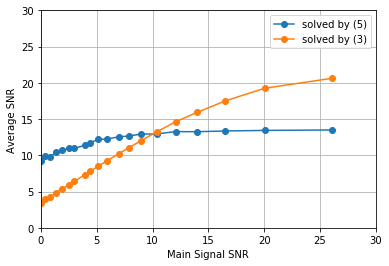

In [34]:
plt.plot(av_main_snr[0,:],av_mean_snr[0,:], label = "solved by (5)", marker='o')
plt.plot(av_main_snr[0,:],av_mean_snr_eq[0,:], label = "solved by (3)", marker='o')
plt.legend(loc ="upper right")
plt.ylabel("Average SNR")
plt.xlabel("Main Signal SNR")
plt.grid()
plt.ylim([0,30])
plt.xlim([0,30])
plt.show()

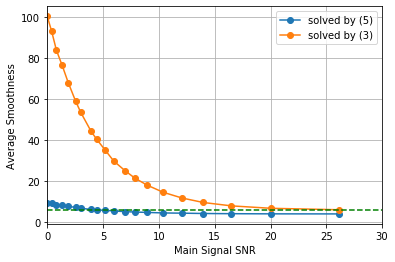

In [35]:
# smoothness
plt.plot(av_main_snr[0,:],av_smoothness_vs_noise[0,:]/k, label = "solved by (5)", marker='o')
plt.plot(av_main_snr[0,:],av_smoothness_eq_vs_noise[0,:]/k, label = "solved by (3)", marker='o')
plt.axhline(y = sumOverSmoothness/k, color = 'g', linestyle = '--')
plt.legend(loc ="upper right")
plt.ylabel("Average Smoothness")
plt.xlabel("Main Signal SNR")
plt.xlim([0,30])
plt.grid()
plt.show()

In [36]:
output_df1 = pd.DataFrame({'x': av_main_snr[0,:],'y1': av_mean_snr[0,:], 'y2':av_mean_snr_eq[0,:]})  
output_df1.to_csv('avarageSNR_noisy.dat')
output_df2 = pd.DataFrame({'x': av_main_snr[0,:],'y1': av_smoothness_vs_noise[0,:]/k, 'y2':av_smoothness_eq_vs_noise[0,:]/k})  
output_df2.to_csv('avarageSmoothness_noisy.dat')
print(sumOverSmoothness/k)

6.16433924719481
